# Import dependencies

In [2884]:
import cv2
import numpy as np
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import matplotlib
import scipy as scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os, fnmatch
from matplotlib.backends.backend_pdf import PdfPages
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 10})
import util
import re  # For regex
import seaborn as sns
import scipy.stats as stats
from matplotlib.transforms import Affine2D

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import and Concatenate files

In [2885]:
summary_dir = r"C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1"
dlc_dir = r"D:\Barrier_testing_day1_videos"
SIT_dir = r"C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\SIT"

In [2886]:
# Column names for the summary data
summary_columns = [
    "date", "subject", "sex", "condition", "experiment_name",
    "HR_Arm", "arm_choice", "eat", "start_time", "choice_time", "eat_time"
]

In [2887]:
# Function to collect specific files based on a naming pattern
def get_files_by_pattern(directory, pattern):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if pattern in file:
                file_paths.append(os.path.join(root, file))
    return file_paths

In [2888]:
dlc_dir = r"D:\Barrier_testing_day1_videos"
for root, _, files in os.walk(dlc_dir):
    for file in files:
        print(file)


031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000.h5
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.csv
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.h5
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_0DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_meta.pickle
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_1.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_1.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10.avi
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10.mp4v
031524_Barrier_Testing_10cm_Day_1_WT027MControl_StartArm_10DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000.h

In [2889]:
# Get all relevant files
summary_files = get_files_by_pattern(summary_dir, "TrialData.csv")
dlc_files = get_files_by_pattern(dlc_dir, "filtered.h5")
SIT_files = get_files_by_pattern(SIT_dir, "VideoData.csv")

In [2890]:
# len(dlc_files)

In [2891]:
# Process summary files
summary_combined = []
for summary_file in summary_files:
    summary_df = pd.read_csv(summary_file, header=None, names=summary_columns)

    # Filter rows with *Barrier_Testing* in the experiment_name column
    #summary_df = summary_df[summary_df['experiment_name'].str.contains("Barrier_Testing", na=False)]
    summary_df = summary_df[summary_df['experiment_name'].str.contains("barrier_testing", case=False, na=False)]
    
    # Add a 'trial' column based on the row index (1-based indexing for trial numbers)
    summary_df['trial'] = summary_df.index + 1
    summary_combined.append(summary_df)

In [2892]:
# Combine all summary data
summary_df = pd.concat(summary_combined, ignore_index=True)

In [2893]:
# Helper function to extract metadata from filename
def extract_metadata(filepath):
    filename = os.path.basename(filepath)
    
    # Extract condition: look for 'Control' or 'CNSDS'
    condition_match = re.search(r'(Control|CNSDS)', filename, re.IGNORECASE)
    condition = condition_match.group(1).capitalize() if condition_match else None

    # Extract subject: assume it's the number after the first underscore
    subject_match = re.search(r'_(\d+)', filename)
    subject = int(subject_match.group(1)) if subject_match else None

    # Extract test type: look for C57, DC1, or no (case insensitive)
    test_match = re.search(r'(C57|CD1|no)', filename, re.IGNORECASE)
    test = test_match.group(1).upper() if test_match else None

    return condition, subject, test

# Concatenate with metadata
all_dfs = []
for file in SIT_files:
    df = pd.read_csv(file)
    condition, subject, test = extract_metadata(file)
    df['condition'] = condition
    df['subject'] = subject
    df['test'] = test
    all_dfs.append(df)

# Combine into single DataFrame
SIT_df = pd.concat(all_dfs, ignore_index=True)

# Filter out invalid positions
SIT_df = SIT_df[(SIT_df['xpos'] >= 0) & (SIT_df['ypos'] >= 0)]

# Preview
print(SIT_df[['condition', 'subject', 'test']].drop_duplicates())


        condition  subject test
57          Cnsds       22  C57
9627        Cnsds       22  CD1
18984       Cnsds       22   NO
28174       Cnsds       23  C57
37429       Cnsds       23  CD1
...           ...      ...  ...
1091412   Control       60  CD1
1101599   Control       60   NO
1110978   Control       61  C57
1120999   Control       61  CD1
1132168   Control       61   NO

[120 rows x 3 columns]


In [2894]:
summary_df['experiment_name'] = summary_df['experiment_name'].replace({
    'Barrier_Testing__10cm_Day_1': 'Barrier_Testing_10cm_Day_1',
    'Barrier_Testing_20cm_Day1': 'Barrier_Testing_20cm_Day_1',
    'barrier_testing_20cm_day_1': 'Barrier_Testing_20cm_Day_1'
})


In [2895]:
summary_df['experiment_name'] = summary_df['experiment_name'].replace({
    'Barrier_Testing_10cm_Day_1': '10cm_Barrier',
    'Barrier_Testing_15cm_Day_1': '15cm_Barrier',
    'Barrier_Testing_20cm_Day_1': '20cm_Barrier'
})


# Choice

In [2896]:
# Lowercase the values in the 'HR_Arm' column
summary_df['HR_Arm'] = summary_df['HR_Arm'].str.lower()

# Create the 'choice' column based on comparison
summary_df['choice'] = summary_df['arm_choice'] == summary_df['HR_Arm']


In [2897]:
# Ensure 'choice' is boolean
summary_df['choice'] = summary_df['choice'].astype(bool)

# Group by experiment_name and subject
grouped = summary_df.groupby(['experiment_name', 'subject'])

# Calculate HR_percentage: number of True values divided by total count
analysis_df = grouped['choice'].agg(
    HR_percentage=lambda x: x.sum() / len(x)
).reset_index()

# Get condition and sex info (drop duplicates to avoid merge issues)
meta_info = summary_df.drop_duplicates(subset=['experiment_name', 'subject'])[
    ['date', 'experiment_name', 'subject', 'condition', 'sex']
]

# Merge meta info into the analysis_df
analysis_df = analysis_df.merge(meta_info, on=['experiment_name', 'subject'], how='left')

In [2898]:
# Count number of True in 'choice' per 'experiment_name' and 'subject'
true_counts = summary_df.groupby(['experiment_name', 'subject'])['choice'].sum().reset_index()

# Count the total number of rows per 'experiment_name' and 'subject' (i.e., total trials)
total_counts = summary_df.groupby(['experiment_name', 'subject']).size().reset_index(name='total_trials')

# Merge the two counts together
hr_ratio_df = pd.merge(true_counts, total_counts, on=['experiment_name', 'subject'])

# Calculate the HR ratio (True count / Total trials)
hr_ratio_df['HR_ratio'] = hr_ratio_df['choice'] / hr_ratio_df['total_trials']

# Drop the 'choice' and 'total_trials' columns, if not needed
#hr_ratio_df.drop(columns=['choice', 'total_trials'], inplace=True)

# Merge HR_ratio into analysis_df based on 'experiment_name' and 'subject'
analysis_df = analysis_df.merge(hr_ratio_df, on=['experiment_name', 'subject'], how='left')


In [2899]:
analysis_df['date'] = analysis_df['date'].astype(str).replace({
    '6262024': '62624',
    '6292024': '62924',
    '7022024': '70224'
})


c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


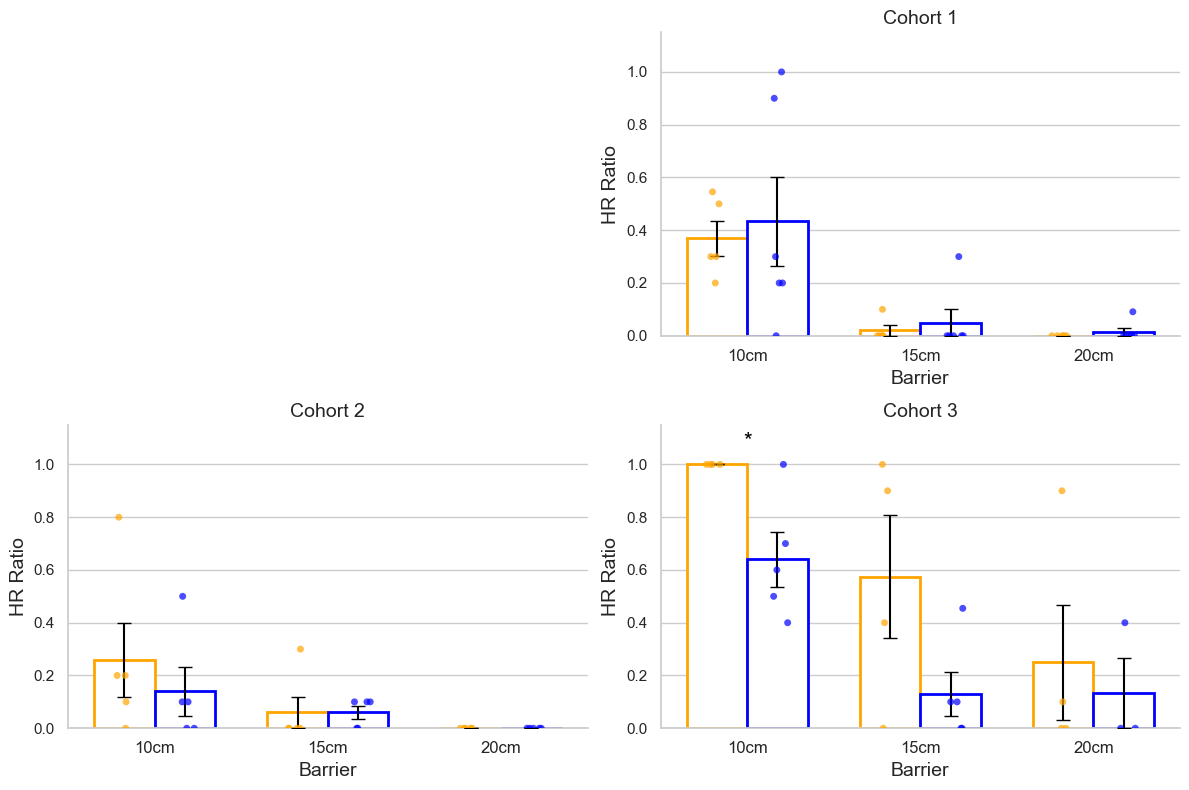

In [2900]:
# Define cohort dates
dates_to_analyze = [
    ['31524', '31824', '32124'],   # Cohort 1
    ['50524', '50824', '51124'],   # Cohort 2
    ['62624', '62924', '70224']    # Cohort 3
]

# Ensure date is string
analysis_df['date'] = analysis_df['date'].astype(str)

# Map dates to cohorts
cohort_map = {date: f"Cohort {i + 1}" for i, group in enumerate(dates_to_analyze) for date in group}
analysis_df['cohort'] = analysis_df['date'].map(cohort_map)
analysis_df = analysis_df.dropna(subset=['cohort'])

# Set condition order and palette
analysis_df['condition'] = pd.Categorical(analysis_df['condition'], ['Control', 'CNSDS'], ordered=True)
palette = {'Control': 'orange', 'CNSDS': 'blue'}

# Set up subplot layout
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
axes = [fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]
cohorts = [f"Cohort {i + 1}" for i in range(3)]

# for ax, cohort in zip(axes, cohorts):
#     df = analysis_df[analysis_df['cohort'] == cohort]
#     experiments = df['experiment_name'].unique()
#     bar_width = 0.35

#     # Calculate bar positions manually
#     for i, exp in enumerate(experiments):
#         for j, condition in enumerate(['Control', 'CNSDS']):
#             group = df[(df['experiment_name'] == exp) & (df['condition'] == condition)]
#             if not group.empty:
#                 mean = group['HR_ratio'].mean()
#                 se = group['HR_ratio'].sem()
#                 x_pos = i - bar_width/2 if condition == 'Control' else i + bar_width/2
#                 ax.bar(
#                     x=x_pos, height=mean, width=bar_width,
#                     edgecolor=palette[condition],
#                     facecolor='white',
#                     linewidth=2,
#                     label=condition if i == 0 else "",  # avoid duplicate legend
#                     zorder=2
#                 )
#                 # Error bar
#                 ax.errorbar(
#                     x=x_pos, y=mean, yerr=se,
#                     fmt='none', ecolor='black', capsize=5, zorder=3
#                 )

#     # Overlay data points
#     sns.stripplot(
#         data=df,
#         x='experiment_name',
#         y='HR_ratio',
#         hue='condition',
#         dodge=True,
#         palette=palette,
#         jitter=True,
#         marker='o',
#         alpha=0.7,
#         ax=ax,
#         zorder=4
#     )

#     # Run t-tests and add asterisks
#     for i, exp in enumerate(experiments):
#         subset = df[df['experiment_name'] == exp]
#         ctrl = subset[subset['condition'] == 'Control']['HR_ratio']
#         cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
#         if len(ctrl) > 1 and len(cnsds) > 1:
#             stat, pval = ttest_ind(ctrl, cnsds, equal_var=False)
#             if pval < 0.05:
#                 y_max = subset['HR_ratio'].max()
#                 ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='black')
#     ax.set_ylim(0, 1.15)
#     ax.set_title(cohort, fontsize=14)
#     ax.set_xlabel("Barrier", fontsize=14)
#     ax.set_ylabel("HR Ratio", fontsize=14)
#     ax.set_xticks(range(len(experiments)))
#     ax.set_xticklabels(['10cm', '15cm', '20cm'], fontsize=12)
#     ax.legend()

# plt.tight_layout()
# plt.savefig("cohort_choice.pdf", format="pdf")
# plt.show()

for ax, cohort in zip(axes, cohorts):
    df = analysis_df[analysis_df['cohort'] == cohort]
    experiments = df['experiment_name'].unique()
    bar_width = 0.35

    # Plot bars and error bars (your existing code)
    for i, exp in enumerate(experiments):
        for j, condition in enumerate(['Control', 'CNSDS']):
            group = df[(df['experiment_name'] == exp) & (df['condition'] == condition)]
            if not group.empty:
                mean = group['HR_ratio'].mean()
                se = group['HR_ratio'].sem()
                x_pos = i - bar_width/2 if condition == 'Control' else i + bar_width/2
                ax.bar(
                    x=x_pos, height=mean, width=bar_width,
                    edgecolor=palette[condition],
                    facecolor='white',
                    linewidth=2,
                    label=condition if i == 0 else "",
                    zorder=2
                )
                ax.errorbar(
                    x=x_pos, y=mean, yerr=se,
                    fmt='none', ecolor='black', capsize=5, zorder=3
                )

    sns.stripplot(
        data=df,
        x='experiment_name',
        y='HR_ratio',
        hue='condition',
        dodge=True,
        palette=palette,
        jitter=True,
        marker='o',
        alpha=0.7,
        ax=ax,
        zorder=4
    )

    # T-tests and asterisks
    for i, exp in enumerate(experiments):
        subset = df[df['experiment_name'] == exp]
        ctrl = subset[subset['condition'] == 'Control']['HR_ratio']
        cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
        if len(ctrl) > 1 and len(cnsds) > 1:
            stat, pval = ttest_ind(ctrl, cnsds, equal_var=False)
            if pval < 0.05:
                y_max = subset['HR_ratio'].max()
                ax.text(i, y_max + 0.05, '*', ha='center', va='bottom', fontsize=16, color='black')

    ax.set_ylim(0, 1.15)
    ax.set_title(cohort, fontsize=14)
    ax.set_xlabel("Barrier", fontsize=14)
    ax.set_ylabel("HR Ratio", fontsize=14)
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(['10cm', '15cm', '20cm'], fontsize=12)

    # Remove legend for all subplots
    ax.get_legend().remove()

    # Remove top and right spines
    sns.despine(ax=ax, top=True, right=True)

plt.tight_layout()
plt.savefig("cohort_choice.pdf", format="pdf")
plt.show()



In [2901]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import matplotlib.gridspec as gridspec

# # Define date clusters for cohorts
# dates_to_analyze = [
#     ['31524', '31824', '32124'],   # Cohort 1
#     ['50524', '50824', '51124'],   # Cohort 2
#     ['62624', '62924', '70224']    # Cohort 3
# ]

# # Assuming analysis_df already exists, and `date` and `condition` columns are in the data
# # Convert date to string if needed
# analysis_df['date'] = analysis_df['date'].astype(str)

# # Map dates to cohort labels
# cohort_map = {}
# for i, date_group in enumerate(dates_to_analyze):
#     for date in date_group:
#         cohort_map[date] = f"Cohort {i + 1}"

# analysis_df['cohort'] = analysis_df['date'].map(cohort_map)
# analysis_df = analysis_df.dropna(subset=['cohort'])

# # Sort conditions and color palette
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # Set up grid layout: 2x2, with the third plot on bottom left or full width
# fig = plt.figure(figsize=(12, 8))  # Larger figure size for clearer display
# gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])  # 2x2 grid layout

# # Subplot positions
# ax1 = fig.add_subplot(gs[0, 0])  # top left
# ax2 = fig.add_subplot(gs[0, 1])  # top right
# ax3 = fig.add_subplot(gs[1, 0])  # bottom left (or use [1, :] for full width)

# axes = [ax1, ax2, ax3]
# cohorts = [f"Cohort {i + 1}" for i in range(3)]

# # Plotting each cohort
# for ax, cohort in zip(axes, cohorts):
#     df = analysis_df[analysis_df['cohort'] == cohort]

#     # Plot bars for Control (orange outline) and CNSDS (blue outline)
#     for condition in ['Control', 'CNSDS']:
#         condition_data = df[df['condition'] == condition]

#         # Draw bars for each condition (no fill color, just edgecolor)
#         sns.barplot(
#             data=condition_data,
#             x='experiment_name',
#             y='HR_ratio',
#             hue='condition',
#             errorbar=('se', 1),
#             dodge=True,
#             ax=ax,
#             color='none',  # Transparent fill
#             edgecolor='orange' if condition == 'Control' else 'blue',  # Outline color
#             linewidth=2  # Bar outline thickness
#         )

#     ax.set_title(f"{cohort}", fontsize=16)  # Title for each subplot
#     ax.set_xlabel("Experiment Name", fontsize=12)
#     ax.set_ylabel("HR Ratio", fontsize=12)

# # Adjust layout and show plot
# plt.tight_layout()
# plt.savefig("cohort_choice.pdf", format="pdf")
# plt.show()

In [2902]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import matplotlib.gridspec as gridspec

# # Define date clusters for cohorts
# dates_to_analyze = [
#     ['31524', '31824', '32124'],   # Cohort 1
#     ['50524', '50824', '51124'],   # Cohort 2
#     ['62624', '62924', '70224']    # Cohort 3
# ]

# # Convert date to string if needed
# analysis_df['date'] = analysis_df['date'].astype(str)

# # Map dates to cohort labels
# cohort_map = {}
# for i, date_group in enumerate(dates_to_analyze):
#     for date in date_group:
#         cohort_map[date] = f"Cohort {i + 1}"

# analysis_df['cohort'] = analysis_df['date'].map(cohort_map)
# analysis_df = analysis_df.dropna(subset=['cohort'])

# # Sort conditions and color palette
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)
# palette = {'Control': 'orange', 'CNSDS': 'blue'}

# # Set up grid layout: 2x2, with the third plot on bottom left or full width
# fig = plt.figure(figsize=(10, 6))
# gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# # Subplot positions
# ax1 = fig.add_subplot(gs[0, 0])  # top left
# ax2 = fig.add_subplot(gs[0, 1])  # top right
# ax3 = fig.add_subplot(gs[1, 0])  # bottom left (or use [1, :] for full width)

# axes = [ax1, ax2, ax3]
# cohorts = [f"Cohort {i + 1}" for i in range(3)]

# # Plotting each cohort
# for ax, cohort in zip(axes, cohorts):
#     df = analysis_df[analysis_df['cohort'] == cohort]

#     sns.barplot(
#         data=df,
#         x='experiment_name',
#         y='HR_ratio',
#         hue='condition',
#         errorbar=('se', 1),
#         edgecolor=palette,
#         dodge=True,
#         ax=ax,
#         color='none',  # Transparent fill
#         edgecolor='orange' if condition == 'Control' else 'blue',  # Outline color
#             linewidth=2  # Bar outline thickness
#     )

#     sns.stripplot(
#         data=df,
#         x='experiment_name',
#         y='HR_ratio',
#         hue='condition',
#         palette=palette,
#         dodge=True,
#         jitter=True,
#         marker='o',
#         alpha=0.7,
#         ax=ax
#     )

#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[:2], labels[:2], title='Condition')

#     ax.set_title(cohort)
#     ax.set_xlabel('Barrier')
#     ax.set_ylabel('HR Ratio')
#     ax.set_ylim(0, 1.1)
#     ax.set_xticklabels(['10cm', '15cm', '20cm'])

# plt.tight_layout()
# plt.savefig("cohort_choice.pdf", format="pdf")
# plt.show()


In [2903]:
# Define the specific dates to analyze
dates_to_analyze = [
    ['31524', '31824', '32124'],
    ['50524', '50824', '51124'],
    ['62624', '62924', '70224']
]
# Loop through each set of dates
for i, dates in enumerate(dates_to_analyze):
    # Filter the DataFrame for the current set of dates
    subset = analysis_df[analysis_df['date'].isin(dates)]
    
    # Group by date and condition and extract the HR_ratio
    grouped = subset.groupby(['date', 'condition'])['HR_ratio'].apply(list).reset_index()

    print(f"T-tests for subplot {i + 1}:")
    
    # Perform t-tests for each date between Control and CNSDS
    for date in dates:
        # Extract the HR_ratio data for Control and CNSDS conditions for this date
        control_data = grouped[(grouped['date'] == date) & (grouped['condition'] == 'Control')]['HR_ratio'].values
        cnsds_data = grouped[(grouped['date'] == date) & (grouped['condition'] == 'CNSDS')]['HR_ratio'].values
        
        # Check if there is data for both conditions
        if len(control_data) == 0 or len(cnsds_data) == 0:
            print(f"  Date {date}: Missing data for Control or CNSDS condition, skipping t-test.")
            continue
        
        # Flatten the lists of HR_ratio for each condition (to make them arrays for t-test)
        control_data = control_data[0]  # Get the list inside the array
        cnsds_data = cnsds_data[0]  # Get the list inside the array
        
        # Run the t-test (assuming independent samples)
        t_stat, p_value = stats.ttest_ind(control_data, cnsds_data)
        
        # Print results
        print(f"  Date: {date} | t-statistic: {t_stat:.4f} | p-value: {p_value:.4f}")
    
    print("\n")

#graph this


T-tests for subplot 1:
  Date: 31524 | t-statistic: -0.3283 | p-value: 0.7502
  Date: 31824 | t-statistic: -0.5159 | p-value: 0.6184
  Date: 32124 | t-statistic: -0.9045 | p-value: 0.3893


T-tests for subplot 2:
  Date: 50524 | t-statistic: 0.7146 | p-value: 0.4952
  Date: 50824 | t-statistic: -0.0000 | p-value: 1.0000
  Date: 51124 | t-statistic: nan | p-value: nan


T-tests for subplot 3:
  Date: 62624 | t-statistic: 3.0837 | p-value: 0.0177
  Date: 62924 | t-statistic: 1.9726 | p-value: 0.0892
  Date: 70224 | t-statistic: 0.4152 | p-value: 0.6952




C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\1849252293.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = subset.groupby(['date', 'condition'])['HR_ratio'].apply(list).reset_index()
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\1849252293.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = subset.groupby(['date', 'condition'])['HR_ratio'].apply(list).reset_index()
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\1849252293.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

In [2904]:
# # Get unique experiments
# experiments = analysis_df['experiment_name'].unique()

# # Initialize lists for results
# t_stats = []
# dfs = []
# raw_p_values = []
# experiment_labels = []

# # Run t-tests for each experiment
# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment_name'] == exp]
#     control = subset[subset['condition'] == 'Control']['HR_ratio']
#     cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
    
#     # Only run t-test if there are enough data points in both groups
#     if len(control) > 1 and len(cnsds) > 1:
#         t_stat, p = ttest_ind(control, cnsds, equal_var=False)  # Welch’s t-test

#         # Calculate degrees of freedom using Welch-Satterthwaite equation
#         n1, n2 = len(control), len(cnsds)
#         s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
#         df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/((n1**2)*(n1-1)) + (s2_sq**2)/((n2**2)*(n2-1)))
        
#         t_stats.append(t_stat)
#         dfs.append(df)
#         raw_p_values.append(p)
#         experiment_labels.append(exp)
#     else:
#         t_stats.append(None)
#         dfs.append(None)
#         raw_p_values.append(None)
#         experiment_labels.append(exp)

# # Apply Bonferroni correction (only to valid p-values)
# valid_indices = [i for i, p in enumerate(raw_p_values) if p is not None]
# valid_pvals = [raw_p_values[i] for i in valid_indices]

# reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')

# # Collect results into a dictionary
# results = {}
# for i, idx in enumerate(valid_indices):
#     exp = experiment_labels[idx]
#     results[exp] = {
#         't_stat': t_stats[idx],
#         'df': dfs[idx],
#         'raw_p': raw_p_values[idx],
#         'corrected_p': corrected_pvals[i],
#         'significant': reject[i]
#     }

# # Print results
# for exp, res in results.items():
#     print(f"{exp}: t={res['t_stat']:.3f}, df={res['df']:.1f}, p={res['raw_p']:.4f}, corrected_p={res['corrected_p']:.4f}, significant={res['significant']}")


In [2905]:
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
import numpy as np

# Get unique experiments
experiments = analysis_df['experiment_name'].unique()

# Initialize lists for results
t_stats = []
dfs = []
raw_p_values = []
n_controls = []
n_cnsds = []
experiment_labels = []

# Run t-tests for each experiment
for exp in experiments:
    subset = analysis_df[analysis_df['experiment_name'] == exp]
    control = subset[subset['condition'] == 'Control']['HR_ratio']
    cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
    
    n1, n2 = len(control), len(cnsds)

    # Only run t-test if there are enough data points in both groups
    if n1 > 1 and n2 > 1:
        t_stat, p = ttest_ind(control, cnsds, equal_var=False)  # Welch’s t-test

        # Calculate degrees of freedom using Welch-Satterthwaite equation
        s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/((n1**2)*(n1-1)) + (s2_sq**2)/((n2**2)*(n2-1)))
        
        t_stats.append(t_stat)
        dfs.append(df)
        raw_p_values.append(p)
        n_controls.append(n1)
        n_cnsds.append(n2)
        experiment_labels.append(exp)
    else:
        t_stats.append(None)
        dfs.append(None)
        raw_p_values.append(None)
        n_controls.append(n1)
        n_cnsds.append(n2)
        experiment_labels.append(exp)

# Apply Bonferroni correction (only to valid p-values)
valid_indices = [i for i, p in enumerate(raw_p_values) if p is not None]
valid_pvals = [raw_p_values[i] for i in valid_indices]

reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')

# Collect results into a dictionary
results = {}
for i, idx in enumerate(valid_indices):
    exp = experiment_labels[idx]
    results[exp] = {
        't_stat': t_stats[idx],
        'df': dfs[idx],
        'raw_p': raw_p_values[idx],
        'corrected_p': corrected_pvals[i],
        'significant': reject[i],
        'n_control': n_controls[idx],
        'n_cnsds': n_cnsds[idx]
    }

# Print results
for exp, res in results.items():
    print(f"{exp}: t={res['t_stat']:.3f}, df={res['df']:.1f}, "
          f"p={res['raw_p']:.4f}, corrected_p={res['corrected_p']:.4f}, "
          f"significant={res['significant']}, n_control={res['n_control']}, n_cnsds={res['n_cnsds']}")


10cm_Barrier: t=0.777, df=26.9, p=0.4439, corrected_p=1.0000, significant=False, n_control=14, n_cnsds=16
15cm_Barrier: t=1.171, df=16.1, p=0.2585, corrected_p=0.7754, significant=False, n_control=14, n_cnsds=16
20cm_Barrier: t=0.517, df=18.0, p=0.6113, corrected_p=1.0000, significant=False, n_control=14, n_cnsds=14


In [2906]:
# Import necessary functions
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm

# Get unique experiments
experiments = analysis_df['experiment_name'].unique()

# Run t-tests for each experiment
p_values = []
experiment_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment_name'] == exp]
    control = subset[subset['condition'] == 'Control']['HR_ratio']
    cnsds = subset[subset['condition'] == 'CNSDS']['HR_ratio']
    
    # Only run t-test if there are enough data points in both groups
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds)
        p_values.append(p)
        experiment_labels.append(exp)
    else:
        p_values.append(None)
        experiment_labels.append(exp)

# Apply Bonferroni correction
reject, corrected_pvals, _, _ = smm.multipletests([p for p in p_values if p is not None], method='bonferroni')

# Map results back to experiments
pval_results = dict(zip([e for e, p in zip(experiment_labels, p_values) if p is not None], zip(corrected_pvals, reject)))

# Print the results
print(pval_results)


{'10cm_Barrier': (1.0, False), '15cm_Barrier': (0.6820765041404178, False), '20cm_Barrier': (1.0, False)}


In [2907]:
# plt.figure(figsize=(10, 6))

# # Make sure the conditions are ordered
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # Plot the barplot
# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment_name',
#     y='HR_ratio',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar=('se', 1),
#     dodge=True
# )

# # Add individual data points
# sns.stripplot(
#     data=analysis_df,
#     x='experiment_name',
#     y='HR_ratio',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     alpha=0.6,
#     marker='o'
# )

# # Fix the legend (duplicate due to hue being used twice)
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title="Condition")

# # Add corrected p-values and asterisk if significant
# xticks = ax.get_xticks()
# experiments = analysis_df['experiment_name'].unique()

# for i, exp in enumerate(experiments):
#     if exp in pval_results:
#         corrected_p, significant = pval_results[exp]
#         label = f"*  p = {corrected_p:.3f}" if significant else f"p = {corrected_p:.3f}"
        
#         # Find max y-value in current group for spacing
#         max_y = analysis_df[analysis_df['experiment_name'] == exp]['HR_ratio'].max()
#         y_pos = max_y + 0.05
        
#         # Get center x-position for this experiment group
#         xpos = xticks[i]
#         plt.text(xpos, y_pos, label, ha='center', va='bottom', fontsize=10, color='black')

# plt.title('HR Ratio by Condition and Experiment')
# plt.ylabel('HR Ratio')
# plt.ylim(0, 1.15)
# plt.xlabel('Experiment Name')
# plt.tight_layout()
# plt.show()


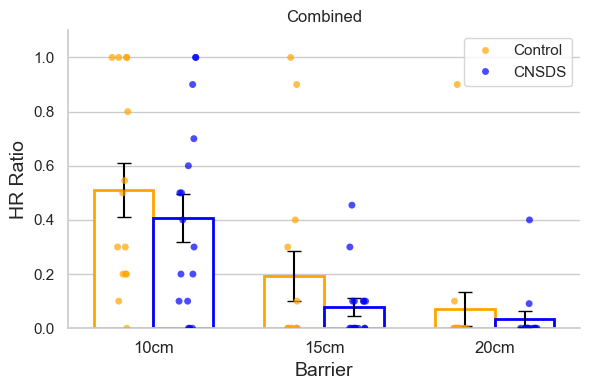

In [2908]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Ensure correct category order
analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)
palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35

# Prepare figure
plt.figure(figsize=(6, 4))
ax = plt.gca()

# Get x positions for experiments
experiments = analysis_df['experiment_name'].unique()
x_pos = range(len(experiments))

# Draw custom bars
for i, exp in enumerate(experiments):
    for j, cond in enumerate(['Control', 'CNSDS']):
        subset = analysis_df[(analysis_df['experiment_name'] == exp) & (analysis_df['condition'] == cond)]
        if not subset.empty:
            mean = subset['HR_ratio'].mean()
            se = subset['HR_ratio'].sem()
            offset = -bar_width/2 if cond == 'Control' else bar_width/2
            bar_x = i + offset

            ax.bar(
                bar_x, mean,
                width=bar_width,
                color='white',
                edgecolor=palette[cond],
                linewidth=2,
                zorder=2
            )
            ax.errorbar(bar_x, mean, yerr=se, fmt='none', ecolor='black', capsize=5, zorder=3)

# Overlay individual data points
sns.stripplot(
    data=analysis_df,
    x='experiment_name',
    y='HR_ratio',
    hue='condition',
    palette=palette,
    dodge=True,
    jitter=True,
    marker='o',
    alpha=0.7,
    ax=ax,
    zorder=4
)

# Fix legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

# Custom x-axis labels
ax.set_xticks(x_pos)
ax.set_xticklabels(['10cm', '15cm', '20cm'], fontsize=12)

# Labels and limits
ax.set_ylabel('HR Ratio', fontsize=14)
ax.set_xlabel('Barrier', fontsize=14)
ax.set_ylim(0, 1.1)
ax.set_title('Combined')

sns.despine(ax=ax, top=True, right=True)
plt.tight_layout()
plt.savefig("overall_choice_plot.pdf", format="pdf")
plt.show()


In [2909]:
# plt.figure(figsize=(10, 6))

# # Sort conditions
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # Plot bars + individual data points
# sns.barplot(data=analysis_df, x='experiment_name', y='HR_ratio', hue='condition',
#             errorbar=('se', 1), palette={'Control': 'orange', 'CNSDS': 'blue'}, dodge=True, )


# sns.stripplot(data=analysis_df, x='experiment_name', y='HR_ratio', hue='condition',
#               palette={'Control': 'orange', 'CNSDS': 'blue'}, dodge=True, jitter=True, marker='o', alpha=0.7)

# # Remove duplicated legend
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2])

# # Add corrected p-values + asterisk for significance above bars
# # for i, exp in enumerate(experiments):
# #     if exp in pval_results:
# #         pval, significant = pval_results[exp]
# #         label = f"*  p = {pval:.3f}" if significant else f"p = {pval:.3f}"
# #         plt.text(i, 1.05, label, ha='center', va='bottom', fontsize=10, color='black')

# # Rename x-axis ticks
# plt.xticks(ticks=range(len(analysis_df['experiment_name'].unique())), labels=['10cm', '15cm', '20cm'], fontsize=12)

# plt.ylabel('HR Ratio', fontsize=14)
# plt.xlabel('Barrier', fontsize=14)
# plt.ylim(0, 1.1)  # leave room for stars

# plt.tight_layout()
# plt.savefig("overall_choice_plot.pdf", format="pdf")  # Save it first
# plt.show()  # Then show it


# Trial duration

In [2910]:
# function to find files
def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files: 
            if fnmatch.fnmatch(name,pattern): 
                result.append(os.path.join(root,name))
    if len(result)==1:
        result = result[0]
    return result

def get_vidname_from_row(row,vid_path):
    try:
        name = str(row['date']).zfill(8) + '*Barrier_Testing*' + row['subject'] + '*' + 'StartArm_%s' % str(int(row['trial'])-1) + '.avi'
        print('looking for file %s ' % name)
        vid_name = find(name,vid_path)
        vid = cv2.VideoCapture(vid_name)
    except:
        name = str(row['date']).zfill(6) + '*Barrier_Testing*' + row['subject'] + '*' + 'StartArm_%s' % str(int(row['trial'])-1) + '.avi'
        print('looking for file %s ' % name)
        vid_name = find(name,vid_path)
        vid = cv2.VideoCapture(vid_name)
    return vid

In [2911]:
#convert time stamps into seconds 
# go through summary_df, for each row find the video (chopped), load it in using open cv and get the total number of frames
#get frame rate from the video
#frames/framespersecond
#load the side video
trial_duration = []
for index,row in summary_df.iterrows():
    vid = get_vidname_from_row(row,dlc_dir)
    tot_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    trial_duration.append(tot_frames/fps)
    vid.release()
summary_df['trial_duration'] = trial_duration

looking for file 00031524*Barrier_Testing*WT022*StartArm_0.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_0.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_1.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_1.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_2.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_2.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_3.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_3.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_4.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_4.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_5.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_5.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_6.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm_6.avi 
looking for file 00031524*Barrier_Testing*WT022*StartArm_7.avi 
looking for file 031524*Barrier_Testing*WT022*StartArm

In [2912]:
summary_df = summary_df.rename(columns={'experiment': 'experiment_name'})


In [2913]:
#summary_df = summary_df.dropna(subset=['experiment_name', 'subject', 'trial_duration'])
avg_duration = summary_df.groupby(['experiment_name', 'subject'])['trial_duration'].mean().reset_index()
avg_duration.rename(columns={'trial_duration': 'avg_trial_duration'}, inplace=True)
analysis_df = analysis_df.merge(avg_duration, on=['experiment_name', 'subject'], how='left')

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\2188159805.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df


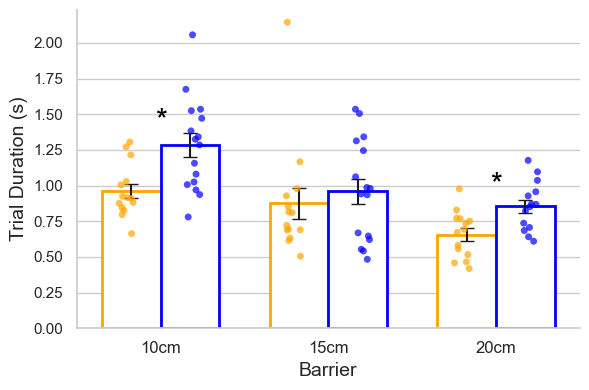

In [2914]:
# 1. Calculate p-values
experiments = analysis_df['experiment_name'].unique()
p_values = []
experiment_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment_name'] == exp]
    control = subset[subset['condition'] == 'Control']['avg_trial_duration']
    cnsds = subset[subset['condition'] == 'CNSDS']['avg_trial_duration']
    
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds)
        p_values.append(p)
        experiment_labels.append(exp)
    else:
        p_values.append(None)
        experiment_labels.append(exp)

# Apply Bonferroni correction
valid_pvals = [p for p in p_values if p is not None]
reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')
pval_results = dict(zip([e for e, p in zip(experiment_labels, p_values) if p is not None], zip(corrected_pvals, reject)))

# 2. Create the plot
plt.figure(figsize=(6, 4))

analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)
palette = {'Control': 'orange', 'CNSDS': 'blue'}

# Calculate means and SEMs for manual bar plotting
summary = (
    analysis_df
    .groupby(['experiment_name', 'condition'])['avg_trial_duration']
    .agg(['mean', 'sem'])
    .reset_index()
)

# Bar positions
x_labels = ['10cm', '15cm', '20cm']
x_positions = range(len(x_labels))
bar_width = 0.35

for i, exp in enumerate(experiments):
    for j, cond in enumerate(['Control', 'CNSDS']):
        row = summary[(summary['experiment_name'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
            color = palette[cond]
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=color, linewidth=2,
                capsize=5
            )

# Stripplot for individual data points
sns.stripplot(
    data=analysis_df, x='experiment_name', y='avg_trial_duration', hue='condition',
    palette=palette, dodge=True, jitter=True, marker='o', alpha=0.7, legend = False
)

# Fix legend
#handles, labels = plt.gca().get_legend_handles_labels()
#plt.legend(handles[:2], labels[:2], title='Condition')

# Add asterisks for significance
y_max = analysis_df['avg_trial_duration'].max()
bar_offset = 0.1 * y_max
# for i, exp in enumerate(experiments):
#     if exp in pval_results:
#         pval, significant = pval_results[exp]
#         if significant:
#             plt.text(i, y_max + bar_offset, '*', ha='center', va='bottom', fontsize=16, color='black')

for i, exp in enumerate(experiments):
    if exp in pval_results:
        pval, significant = pval_results[exp]
        if significant:
            # Find max bar height for this experiment (across conditions)
            max_bar = summary[summary['experiment_name'] == exp]['mean'].max()
            # Place asterisk a bit above this max bar, adjust offset here
            bar_offset = 0.05 * max_bar  # smaller offset → moves asterisk closer to bar
            
            plt.text(i, max_bar + bar_offset, '*', ha='center', va='bottom', fontsize=22, color='black')


# X-axis and formatting
plt.xticks(ticks=x_positions, labels=x_labels, fontsize = 12)
plt.ylabel('Trial Duration (s)', fontsize = 14)
plt.xlabel('Barrier', fontsize = 14)
plt.ylim(0, y_max + 2 * bar_offset)

plt.tight_layout()

# Remove top and right spines
sns.despine(top=True, right=True)
plt.savefig("trial_duration.pdf", format="pdf")

plt.show()


In [2915]:
# # 1. Calculate the p-values for each experiment_name by comparing Control and CNSDS using avg_trial_duration
# experiments = analysis_df['experiment_name'].unique()
# p_values = []
# experiment_labels = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment_name'] == exp]
#     control = subset[subset['condition'] == 'Control']['avg_trial_duration']
#     cnsds = subset[subset['condition'] == 'CNSDS']['avg_trial_duration']
    
#     if len(control) > 1 and len(cnsds) > 1:
#         stat, p = ttest_ind(control, cnsds)
#         p_values.append(p)
#         experiment_labels.append(exp)
#     else:
#         p_values.append(None)
#         experiment_labels.append(exp)

# # Apply Bonferroni correction to the p-values
# reject, corrected_pvals, _, _ = smm.multipletests([p for p in p_values if p is not None], method='bonferroni')

# # Map results back to the experiment names
# pval_results = dict(zip([e for e, p in zip(experiment_labels, p_values) if p is not None], zip(corrected_pvals, reject)))

# # 2. Create the barplot with individual data points using avg_trial_duration

# plt.figure(figsize=(10, 6))

# # Ensure 'condition' is ordered correctly for plotting
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # Barplot for avg_trial_duration with error bars (standard error of the mean)
# sns.barplot(data=analysis_df, x='experiment_name', y='avg_trial_duration', hue='condition',
#             errorbar=('se', 1), palette={'Control': 'orange', 'CNSDS': 'blue'}, dodge=True)

# # Overlay stripplot for individual data points
# sns.stripplot(data=analysis_df, x='experiment_name', y='avg_trial_duration', hue='condition',
#               palette={'Control': 'orange', 'CNSDS': 'blue'}, dodge=True, jitter=True, marker='o', alpha=0.7)

# # Fix the legend to avoid duplicates
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title='Condition')

# # Add corrected p-values and asterisks for significance
# for i, exp in enumerate(experiments):
#     if exp in pval_results:
#         pval, significant = pval_results[exp]
#         label = f"*  p = {pval:.3f}" if significant else f"p = {pval:.3f}"
#         plt.text(i, 1.05, label, ha='center', va='bottom', fontsize=10, color='black')

# # Rename x-axis ticks
# plt.xticks(ticks=range(len(analysis_df['experiment_name'].unique())), labels=['10cm', '15cm', '20cm'])

# plt.title('Average Trial Duration')
# plt.ylabel('Average Trial Duration')
# plt.xlabel('Experiment Name')
# plt.ylim(0, analysis_df['avg_trial_duration'].max() * 1.1)  # Leave space for annotations
# plt.tight_layout()
# # Remove top and right spines
# sns.despine(top=True, right=True)
# plt.show()


In [2916]:
# # Standardize experiment names to combine similar ones
# summary_df['experiment_name'] = summary_df['experiment_name'] \
#     .str.replace(r'__', '_', regex=False) \
#     .str.replace(r'_Day1$', '_Day_1', regex=True)  # Standardize _Day1 to _Day_1

# # Confirm changes
# print(summary_df['experiment_name'].unique())

# Import DLC Files

In [2917]:
# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file and import its contents
for file in dlc_files:
    try:
        # Read the HDF file
        df = pd.read_hdf(file)
        
        # Append to the list of DataFrames
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Concatenate all the DataFrames into a single DataFrame
if dataframes:
    pts = pd.concat(dataframes, ignore_index=True)
    print("Successfully concatenated DLC files into a single DataFrame.")
else:
    pts = pd.DataFrame()  # If no files are read successfully
    print("No valid DLC files were imported.")

# Display the concatenated DataFrame
print(pts.head())

Successfully concatenated DLC files into a single DataFrame.
scorer    DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000  \
bodyparts                                              Maze_Center   
coords                                                           x   
0                                                 701.324158         
1                                                 701.326416         
2                                                 701.401733         
3                                                 701.326416         
4                                                 701.326416         

scorer                                                               \
bodyparts                               Nose                          
coords              y likelihood           x           y likelihood   
0          213.887344   0.979254  704.588867  732.099976   0.983530   
1          214.029877   0.977822  704.711670  732.099976   0.984463   
2          214.173889  

In [2918]:
pts.columns = [' '.join(col[:][1:3]).strip() for col in pts.columns.values]

In [2919]:
# Function to extract metadata from filename
def extract_metadata_from_filename(filename):
    # Extract trial number
    trial_match = re.search(r'_(\d+)DLC', filename)
    trial = int(trial_match.group(1)) + 1 if trial_match else None  # Convert to 1-based indexing
    
    # Extract experiment name (handles multiple formats)
    experiment_match = re.search(r'Barrier_Testing__?(\d+cm)_(Day(?:_1|1))', filename, re.IGNORECASE)
    experiment = f"Barrier_Testing_{experiment_match.group(1)}_Day_1" if experiment_match else None  # Standardize name
    
    # Extract subject ID (e.g., WT123 or MCN456)
    subject_match = re.search(r'(WT\d+|MCN\d+)', filename)
    subject = subject_match.group(1) if subject_match else None

    # Extract condition (e.g., CNSDS or Control)
    condition_match = re.search(r'(CNSDS|Control)', filename, re.IGNORECASE)
    condition = condition_match.group(1) if condition_match else None
    
    return trial, experiment, subject, condition

# Initialize an empty list to store DataFrames
dataframes = []

# Loop through each file and import its contents
for file in dlc_files:
    try:
        # Read the HDF file
        df = pd.read_hdf(file)

        # Extract metadata from the filename
        trial, experiment, subject, condition = extract_metadata_from_filename(os.path.basename(file))
        
        # Add metadata columns to the DataFrame
        df['trial'] = trial
        df['experiment'] = experiment
        df['subject'] = subject
        df['condition'] = condition

        # Append to the list of DataFrames
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")

# Concatenate all the DataFrames into a single DataFrame
if dataframes:
    pts = pd.concat(dataframes, ignore_index=True)
    print("Successfully concatenated DLC files into a single DataFrame.")
else:
    pts = pd.DataFrame()  # If no files are read successfully
    print("No valid DLC files were imported.")

# Simplify hierarchical column names (collapse the hierarchy)
pts.columns = [' '.join(col[1:3]).strip() for col in pts.columns.values]

# Display the concatenated DataFrame
print(pts.head())


Successfully concatenated DLC files into a single DataFrame.
   Maze_Center x  Maze_Center y  Maze_Center likelihood      Nose x  \
0     701.324158     213.887344                0.979254  704.588867   
1     701.326416     214.029877                0.977822  704.711670   
2     701.401733     214.173889                0.977686  704.779297   
3     701.326416     214.173889                0.980646  704.779297   
4     701.326416     214.173889                0.979866  704.779297   

       Nose y  Nose likelihood  Right_Ear x  Right_Ear y  \
0  732.099976         0.983530   722.632324   756.030640   
1  732.099976         0.984463   722.884888   756.030640   
2  732.099976         0.990444   724.357849   756.030640   
3  717.377258         0.997883   724.449707   744.604004   
4  701.130859         0.998654   727.348816   733.282166   

   Right_Ear likelihood  Left_Ear x  ...  Back_Left_Leg x  Back_Left_Leg y  \
0              0.766178  695.441406  ...       690.911682       878.66766

In [2920]:
pts.columns = list(pts.columns[:-4]) + ['trial', 'experiment', 'subject', 'condition']

In [2921]:
# Step 1: Convert 'experiment', 'trial', and 'subject' columns to strings (if they aren't already)
pts['experiment'] = pts['experiment'].astype(str)
pts['trial'] = pts['trial'].astype(str)
pts['subject'] = pts['subject'].astype(str)

#summary_df['experiment_name'] = summary_df['experiment_name'].astype(str)
#summary_df['trial'] = summary_df['trial'].astype(str)
#summary_df['subject'] = summary_df['subject'].astype(str)

# Step 2: Clean the 'experiment', 'trial', and 'subject' columns (strip spaces)
pts['experiment'] = pts['experiment'].str.strip()
pts['trial'] = pts['trial'].str.strip()
pts['subject'] = pts['subject'].str.strip()

#summary_df['experiment_name'] = summary_df['experiment_name'].str.strip()
#summary_df['trial'] = summary_df['trial'].str.strip()
#summary_df['subject'] = summary_df['subject'].str.strip()

# Step 3: Check unique values to verify they match (optional, just for debugging)
print("Unique experiment values in pts:", pts['experiment'].unique())
#print("Unique experiment values in summary_df:", summary_df['experiment_name'].unique())


Unique experiment values in pts: ['Barrier_Testing_10cm_Day_1' 'Barrier_Testing_15cm_Day_1'
 'Barrier_Testing_20cm_Day_1']


# Create Merged DF

In [2922]:
pts['experiment'] = pts['experiment'].replace({
    'Barrier_Testing__10cm_Day_1': 'Barrier_Testing_10cm_Day_1',
    'Barrier_Testing_20cm_Day1': 'Barrier_Testing_20cm_Day_1',
    'barrier_testing_20cm_day_1': 'Barrier_Testing_20cm_Day_1'
})

In [2923]:
pts['experiment'] = pts['experiment'].replace({
    'Barrier_Testing_10cm_Day_1': '10cm_Barrier',
    'Barrier_Testing_15cm_Day_1': '15cm_Barrier',
    'Barrier_Testing_20cm_Day_1': '20cm_Barrier'
})

In [2924]:
# Rename 'experiment_name' to 'experiment' in summary_df
#summary_df.rename(columns={'experiment_name': 'experiment'}, inplace=True)
analysis_df.rename(columns={'experiment_name': 'experiment'}, inplace=True)

# Step 4: Merge the dataframes on 'experiment', 'trial', and 'subject'
#merged_df = pd.merge(pts, summary_df, on=['experiment', 'trial', 'subject'], how='left')

# Step 5: Check the merged DataFrame
#print(merged_df.head())

# Calculate avg location

In [2925]:
# Replace spaces with underscores in all column names
pts.columns = pts.columns.str.replace(' ', '_')

# Verify the updated column names
print(pts.columns)

Index(['Maze_Center_x', 'Maze_Center_y', 'Maze_Center_likelihood', 'Nose_x',
       'Nose_y', 'Nose_likelihood', 'Right_Ear_x', 'Right_Ear_y',
       'Right_Ear_likelihood', 'Left_Ear_x', 'Left_Ear_y',
       'Left_Ear_likelihood', 'Middle_Neck_x', 'Middle_Neck_y',
       'Middle_Neck_likelihood', 'Middle_Spine_x', 'Middle_Spine_y',
       'Middle_Spine_likelihood', 'Tail_Base_x', 'Tail_Base_y',
       'Tail_Base_likelihood', 'Tail_Mid_x', 'Tail_Mid_y',
       'Tail_Mid_likelihood', 'Tail_End_x', 'Tail_End_y',
       'Tail_End_likelihood', 'Front_Left_Leg_x', 'Front_Left_Leg_y',
       'Front_Left_Leg_likelihood', 'Front_Right_Leg_x', 'Front_Right_Leg_y',
       'Front_Right_Leg_likelihood', 'Back_Left_Leg_x', 'Back_Left_Leg_y',
       'Back_Left_Leg_likelihood', 'Back_Right_Leg_x', 'Back_Right_Leg_y',
       'Back_Right_Leg_likelihood', 'trial', 'experiment', 'subject',
       'condition'],
      dtype='object')


In [2926]:
# # Replace spaces with underscores in all column names
# merged_df.columns = merged_df.columns.str.replace(' ', '_')

# # Verify the updated column names
# print(merged_df.columns)

In [2927]:
# Now, proceed with your logic to compute the averages
body_parts = ['Nose_', 'Right_Ear_', 'Left_Ear_', 'Middle_Neck_', 'Middle_Spine_', 
              'Tail_Base_', 'Tail_Mid_', 'Tail_End_', 'Front_Left_Leg_', 
              'Front_Right_Leg_', 'Back_Left_Leg_', 'Back_Right_Leg_']

coordinates = ['x', 'y']
likelihood_suffix = 'likelihood'

avg_x = []
avg_y = []

# Loop through each row of the DataFrame
for index, row in pts.iterrows():
    x_vals = []
    y_vals = []
    
    # Loop through each body part
    for part in body_parts:
        x_col = f"{part}x"
        y_col = f"{part}y"
        likelihood_col = f"{part}{likelihood_suffix}"
        
        # Check if the likelihood for this body part is greater than 0.7
        if row[likelihood_col] > 0.7:  # Assuming 0.7 is the threshold for likelihood
            x_vals.append(row[x_col])
            y_vals.append(row[y_col])
    
    # Exclude 'Maze_Center' columns
    if 'Maze_Center_x' in pts.columns and 'Maze_Center_y' in pts.columns:
        maze_center_x = row.get('Maze_Center_x', None)
        maze_center_y = row.get('Maze_Center_y', None)
        if maze_center_x and maze_center_y:
            # Remove the maze center values if present
            x_vals = [val for val in x_vals if val != maze_center_x]
            y_vals = [val for val in y_vals if val != maze_center_y]

    # Calculate the average of x and y coordinates (if there are valid points)
    if x_vals:
        avg_x.append(sum(x_vals) / len(x_vals))  # Average of x coordinates
        avg_y.append(sum(y_vals) / len(y_vals))  # Average of y coordinates
    else:
        avg_x.append(None)  # If no valid points, append None
        avg_y.append(None)

# Append the average columns to the DataFrame
pts['avg_x'] = avg_x
pts['avg_y'] = avg_y

# Calculate velocities

In [2928]:
frame_rate = 60

# Define the conversion factors for both x and y dimensions
scale_x = 7.62 / 230  # Width conversion factor
scale_y = 38.735 / 885  # Height conversion factor

# Combined scaling factor for velocity (Euclidean distance)
scale_velocity = np.sqrt(scale_x**2 + scale_y**2)

# Initialize an empty list to store velocity values in cm/s
velocities_cm = []

# Loop through the DataFrame, calculating velocity for each row (starting from the second frame)
for i in range(1, len(pts)):
    # Get the x and y coordinates for the current and previous frame
    x1, y1 = pts.loc[i-1, 'avg_x'], pts.loc[i-1, 'avg_y']  # Previous frame
    x2, y2 = pts.loc[i, 'avg_x'], pts.loc[i, 'avg_y']      # Current frame
    
    # Calculate the Euclidean distance between the current and previous position
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # Calculate the time difference (assuming constant frame rate)
    time = 1 / frame_rate
    
    # Calculate velocity (distance / time) in original units
    velocity = distance / time
    
    # Convert velocity to cm/s by multiplying with the scaling factor
    velocity_cm = velocity * scale_velocity
    velocities_cm.append(velocity_cm)

# Append the converted velocity values to the DataFrame
pts['velocity_cm'] = [None] + velocities_cm  # Add None for the first frame as there's no previous frame

# Verify the updated dataframe with the converted velocity_cm
#print(merged_df[['experiment', 'subject', 'trial', 'velocity', 'velocity_cm']].head())

In [2929]:
avg_velocity = pts.groupby(['experiment', 'subject'])['velocity_cm'].mean().reset_index()
avg_velocity.rename(columns={'velocity_cm': 'avg_velocity_cm'}, inplace=True)


In [2930]:
analysis_df = analysis_df.merge(
    avg_velocity,
    left_on=['experiment', 'subject'],
    right_on=['experiment', 'subject'],
    how='left'
)


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\795749688.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df


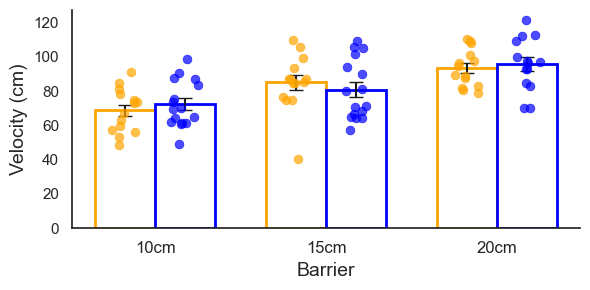

In [2931]:
# Remove grid background
sns.set_style("white")

# Define color palette
palette = {
    "Control": "orange",
    "CNSDS": "blue"
}

# Clean up experiment names
analysis_df['experiment'] = analysis_df['experiment'].str.replace('_Barrier', '', regex=False)

# Calculate means and SEM grouped by experiment and condition
group_stats = (
    analysis_df
    .groupby(['experiment', 'condition'])['avg_velocity_cm']
    .agg(['mean', 'sem'])
    .reset_index()
)

# Get unique experiment labels
experiments = group_stats['experiment'].unique()
conditions = ['Control', 'CNSDS']

# Set up the figure
plt.figure(figsize=(6, 3))

# Offset for bar positions
bar_width = 0.35
x = range(len(experiments))

# Plot bars with error bars
for i, condition in enumerate(conditions):
    color = palette[condition]
    means = []
    sems = []
    for exp in experiments:
        row = group_stats[(group_stats['experiment'] == exp) & (group_stats['condition'] == condition)]
        if not row.empty:
            means.append(row['mean'].values[0])
            sems.append(row['sem'].values[0])
        else:
            means.append(float('nan'))
            sems.append(float('nan'))

    bar_positions = [xi + (i - 0.5) * bar_width for xi in x]
    plt.bar(
        bar_positions,
        means,
        yerr=sems,
        capsize=5,
        width=bar_width,
        edgecolor=color,
        facecolor='white',
        linewidth=2,
        label=condition,
        zorder=2
    )

    # Overlay individual points
    for j, exp in enumerate(experiments):
        points = analysis_df[(analysis_df['experiment'] == exp) & (analysis_df['condition'] == condition)]
        x_jittered = [bar_positions[j]] * len(points)
       # Add jitter to the x-positions
        jitter_strength = 0.08  # adjust as needed
        x_jittered = bar_positions[j] + np.random.uniform(-jitter_strength, jitter_strength, size=len(points))

        plt.scatter(
            x_jittered,
            points['avg_velocity_cm'],
            color=color,
            alpha=0.7,
            zorder=3,
            linewidth=0.5,
            s=40                # size of points
        )

# Customize plot
plt.xticks(x, experiments, fontsize = 12)
plt.ylabel("Velocity (cm)", fontsize=14)
plt.xlabel("Barrier", fontsize=14)
#plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig("velocity.pdf", format="pdf")  # Save it first
plt.show()  # Then show it


In [2932]:
# Normalize the avg_x and avg_y coordinates around the Maze_Center_x and Maze_Center_y columns
pts['normalized_x'] = pts['avg_x'] - pts['Maze_Center_x']
pts['normalized_y'] = pts['avg_y'] - pts['Maze_Center_y']

In [2933]:
pts

Maze_Center_x  Maze_Center_y  Maze_Center_likelihood      Nose_x  \
0         701.324158     213.887344                0.979254  704.588867   
1         701.326416     214.029877                0.977822  704.711670   
2         701.401733     214.173889                0.977686  704.779297   
3         701.326416     214.173889                0.980646  704.779297   
4         701.326416     214.173889                0.979866  704.779297   
...              ...            ...                     ...         ...   
49642     650.524902     218.320801                0.252625  766.139282   
49643     649.895752     218.310303                0.177964  766.332825   
49644     648.064758     218.310303                0.260166  766.204163   
49645     647.887634     218.310303                0.292434  766.139282   
49646     640.449585     217.912811                0.091783  765.955566   

           Nose_y  Nose_likelihood  Right_Ear_x  Right_Ear_y  \
0      732.099976         0.983530   722.632324   756.030640   
1      732.099976         0.984463   722.884888   756.030640   
2      732.099976         0.990444   724.357849   756.030640   
3      717.377258         0.997883   724.449707   744.604004   
4      701.130859         0.998654   727.348816   733.282166   
...           ...              ...          ...          ...   
49642  174.005722         0.224144   747.425659   231.784012   
49643  174.005722         0.256961   747.425659   231.784012   
49644  173.642303         0.150704   744.415649   251.195892   
49645  173.642303         0.139457   681.706970   251.195892   
49646  173.642303         0.043701   681.706970   191.653519   

       Right_Ear_likelihood  Left_Ear_x  ...  Back_Right_Leg_likelihood  \
0                  0.766178  695.441406  ...                   0.990483   
1                  0.782985  695.441406  ...                   0.961718   
2                  0.728338  695.441406  ...                   0.762919   
3                  0.858335  690.815979  ...                   0.263299   
4                  0.862403  688.795410  ...                   0.015401   
...                     ...         ...  ...                        ...   
49642              0.039013  741.720520  ...                   0.970649   
49643              0.024818  741.720520  ...                   0.914485   
49644              0.033707  735.363586  ...                   0.728175   
49645              0.021320  734.086670  ...                   0.948273   
49646              0.013165  733.802917  ...                   0.890585   

       trial    experiment  subject  condition       avg_x       avg_y  \
0          1  10cm_Barrier    WT027    Control  726.246162  840.950897   
1          1  10cm_Barrier    WT027    Control  718.740102  841.778361   
2          1  10cm_Barrier    WT027    Control  724.582947  824.719833   
3          1  10cm_Barrier    WT027    Control  710.045364  780.849808   
4          1  10cm_Barrier    WT027    Control  706.974508  725.833801   
...      ...           ...      ...        ...         ...         ...   
49642     10  20cm_Barrier    WT061    Control  665.959874  303.630896   
49643     10  20cm_Barrier    WT061    Control  681.483383  286.666727   
49644     10  20cm_Barrier    WT061    Control  688.887950  275.503026   
49645     10  20cm_Barrier    WT061    Control  696.809418  272.257019   
49646     10  20cm_Barrier    WT061    Control  687.675629  290.860100   

       velocity_cm  normalized_x  normalized_y  
0              NaN     24.922005    627.063553  
1        24.871797     17.413686    627.748484  
2        59.388462     23.181213    610.545944  
3       152.217514      8.718948    566.675919  
4       181.483290      5.648092    511.659912  
...            ...           ...           ...  
49642    86.370412     15.434971     85.310096  
49643    75.736000     31.587631     68.356424  
49644    44.121560     40.823191     57.192724  
49645    28.195724     48.921783     53.946716  
49646   

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\2042567435.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pts.groupby(['condition', 'y_bin'])


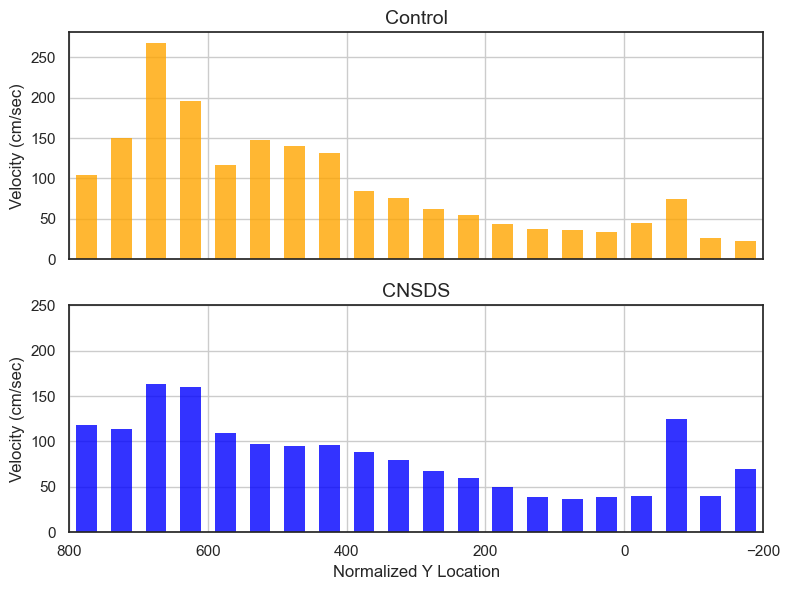

In [2934]:
# Step 1: Bin the normalized Y location into bins (adjust bin edges as needed)
bin_edges = range(-200, 850, 50)  # example bins every 50 units from -200 to 800
pts['y_bin'] = pd.cut(pts['normalized_y'], bins=bin_edges, labels=range(-175, 825, 50))

# Step 2: Calculate average velocity at each y_bin per condition
binned = (
    pts.groupby(['condition', 'y_bin'])
    .agg(avg_velocity_cm=('velocity_cm', 'mean'))
    .reset_index()
)

# Step 3: Prepare plot
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

colors = {'Control': 'orange', 'CNSDS': 'blue'}
conditions = ['Control', 'CNSDS']

for i, condition in enumerate(conditions):
    ax = axs[i]
    data = binned[binned['condition'] == condition].sort_values('y_bin')
    
    # Convert y_bin labels to floats for plotting on x-axis
    x_vals = data['y_bin'].astype(float)
    y_vals = data['avg_velocity_cm']

    ax.bar(
        x_vals,
        y_vals,
        width=30,
        color=colors[condition],
        alpha=0.8,
        edgecolor='none'
    )
    ax.set_ylabel('Velocity (cm/sec)', fontsize=12)
    ax.set_title(condition, fontsize=14)
    ax.grid(True)

# Shared x-axis label
axs[-1].set_xlabel('Normalized Y Location', fontsize=12)
axs[-1].set_xlim(800, -200)
ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("D:/Figures/velocity_by_y_location.pdf", format="pdf")
plt.show()


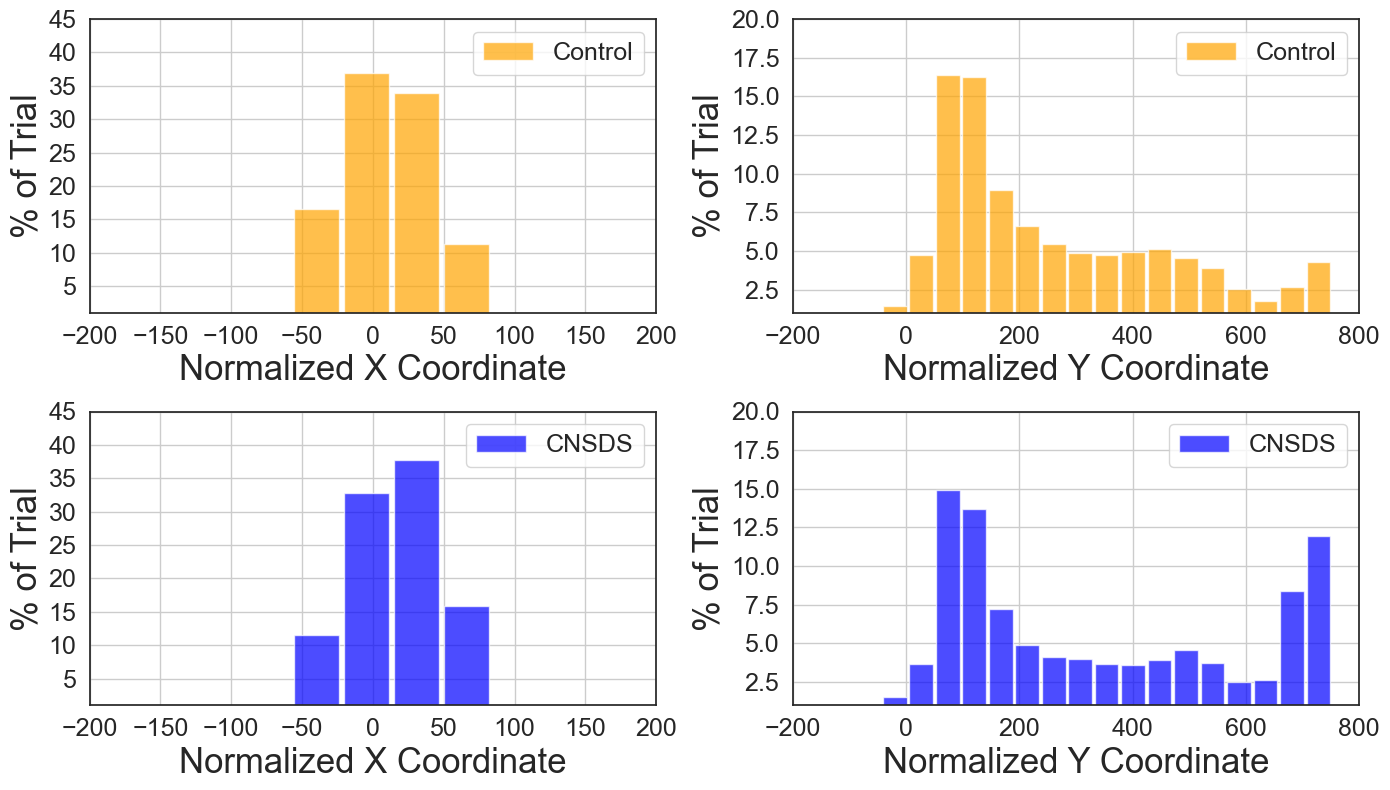

In [2935]:
# Get the range of values for both conditions
combined_data_x = pts['normalized_x'].dropna()
combined_data_y = pts['normalized_y'].dropna()

# Define the number of bins
bins = 30

# Calculate bin edges
bin_edges_x = np.linspace(combined_data_x.min(), combined_data_x.max(), bins+1)
bin_edges_y = np.linspace(combined_data_y.min(), combined_data_y.max(), bins+1)

# Create figure
plt.figure(figsize=(14, 8))

# Iterate through conditions
for i, condition in enumerate(conditions):
    # Filter data for current condition
    condition_data_x = pts[pts['condition'] == condition]['normalized_x'].dropna()
    condition_data_y = pts[pts['condition'] == condition]['normalized_y'].dropna()
    
    # Calculate weights for percentage
    weights_x = np.ones_like(condition_data_x) / len(condition_data_x) * 100
    weights_y = np.ones_like(condition_data_y) / len(condition_data_y) * 100

    # Histogram for normalized X
    plt.subplot(2, 2, i*2 + 1)
    plt.hist(condition_data_x, bins=bin_edges_x, weights=weights_x,
             alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange',
             histtype='bar', rwidth=0.9)
    plt.xlabel('Normalized X Coordinate', fontsize = 25)
    plt.ylabel('% of Trial', fontsize = 25)
    plt.xticks(fontsize=18)   # <-- tick font size
    plt.yticks(fontsize=18)   # <-- tick font size
    plt.ylim(1, 45)  # y-axis is percent
    plt.xlim(-200, 200)
    plt.grid(True)
    plt.legend([condition], loc='upper right', fontsize= 18)

    # Histogram for normalized Y
    plt.subplot(2, 2, i*2 + 2)
    plt.hist(condition_data_y, bins=bin_edges_y, weights=weights_y,
             alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange',
             histtype='bar', rwidth=0.9)
    plt.xlabel('Normalized Y Coordinate', fontsize = 25)
    plt.ylabel('% of Trial', fontsize = 25)
    plt.xticks(fontsize=18)   # <-- tick font size
    plt.yticks(fontsize=18)   # <-- tick font size
    plt.ylim(1, 20)  # y-axis is percent
    plt.xlim(-200, 800)
    plt.grid(True)
    plt.legend([condition], loc='upper right', fontsize= 18)

# Adjust layout
plt.tight_layout()
plt.savefig("location_histogram.pdf", format="pdf")  # Save it first
plt.show()  # Then show it


In [2936]:
# # Ensure consistent condition order
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# palette = {'Control': 'orange', 'CNSDS': 'blue'}

# # ---- 1. Calculate Welch's t-test stats and Bonferroni correction ---- #
# experiments = analysis_df['experiment'].unique()
# results = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment'] == exp]
#     control = subset[subset['condition'] == 'Control']['avg_velocity_cm']
#     cnsds = subset[subset['condition'] == 'CNSDS']['avg_velocity_cm']
    
#     n1, n2 = len(control), len(cnsds)
#     if n1 > 1 and n2 > 1:
#         # Welch's t-test
#         t_stat, p = ttest_ind(control, cnsds, equal_var=False)
        
#         # Degrees of freedom (Welch-Satterthwaite equation)
#         s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
#         df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

#         results.append({
#             'experiment': exp,
#             't_stat': t_stat,
#             'df': df,
#             'p_raw': p,
#             'n_control': n1,
#             'n_cnsds': n2,
#             'mean_control': np.mean(control),
#             'std_control': np.std(control, ddof=1),
#             'mean_cnsds': np.mean(cnsds),
#             'std_cnsds': np.std(cnsds, ddof=1),
#         })

# # Bonferroni correction
# p_raws = [r['p_raw'] for r in results]
# reject, corrected_pvals, _, _ = smm.multipletests(p_raws, method='bonferroni')

# # Append correction results
# for i, r in enumerate(results):
#     r['p_corrected'] = corrected_pvals[i]
#     r['significant'] = reject[i]

# # ---- 2. Plotting ---- #
# plt.figure(figsize=(6, 3))

# # Barplot with white fill and colored edge based on condition
# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_velocity_cm',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar=('se', 1),
#     dodge=True,
#     color='white',  # Fill color is white
#     edgecolor='gray',  # Default edge color for all bars
#     linewidth=2,
#     zorder=2
# )

# # Loop over each patch to apply edge color based on condition
# for patch in ax.patches:
#     condition = patch.get_label()  # Get the condition for this patch
#     if condition == 'Control':
#         patch.set_edgecolor('orange')  # Set Control condition edges to orange
#     elif condition == 'CNSDS':
#         patch.set_edgecolor('blue')  # Set CNSDS condition edges to blue

# # Overlay individual data points
# sns.stripplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_velocity_cm',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     marker='o',
#     alpha=0.6
# )

# # Clean up legend
# plt.legend([], [], frameon=False)  # Removes legend entirely

# plt.xticks(ticks=range(len(experiments)), labels=['10cm', '15cm', '20cm'])
# plt.ylabel("Velocity (cm/s)", fontsize=14)
# plt.xlabel("Barrier", fontsize=14)

# plt.tight_layout()
# plt.savefig("velocity.pdf", format="pdf")  # Save it first
# plt.show()  # Then show it



In [2937]:
# Drop the 'condition_x' column
#merged_df = merged_df.drop(columns=['condition_x'])

# Rename 'condition_y' to 'condition'
#merged_df = merged_df.rename(columns={'condition_y': 'condition'})

# Verify the changes
#print(merged_df.columns)

In [2938]:
# # 1. Handle NaN values in the 'velocity_cm_y' column
# # Drop rows with NaN values in the 'velocity_cm_y' column
# merged_df = merged_df.dropna(subset=['velocity_cm_y'])

# # 2. Group by 'barrier' and 'condition' to calculate the average velocity for each group
# average_velocity_by_condition = merged_df.groupby(['barrier', 'condition'])['velocity_cm_y'].mean().reset_index()

# # 3. Perform the ANOVA for each barrier and condition (CNSDS vs Control)
# anova_results = []

# # Iterate over unique barriers
# for barrier in merged_df['barrier'].unique():
#     # Filter the data for the current barrier
#     df_barrier = merged_df[merged_df['barrier'] == barrier]
    
#     # Check if both 'CNSDS' and 'Control' conditions exist for the current barrier
#     if 'CNSDS' in df_barrier['condition'].values and 'Control' in df_barrier['condition'].values:
#         # Perform ANOVA between CNSDS and Control conditions
#         cnsds_data = df_barrier[df_barrier['condition'] == 'CNSDS']['velocity_cm_y']
#         control_data = df_barrier[df_barrier['condition'] == 'Control']['velocity_cm_y']
        
#         # Perform the ANOVA
#         f_stat, p_value = stats.f_oneway(cnsds_data, control_data)
        
#         # Store the results
#         anova_results.append({
#             'barrier': barrier,
#             'F-statistic': f_stat,
#             'p-value': p_value
#         })
#     else:
#         print(f"Skipping barrier {barrier} due to missing CNSDS or Control data")

# # Convert results to a DataFrame
# anova_df = pd.DataFrame(anova_results)

# # Apply Bonferroni correction if any valid results exist
# if not anova_df.empty:
#     num_barriers = len(anova_df)
#     anova_df['p-value_bonferroni'] = anova_df['p-value'] * num_barriers

# # Print corrected p-values
# print(anova_df)

# # 4. Plot the bar graph with hollow bars and p-values if valid data exists
# if not anova_df.empty:
#     # Set the color palette (orange for Control and blue for CNSDS)
#     palette = {'Control': 'orange', 'CNSDS': 'blue'}

#     # Create the bar plot (hollow bars with error bars)
#     plt.figure(figsize=(10, 6))
#     sns.barplot(x='barrier', y='velocity_cm_y', hue='condition', data=merged_df, 
#                 palette=palette, ci="sd", capsize=0.1, linewidth=2, edgecolor='black', 
#                 estimator=np.mean)

#     # Plot individual data points above the bars with hollow circles
#     sns.stripplot(x='barrier', y='velocity_cm_y', data=merged_df, 
#                   hue='condition', palette=palette, marker='o', linewidth=2, alpha=0.7, 
#                   dodge=True, jitter=True, edgecolor='black', facecolor='none', color = 'none', size=2, zorder=1)

#     # Add significance annotations (e.g., p-values from ANOVA with Bonferroni correction)
#     for i, barrier in enumerate(anova_df['barrier']):
#         p_value_bonferroni = anova_df.loc[anova_df['barrier'] == barrier, 'p-value_bonferroni'].values[0]
        
#         # Place p-values above the bars (adjusted y-position)
#         plt.text(x=i, y=max(merged_df['velocity_cm_y']) + 0.2,  # Move p-value above the bars
#                  s=f"p = {p_value_bonferroni:.3f}", ha='center', fontsize=10, color='black')

#     # Set labels and title
#     plt.xlabel('Barrier', fontsize=12)
#     plt.ylabel('Velocity (cm/s)', fontsize=12)
#     plt.title('Velocity', fontsize=14)

#     # Remove the data points from the legend and only keep the bars in the legend
#     handles, labels = plt.gca().get_legend_handles_labels()
#     # Keep only the bars in the legend
#     plt.legend(handles=[handles[0], handles[1]], labels=['Control', 'CNSDS'], title='Condition', loc='upper left')

#     # Show the plot
#     plt.tight_layout()
#     plt.show()

# else:
#     print("No valid results to plot.")

# Locations scatterplot

In [2939]:
#merged_df = merged_df.dropna(subset=['barrier'])


In [2940]:
summary_df_copy=summary_df

In [2941]:
pts_copy=pts

In [2942]:
# Deduplicate summary_df_copy to ensure one row per subject
summary_unique = summary_df_copy[['subject', 'HR_Arm']].drop_duplicates(subset='subject')

# Merge without duplicating pts_copy
pts = pts_copy.copy()
pts['HR_Arm'] = pts['subject'].map(summary_unique.set_index('subject')['HR_Arm'])


In [2943]:
pts

Maze_Center_x  Maze_Center_y  Maze_Center_likelihood      Nose_x  \
0         701.324158     213.887344                0.979254  704.588867   
1         701.326416     214.029877                0.977822  704.711670   
2         701.401733     214.173889                0.977686  704.779297   
3         701.326416     214.173889                0.980646  704.779297   
4         701.326416     214.173889                0.979866  704.779297   
...              ...            ...                     ...         ...   
49642     650.524902     218.320801                0.252625  766.139282   
49643     649.895752     218.310303                0.177964  766.332825   
49644     648.064758     218.310303                0.260166  766.204163   
49645     647.887634     218.310303                0.292434  766.139282   
49646     640.449585     217.912811                0.091783  765.955566   

           Nose_y  Nose_likelihood  Right_Ear_x  Right_Ear_y  \
0      732.099976         0.983530   722.632324   756.030640   
1      732.099976         0.984463   722.884888   756.030640   
2      732.099976         0.990444   724.357849   756.030640   
3      717.377258         0.997883   724.449707   744.604004   
4      701.130859         0.998654   727.348816   733.282166   
...           ...              ...          ...          ...   
49642  174.005722         0.224144   747.425659   231.784012   
49643  174.005722         0.256961   747.425659   231.784012   
49644  173.642303         0.150704   744.415649   251.195892   
49645  173.642303         0.139457   681.706970   251.195892   
49646  173.642303         0.043701   681.706970   191.653519   

       Right_Ear_likelihood  Left_Ear_x  ...    experiment  subject  \
0                  0.766178  695.441406  ...  10cm_Barrier    WT027   
1                  0.782985  695.441406  ...  10cm_Barrier    WT027   
2                  0.728338  695.441406  ...  10cm_Barrier    WT027   
3                  0.858335  690.815979  ...  10cm_Barrier    WT027   
4                  0.862403  688.795410  ...  10cm_Barrier    WT027   
...                     ...         ...  ...           ...      ...   
49642              0.039013  741.720520  ...  20cm_Barrier    WT061   
49643              0.024818  741.720520  ...  20cm_Barrier    WT061   
49644              0.033707  735.363586  ...  20cm_Barrier    WT061   
49645              0.021320  734.086670  ...  20cm_Barrier    WT061   
49646              0.013165  733.802917  ...  20cm_Barrier    WT061   

       condition       avg_x       avg_y  velocity_cm  normalized_x  \
0        Control  726.246162  840.950897          NaN     24.922005   
1        Control  718.740102  841.778361    24.871797     17.413686   
2        Control  724.582947  824.719833    59.388462     23.181213   
3        Control  710.045364  780.849808   152.217514      8.718948   
4        Control  706.974508  725.833801   181.483290      5.648092   
...          ...         ...         ...          ...           ...   
49642    Control  665.959874  303.630896    86.370412     15.434971   
49643    Control  681.483383  286.666727    75.736000     31.587631   
49644    Control  688.887950  275.503026    44.121560     40.823191   
49645    Control  696.809418  272.257019    28.195724     48.921783   
49646    Control  687.675629  290.860100    68.258075     47.226044   

       normalized_y  y_bin  HR_Arm  
0        627.063553    625    left  
1        627.748484    625    left  
2        610.545944    625    left  
3        566.675919    575    left  
4        511.659912    525    left  
...             ...    ...     ...  
49642     85.310096     75   right  
49643     68.356424     75   right  
49644     57.192724     75   right  
49645     53.946716     75   right  
49646     72.947289     75   right  

[49647 rows x 50 columns]

## get an example image frame from a video for plotting

True
Index(['Maze_Center x', 'Maze_Center y', 'Maze_Center likelihood', 'Nose x',
       'Nose y', 'Nose likelihood', 'Right_Ear x', 'Right_Ear y',
       'Right_Ear likelihood', 'Left_Ear x', 'Left_Ear y',
       'Left_Ear likelihood', 'Middle_Neck x', 'Middle_Neck y',
       'Middle_Neck likelihood', 'Middle_Spine x', 'Middle_Spine y',
       'Middle_Spine likelihood', 'Tail_Base x', 'Tail_Base y',
       'Tail_Base likelihood', 'Tail_Mid x', 'Tail_Mid y',
       'Tail_Mid likelihood', 'Tail_End x', 'Tail_End y',
       'Tail_End likelihood', 'Front_Left_Leg x', 'Front_Left_Leg y',
       'Front_Left_Leg likelihood', 'Front_Right_Leg x', 'Front_Right_Leg y',
       'Front_Right_Leg likelihood', 'Back_Left_Leg x', 'Back_Left_Leg y',
       'Back_Left_Leg likelihood', 'Back_Right_Leg x', 'Back_Right_Leg y',
       'Back_Right_Leg likelihood'],
      dtype='object')


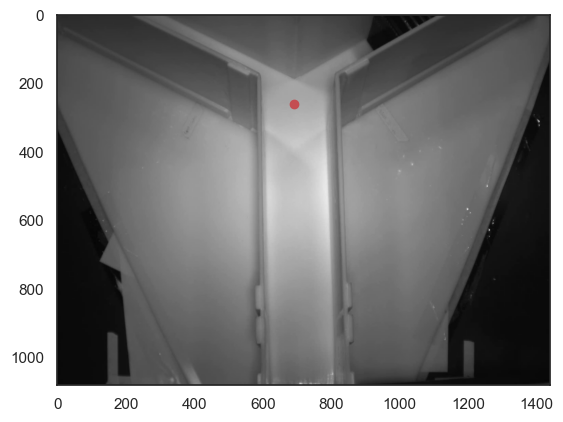

In [2944]:
vid_pic_file = r'C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\05052024\WT045\050524_Barrier_Testing_10cm_Day_1_WT045FCNSDS_StartArm_3.avi'
vid = cv2.VideoCapture(vid_pic_file)
vid.set(cv2.CAP_PROP_POS_FRAMES,170)
ret, frame = vid.read()
print(ret)

vid.release()

plt.imshow(frame)

vid_dlc_file = r'C:\Users\Jillian.Sucher\Documents\Stress_microstructure_testing_day_1\05052024\WT045\050524_Barrier_Testing_10cm_Day_1_WT045FCNSDS_StartArm_3DLC_resnet50_Effort_Related_Choice_2Jul30shuffle1_100000_filtered.h5'
dlc_df = pd.read_hdf(vid_dlc_file)
dlc_df.columns = [' '.join(col[:][1:3]).strip() for col in dlc_df.columns.values]
print(dlc_df.keys())
low_like = dlc_df['Maze_Center likelihood']<0.9
x = dlc_df['Maze_Center x']
x[low_like]=np.nan
x_pic = int(np.nanmean(x))
y = dlc_df['Maze_Center y']
y[low_like]=np.nan
y_pic = int(np.nanmean(y))
plt.plot(x_pic,y_pic,'ro')

# plt.figure()
# frame_2 = np.roll(a=frame,shift=-x_pic,axis=0)
# frame_2 = np.roll(a=frame_2,shift=-y_pic,axis=1)
# plt.imshow(frame_2)

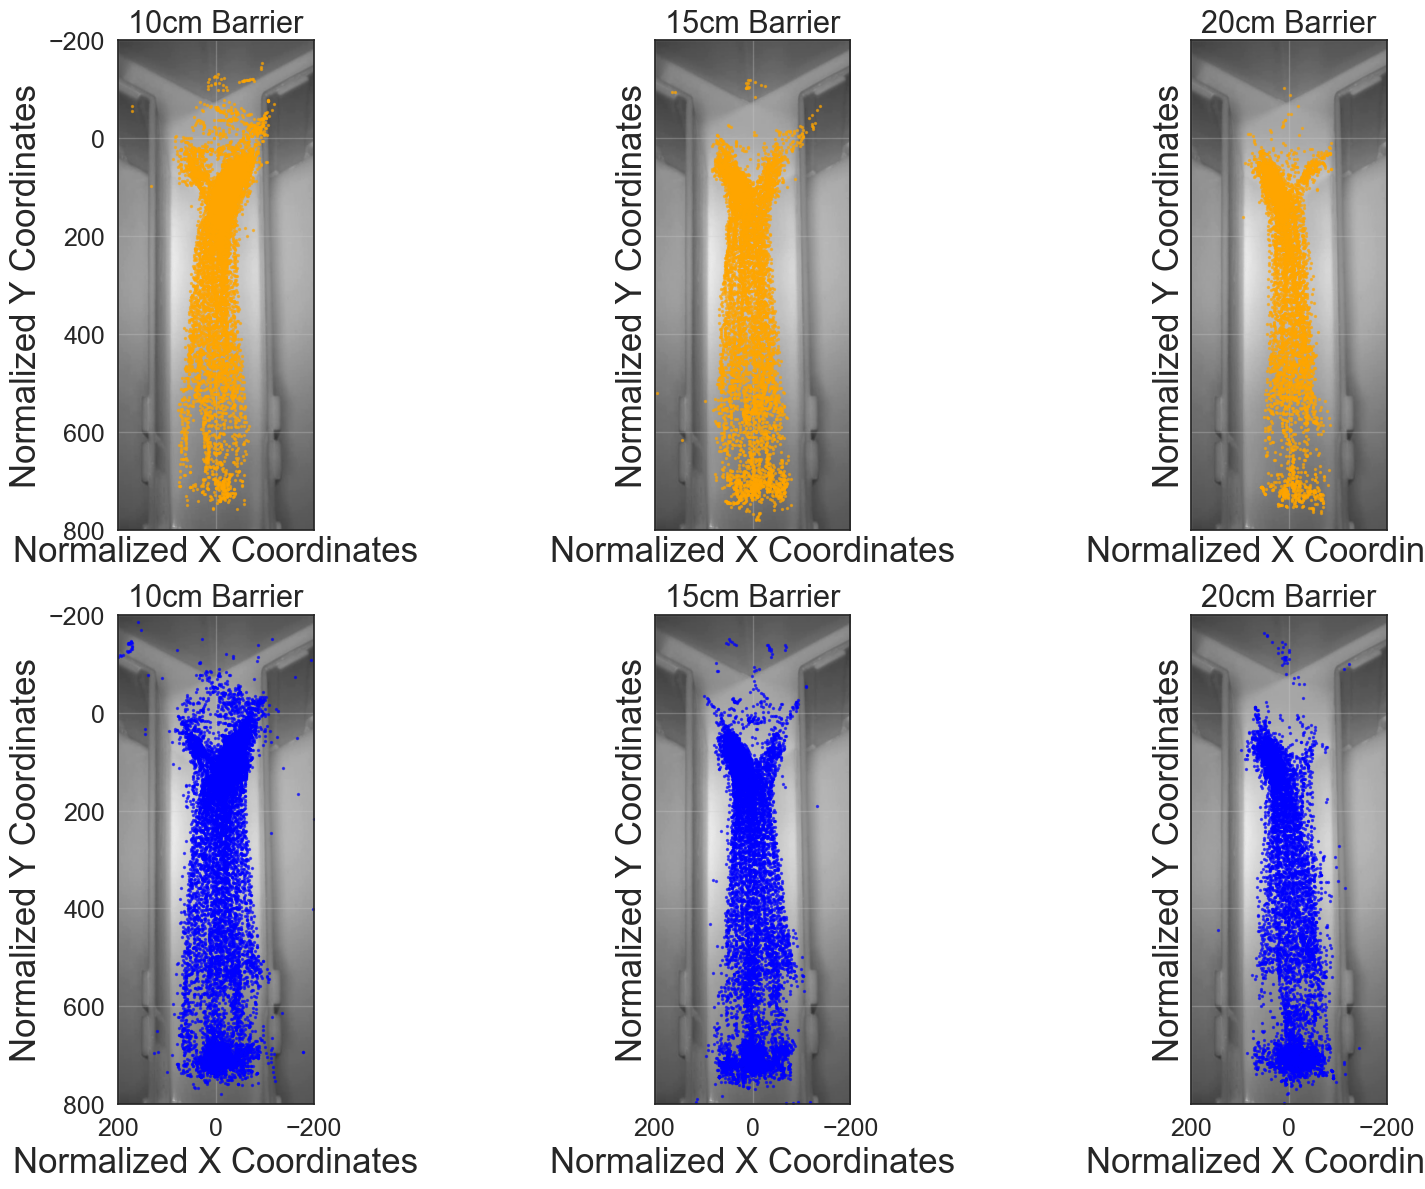

In [2945]:
# Get unique conditions and experiments
conditions = ['Control', 'CNSDS']
barrier = pts['experiment'].unique()

# Create a figure with subplots for each condition and experiment
fig, axes = plt.subplots(len(conditions), len(barrier), figsize=(18, 12), sharex=True, sharey=True)

# Always treat axes as a 2D array
if len(conditions) == 1:
    axes = axes[np.newaxis, :]
if len(barrier) == 1:
    axes = axes[:, np.newaxis]

# Iterate over the conditions and experiments
for row, condition in enumerate(conditions):
    for col, experiment in enumerate(barrier):

        ax = axes[row,col]
        # Filter data for the current condition and experiment
        condition_experiment_data = pts[
            (pts['condition'] == condition) &
            (pts['experiment'] == experiment)
        ].copy()

        # Reflect x-coordinates if HR_Arm is 'right'
        condition_experiment_data.loc[
            condition_experiment_data['HR_Arm'].str.lower() == 'right', 'normalized_x'
        ] *= -1

        # Set color
        color = 'blue' if condition == 'CNSDS' else 'orange'

        # plot image
        height, width, chan = frame.shape
        extent = [-x_pic, width - x_pic, height - y_pic, -y_pic]
        # Rotation angle in degrees
        angle = 2  # counter-clockwise
        # Create transform
        transform = Affine2D().rotate_deg_around(0, 0, angle) + ax.transData
        ax.imshow(frame, extent=extent, origin='upper', transform=transform)
        
        # Scatter plot
        ax.scatter(
            condition_experiment_data['normalized_x'],
            condition_experiment_data['normalized_y'],
            alpha=0.6, marker='o', color=color, s=2, label=condition
        )

        # Title by barrier height
        if col == 0:
            title = '10cm Barrier'
        elif col == 1:
            title = '15cm Barrier'
        else:
            title = '20cm Barrier'

        # Axis labels, titles, and formatting
        ax.set_title(title, fontsize=22)
        ax.set_xlabel('Normalized X Coordinates', fontsize=25)
        ax.set_ylabel('Normalized Y Coordinates', fontsize=25)
        ax.set_xlim(200, -200)
        ax.set_ylim(800, -200)
        ax.tick_params(axis='both', labelsize=18)
        ax.grid(True, alpha=0.3)
        # ax.axis('square')
        # ax.legend(loc='upper right', fontsize=22, markerscale=8)

# Final layout and export
plt.tight_layout()
plt.savefig("location_scatterplot.pdf", format="pdf")
plt.show()


In [2946]:
# # Get the range of values for both conditions
# combined_data_x = pts['normalized_x'].dropna()
# combined_data_y = pts['normalized_y'].dropna()

# # Define the number of bins (e.g., 30)
# bins = 30

# # Calculate the bin edges using numpy
# bin_edges_x = np.linspace(combined_data_x.min(), combined_data_x.max(), bins+1)
# bin_edges_y = np.linspace(combined_data_y.min(), combined_data_y.max(), bins+1)

# # Create a figure for the histograms
# plt.figure(figsize=(14, 8))

# # Iterate over the conditions to plot histograms with the same bin edges
# for i, condition in enumerate(conditions):
#     # Filter data for the current condition
#     condition_data_x = pts[pts['condition'] == condition]['normalized_x'].dropna()
#     condition_data_y = pts[pts['condition'] == condition]['normalized_y'].dropna()
    
#     # Create subplot for normalized_x
#     plt.subplot(2, 2, i*2 + 1)
#     plt.hist(condition_data_x, bins=bin_edges_x, alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange', 
#              histtype='bar', rwidth=0.9)  # Add some space between bars
#     plt.title(f'Histogram of Normalized X Coordinates')
#     plt.xlabel('Normalized X Coordinate')
#     plt.ylabel('Frequency')
#     plt.ylim(0, 12000)
#     plt.xlim(200, -200)
#     plt.grid(True)  # Add grid lines
#     # Add a legend
#     plt.legend([condition], loc='upper right')
    
#     # Create subplot for normalized_y
#     plt.subplot(2, 2, i*2 + 2)
#     plt.hist(condition_data_y, bins=bin_edges_y, alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange', 
#             histtype='bar', rwidth=0.9)  # Add some space between bars)
#     plt.title(f'Histogram of Normalized Y Coordinates')
#     plt.xlabel('Normalized Y Coordinate')
#     plt.ylabel('Frequency')
#     plt.ylim(0, 4500)
#     plt.xlim(800, -200)
#     plt.grid(True)  # Add grid lines
#     # Add a legend
#     plt.legend([condition], loc='upper right')

# # Adjust layout for clarity
# plt.tight_layout()

# # Show the plots
# plt.show()


In [2947]:
pts

Maze_Center_x  Maze_Center_y  Maze_Center_likelihood      Nose_x  \
0         701.324158     213.887344                0.979254  704.588867   
1         701.326416     214.029877                0.977822  704.711670   
2         701.401733     214.173889                0.977686  704.779297   
3         701.326416     214.173889                0.980646  704.779297   
4         701.326416     214.173889                0.979866  704.779297   
...              ...            ...                     ...         ...   
49642     650.524902     218.320801                0.252625  766.139282   
49643     649.895752     218.310303                0.177964  766.332825   
49644     648.064758     218.310303                0.260166  766.204163   
49645     647.887634     218.310303                0.292434  766.139282   
49646     640.449585     217.912811                0.091783  765.955566   

           Nose_y  Nose_likelihood  Right_Ear_x  Right_Ear_y  \
0      732.099976         0.983530   722.632324   756.030640   
1      732.099976         0.984463   722.884888   756.030640   
2      732.099976         0.990444   724.357849   756.030640   
3      717.377258         0.997883   724.449707   744.604004   
4      701.130859         0.998654   727.348816   733.282166   
...           ...              ...          ...          ...   
49642  174.005722         0.224144   747.425659   231.784012   
49643  174.005722         0.256961   747.425659   231.784012   
49644  173.642303         0.150704   744.415649   251.195892   
49645  173.642303         0.139457   681.706970   251.195892   
49646  173.642303         0.043701   681.706970   191.653519   

       Right_Ear_likelihood  Left_Ear_x  ...    experiment  subject  \
0                  0.766178  695.441406  ...  10cm_Barrier    WT027   
1                  0.782985  695.441406  ...  10cm_Barrier    WT027   
2                  0.728338  695.441406  ...  10cm_Barrier    WT027   
3                  0.858335  690.815979  ...  10cm_Barrier    WT027   
4                  0.862403  688.795410  ...  10cm_Barrier    WT027   
...                     ...         ...  ...           ...      ...   
49642              0.039013  741.720520  ...  20cm_Barrier    WT061   
49643              0.024818  741.720520  ...  20cm_Barrier    WT061   
49644              0.033707  735.363586  ...  20cm_Barrier    WT061   
49645              0.021320  734.086670  ...  20cm_Barrier    WT061   
49646              0.013165  733.802917  ...  20cm_Barrier    WT061   

       condition       avg_x       avg_y  velocity_cm  normalized_x  \
0        Control  726.246162  840.950897          NaN     24.922005   
1        Control  718.740102  841.778361    24.871797     17.413686   
2        Control  724.582947  824.719833    59.388462     23.181213   
3        Control  710.045364  780.849808   152.217514      8.718948   
4        Control  706.974508  725.833801   181.483290      5.648092   
...          ...         ...         ...          ...           ...   
49642    Control  665.959874  303.630896    86.370412     15.434971   
49643    Control  681.483383  286.666727    75.736000     31.587631   
49644    Control  688.887950  275.503026    44.121560     40.823191   
49645    Control  696.809418  272.257019    28.195724     48.921783   
49646    Control  687.675629  290.860100    68.258075     47.226044   

       normalized_y  y_bin  HR_Arm  
0        627.063553    625    left  
1        627.748484    625    left  
2        610.545944    625    left  
3        566.675919    575    left  
4        511.659912    525    left  
...             ...    ...     ...  
49642     85.310096     75   right  
49643     68.356424     75   right  
49644     57.192724     75   right  
49645     53.946716     75   right  
49646     72.947289     75   right  

[49647 rows x 50 columns]

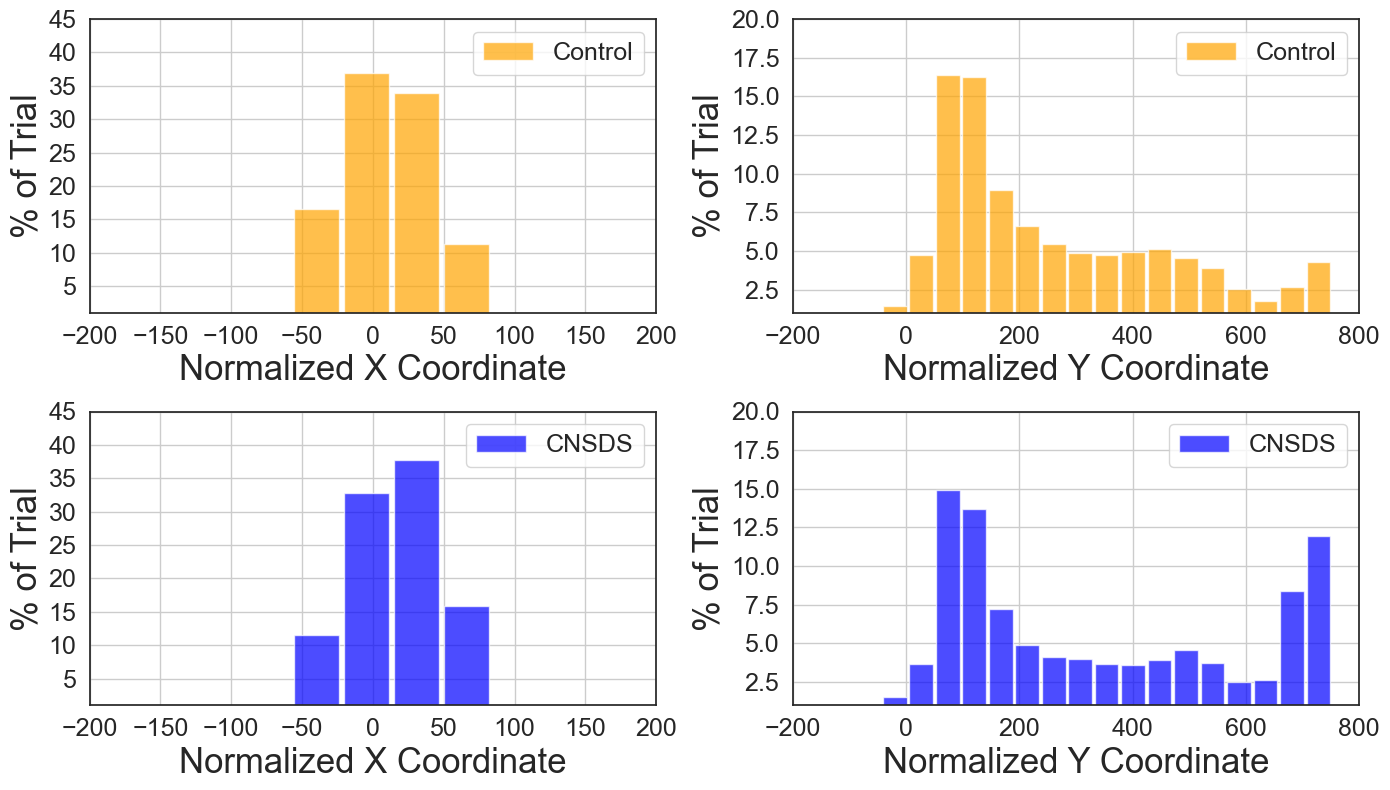

In [2948]:
# Get the range of values for both conditions
combined_data_x = pts['normalized_x'].dropna()
combined_data_y = pts['normalized_y'].dropna()

# Define the number of bins
bins = 30

# Calculate bin edges
bin_edges_x = np.linspace(combined_data_x.min(), combined_data_x.max(), bins+1)
bin_edges_y = np.linspace(combined_data_y.min(), combined_data_y.max(), bins+1)

# Create figure
plt.figure(figsize=(14, 8))

# Iterate through conditions
for i, condition in enumerate(conditions):
    # Filter data for current condition
    condition_data_x = pts[pts['condition'] == condition]['normalized_x'].dropna()
    condition_data_y = pts[pts['condition'] == condition]['normalized_y'].dropna()
    
    # Calculate weights for percentage
    weights_x = np.ones_like(condition_data_x) / len(condition_data_x) * 100
    weights_y = np.ones_like(condition_data_y) / len(condition_data_y) * 100

    # Histogram for normalized X
    plt.subplot(2, 2, i*2 + 1)
    plt.hist(condition_data_x, bins=bin_edges_x, weights=weights_x,
             alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange',
             histtype='bar', rwidth=0.9)
    plt.xlabel('Normalized X Coordinate', fontsize = 25)
    plt.ylabel('% of Trial', fontsize = 25)
    plt.xticks(fontsize=18)   # <-- tick font size
    plt.yticks(fontsize=18)   # <-- tick font size
    plt.ylim(1, 45)  # y-axis is percent
    plt.xlim(-200, 200)
    plt.grid(True)
    plt.legend([condition], loc='upper right', fontsize= 18)

    # Histogram for normalized Y
    plt.subplot(2, 2, i*2 + 2)
    plt.hist(condition_data_y, bins=bin_edges_y, weights=weights_y,
             alpha=0.7, color='blue' if condition == 'CNSDS' else 'orange',
             histtype='bar', rwidth=0.9)
    plt.xlabel('Normalized Y Coordinate', fontsize = 25)
    plt.ylabel('% of Trial', fontsize = 25)
    plt.xticks(fontsize=18)   # <-- tick font size
    plt.yticks(fontsize=18)   # <-- tick font size
    plt.ylim(1, 20)  # y-axis is percent
    plt.xlim(-200, 800)
    plt.grid(True)
    plt.legend([condition], loc='upper right', fontsize= 18)

# Adjust layout
plt.tight_layout()
plt.savefig("location_histogram.pdf", format="pdf")  # Save it first
plt.show()  # Then show it


# Time Spent in Start Box

In [2949]:
pts['experiment'] = pts['experiment'].str.replace('_Barrier', '', regex=False)


In [2950]:
# 1. Count total frames per experiment, subject, and trial
total_frames_per_trial = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .size()
    .reset_index(name='total_frames')
)

# 2. Filter frames in the start box
start_box_df = pts[(pts['normalized_y'] >= 600) & (pts['normalized_y'] <= 800)]

# 3. Count start box frames per experiment, subject, and trial
start_box_frames_per_trial = (
    start_box_df.groupby(['experiment', 'subject', 'trial'])
    .size()
    .reset_index(name='start_box_frames')
)

# 4. Merge frame counts
merged = pd.merge(
    total_frames_per_trial,
    start_box_frames_per_trial,
    on=['experiment', 'subject', 'trial'],
    how='left'
)
merged['start_box_frames'] = merged['start_box_frames'].fillna(0)

# 5. Compute proportion and drop NaNs
merged['start_box_proportion'] = merged['start_box_frames'] / merged['total_frames']
merged = merged.dropna(subset=['start_box_proportion'])

# 6. Average per subject and experiment
avg_start_box_time = (
    merged.groupby(['experiment', 'subject'])['start_box_proportion']
    .mean()
    .reset_index(name='avg_start_box_time')
)

# 7. Merge into analysis_df
analysis_df = analysis_df.merge(
    avg_start_box_time,
    on=['experiment', 'subject'],
    how='left'
)


In [2951]:
analysis_df

experiment subject  HR_percentage   date condition sex  choice  \
0        10cm   WT022            0.9  31524     CNSDS   M       9   
1        10cm   WT023            0.3  31524     CNSDS   M       3   
2        10cm   WT025            1.0  31524     CNSDS   M      10   
3        10cm   WT027            0.3  31524   Control   M       3   
4        10cm   WT028            0.2  31524   Control   M       2   
..        ...     ...            ...    ...       ...  ..     ...   
83       20cm   WT056            0.4  70224     CNSDS   F       4   
84       20cm   WT057            0.0  70224     CNSDS   F       0   
85       20cm   WT058            0.0  70224     CNSDS   F       0   
86       20cm   WT060            0.0  70224   Control   F       0   
87       20cm   WT061            0.9  70224   Control   F       9   

    total_trials  HR_ratio    cohort  avg_trial_duration  avg_velocity_cm  \
0             10       0.9  Cohort 1            0.780130        98.657063   
1             10       0.3  Cohort 1            1.341890        62.162393   
2             10       1.0  Cohort 1            1.525254        69.658469   
3             10       0.3  Cohort 1            1.271879        48.631696   
4             10       0.2  Cohort 1            0.845141        67.194860   
..           ...       ...       ...                 ...              ...   
83            10       0.4  Cohort 3            0.870145        93.066073   
84            11       0.0  Cohort 3            1.036536        70.011557   
85             9       0.0  Cohort 3            0.927932        83.139868   
86            10       0.0  Cohort 3            0.828471        89.676999   
87            10       0.9  Cohort 3            0.976829        88.660359   

    avg_start_box_time  
0             0.116886  
1             0.152760  
2             0.154288  
3             0.107290  
4             0.018315  
..                 ...  
83            0.236537  
84            0.264004  
85            0.228879  
86            0.113322  
87            0.223781  

[88 rows x 13 columns]

In [2952]:
# # 1. Filter rows in the start box (based on normalized_y)
# start_box_df = pts[(pts['normalized_y'] >= 600) & (pts['normalized_y'] <= 800)]

# # 2. Count rows per experiment, subject, and trial
# start_box_counts = start_box_df.groupby(['experiment', 'subject', 'trial']).size().reset_index(name='frame_count')

# # 3. Convert frame counts to time in seconds
# start_box_counts['start_box_time_secs'] = start_box_counts['frame_count'] / 60  # 60 frames/sec

# # 4. Average per experiment and subject
# avg_start_box_time = start_box_counts.groupby(['experiment', 'subject'])['start_box_time_secs'].mean().reset_index()
# avg_start_box_time.rename(columns={'start_box_time_secs': 'avg_start_box_time_secs'}, inplace=True)

# # 5. Merge into analysis_df
# analysis_df = analysis_df.merge(
#     avg_start_box_time,
#     left_on=['experiment', 'subject'],
#     right_on=['experiment', 'subject'],
#     how='left'
# )

In [2953]:
# # Drop old column
# analysis_df.drop(columns=['avg_start_box_time_secs_x'], inplace=True)

# # Rename new column
# analysis_df.rename(columns={'avg_start_box_time_secs_y': 'avg_start_box_time_secs'}, inplace=True)


In [2954]:
# Step 1: Filter rows where normalized_y is between 600 and 800
#start_box_df = pts[(pts['normalized_y'] >= 600) & (pts['normalized_y'] <= 800)]

# Step 2: Calculate start_box_time in seconds for each frame (60 frames per second)
#start_box_df['start_box_time_seconds'] = 1 / 60  # Each row corresponds to 1/60 seconds

In [2955]:
# Step 3: Group by 'barrier', 'trial', and 'subject', and sum the time spent in the start box
#start_box_time_summary = start_box_df.groupby(['barrier', 'trial', 'subject']).agg({
#    'start_box_time_seconds': 'sum'
#}).reset_index()

# Step 4: Append the calculated start_box_time to summary_df by merging on 'barrier', 'trial', and 'subject'
#analysis_df = pd.merge(analysis_df, start_box_time_summary, on=['barrier', 'trial', 'subject'], how='left')

# Print the resulting summary_df to confirm
#print(analysis_df.head())

In [2956]:
# # Step 1: Clean the data by dropping NaNs in the relevant columns
# #summary_df_clean = summary_df.dropna(subset=['start_box_time_seconds', 'barrier', 'condition'])

# # Step 2: Ensure 'condition' is ordered with 'Control' first
# summary_df_clean['condition'] = pd.Categorical(summary_df_clean['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # Step 3: Check the number of data points per group and inspect the data
# for barrier in summary_df_clean['barrier'].unique():
#     # Filter data for this barrier
#     barrier_data = summary_df_clean[summary_df_clean['barrier'] == barrier]
    
#     # Get the Control and CNSDS data for the current barrier
#     control_data = barrier_data[barrier_data['condition'] == 'Control']['start_box_time_seconds']
#     cnsds_data = barrier_data[barrier_data['condition'] == 'CNSDS']['start_box_time_seconds']
    
#     # Print the sizes and unique values for debugging
#     print(f"Barrier: {barrier}")
#     print(f"Control group size: {len(control_data)}")
#     print(f"CNSDS group size: {len(cnsds_data)}")
#     print(f"Control unique values: {control_data.unique()}")
#     print(f"CNSDS unique values: {cnsds_data.unique()}")

# # Step 4: Calculate p-values for each barrier using ANOVA (with Bonferroni correction)
# p_values = []
# for barrier in summary_df_clean['barrier'].unique():
#     # Filter data for this barrier
#     barrier_data = summary_df_clean[summary_df_clean['barrier'] == barrier]
    
#     # Get the Control and CNSDS data for the current barrier
#     control_data = barrier_data[barrier_data['condition'] == 'Control']['start_box_time_seconds']
#     cnsds_data = barrier_data[barrier_data['condition'] == 'CNSDS']['start_box_time_seconds']
    
#     # Ensure that both groups have more than one data point for ANOVA
#     if len(control_data) > 1 and len(cnsds_data) > 1:
#         # Perform ANOVA
#         f_val, p_val = stats.f_oneway(control_data, cnsds_data)
#     else:
#         p_val = np.nan  # If any group is missing or has only 1 data point, set p-value to NaN
    
#     p_values.append(p_val)

# # Step 5: Apply Bonferroni correction to p-values (assuming 3 barriers)
# bonferroni_p_values = [min(p * 3, 1.0) for p in p_values]  # Adjust for 3 comparisons

# # Debug: Print the p-values to check
# print("P-values:", p_values)
# print("Bonferroni-corrected P-values:", bonferroni_p_values)

# # Step 6: Create a bar plot with error bars for time in start box
# plt.figure(figsize=(12, 8))

# # Create the barplot
# sns.barplot(x='barrier', y='start_box_time_seconds', hue='condition', data=summary_df_clean, 
#             palette={'Control': 'orange', 'CNSDS': 'blue'}, errorbar='sd', capsize=0.1)

# # Overlay individual data points on the bars
# sns.stripplot(x='barrier', y='start_box_time_seconds', hue='condition', data=summary_df_clean, 
#               dodge=True, jitter=True, palette={'Control': 'orange', 'CNSDS': 'blue'}, 
#               marker='o', size=5, alpha=0.6, edgecolor='black')

# # Step 7: Add p-values to the bars
# for i, barrier in enumerate(summary_df_clean['barrier'].unique()):
#     # Get the p-value for the current barrier
#     p_val = bonferroni_p_values[i]
    
#     # Only add the p-value text if it's not NaN
#     if not np.isnan(p_val):
#         # Get the height of the bars for the current barrier and condition
#         control_height = summary_df_clean[(summary_df_clean['barrier'] == barrier) & (summary_df_clean['condition'] == 'Control')]['start_box_time_seconds'].max()
#         cnsds_height = summary_df_clean[(summary_df_clean['barrier'] == barrier) & (summary_df_clean['condition'] == 'CNSDS')]['start_box_time_seconds'].max()
        
#         # Determine the position for the p-value text
#         x_position = i  # Position on the x-axis (barrier index)
        
#         # Plot the p-value above the bars
#         plt.text(x_position - 0.1, max(control_height, cnsds_height) - 1.0, 
#                  f'p = {p_val:.3f}', ha='center', va='bottom', fontsize=10, color='black')

# # Step 8: Add labels and title
# plt.xlabel('Barrier')
# plt.ylabel('Time Spent in Start Box (Seconds)')
# plt.title('Time Spent in Start Box')

# # Step 9: Customize the legend to only include bars, not data points
# handles, labels = plt.gca().get_legend_handles_labels()

# # Filter out the handles for the scatter plot (data points)
# handles = [handle for handle, label in zip(handles, labels) if label in ['Control', 'CNSDS']]

# # Update the legend to only include bars
# plt.legend(handles=handles, title='Condition')

# plt.tight_layout()

# # Show the plot
# plt.show()

In [2957]:
# plot_df = analysis_df.dropna(subset=['avg_start_box_time_secs', 'experiment', 'condition', 'subject'])

In [2958]:
# Step 1: Compute average trial duration (in frames) per subject
avg_total_frames = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .size()
    .groupby(['experiment', 'subject'])
    .mean()
    .reset_index(name='avg_total_frames')
)

# Step 2: Merge with analysis_df
analysis_df = analysis_df.merge(
    avg_total_frames,
    on=['experiment', 'subject'],
    how='left'
)

# Step 3: Convert avg_start_box_time (proportion) to seconds
# avg_start_box_time_secs = proportion × avg_total_frames ÷ 60
analysis_df['avg_start_box_time_secs'] = (
    analysis_df['avg_start_box_time'] * analysis_df['avg_total_frames'] / 60
)


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\514935725.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df.groupby(['experiment', 'condition'])['avg_start_box_time_secs']


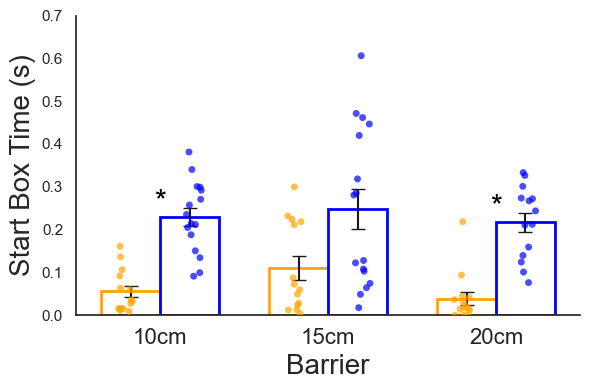

In [2959]:
# Ensure consistent condition order
analysis_df['condition'] = pd.Categorical(
    analysis_df['condition'],
    categories=['Control', 'CNSDS'],  # Control on left
    ordered=True
)

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35
experiments = analysis_df['experiment'].unique()

plt.figure(figsize=(6, 4))

# 1. Compute means and SEMs for plotting
summary = (
    analysis_df.groupby(['experiment', 'condition'])['avg_start_box_time_secs']
    .agg(['mean', 'sem'])
    .reset_index()
)

# 2. Draw bars manually (white fill, colored edge)
for i, exp in enumerate(experiments):
    for cond in ['Control', 'CNSDS']:
        row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=5
            )

# 3. Overlay individual data points
sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='avg_start_box_time_secs',
    hue='condition',
    dodge=True,
    palette=palette,
    jitter=True,
    marker='o',
    alpha=0.7
)

# 4. Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')

# 5. Run t-tests and plot asterisks
p_values = []
exp_labels = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment'] == exp]
    control = subset[subset['condition'] == 'Control']['avg_start_box_time_secs']
    cnsds = subset[subset['condition'] == 'CNSDS']['avg_start_box_time_secs']
    if len(control) > 1 and len(cnsds) > 1:
        stat, p = ttest_ind(control, cnsds, equal_var=False)
        p_values.append(p)
        exp_labels.append(exp)

# Bonferroni correction
reject, corrected_pvals, _, _ = smm.multipletests(p_values, method='bonferroni')
pval_dict = dict(zip(exp_labels, zip(corrected_pvals, reject)))

# Prepare to track the highest point to set y-axis limit
asterisk_positions = []

for i, exp in enumerate(experiments):
    if exp in pval_dict:
        pval, significant = pval_dict[exp]
        if significant:
            y_bar = summary[(summary['experiment'] == exp)]['mean'].max()
            y_asterisk = y_bar + 0.0  # space above bar
            asterisk_positions.append(y_asterisk)
            plt.text(i, y_asterisk, '*', ha='center', va='bottom', fontsize=22, color='black')

# Set the y-limit high enough to show all asterisks
data_max = analysis_df['avg_start_box_time_secs'].max()
asterisk_max = max(asterisk_positions) if asterisk_positions else data_max
plt.ylim(0, 0.7)  # small extra space above


# Final formatting
plt.xticks(ticks=range(len(experiments)), labels=experiments, fontsize=16)
plt.ylabel('Start Box Time (s)', fontsize=20)
plt.xlabel('Barrier', fontsize=20)
sns.despine(top=True, right=True)
plt.legend().remove()

plt.tight_layout()
plt.savefig("startbox_time.pdf", format="pdf")  # Save it first
plt.show()  # Then show it



In [2960]:
# # 1. Count total frames per experiment and subject
# total_frames = pts.groupby(['experiment', 'subject']).size().reset_index(name='total_frames')

# # 2. Merge into analysis_df
# analysis_df = analysis_df.merge(
#     total_frames,
#     on=['experiment', 'subject'],
#     how='left'
# )

In [2961]:
# # ---- 0. Normalize start box time ---- #
# analysis_df['normalized_start_box_time'] = (
#     analysis_df['total_start_box_frames'] / analysis_df['total_frames']
# )

# # Drop rows with NaN in normalized_start_box_time
# analysis_df = analysis_df.dropna(subset=['normalized_start_box_time'])


In [2962]:
# # ---- 0. Normalize start box time ---- #
# analysis_df['normalized_start_box_time'] = (
#     analysis_df['total_start_box_frames'] / analysis_df['total_frames']
# )

# # Ensure consistent condition order
# analysis_df['condition'] = pd.Categorical(
#     analysis_df['condition'],
#     categories=['Control', 'CNSDS'],
#     ordered=True
# )

# # ---- 1. Run Welch's t-tests and store stats ---- #
# experiments = analysis_df['experiment'].unique()
# results = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment'] == exp]
#     control = subset[subset['condition'] == 'Control']['normalized_start_box_time']
#     cnsds = subset[subset['condition'] == 'CNSDS']['normalized_start_box_time']
    
#     n1, n2 = len(control), len(cnsds)
    
#     if n1 > 1 and n2 > 1:
#         # Welch's t-test
#         t_stat, p = ttest_ind(control, cnsds, equal_var=False)

#         # Welch-Satterthwaite degrees of freedom
#         s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
#         df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2 * (n1-1)) + (s2_sq**2)/(n2**2 * (n2-1)))

#     #     results.append({

#     # n1, n2 = len(control), len(cnsds)

#     # if n1 > 1 and n2 > 1:
#     #     # Welch's t-test
#     #     t_stat, p = ttest_ind(control, cnsds, equal_var=False)

#     #     # Welch-Satterthwaite degrees of freedom
#     #     s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
#     #     df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2 * (n1-1)) + (s2_sq**2)/(n2**2 * (n2-1)))

#         results.append({

#             'experiment': exp,
#             't_stat': t_stat,
#             'df': df,
#             'p_raw': p,
#             'n_control': n1,
#             'n_cnsds': n2,
#             'mean_control': np.mean(control),
#             'std_control': np.std(control, ddof=1),
#             'mean_cnsds': np.mean(cnsds),
#             'std_cnsds': np.std(cnsds, ddof=1)
#         })

# # ---- 2. Bonferroni correction ---- #
# p_vals = [r['p_raw'] for r in results]
# reject, corrected_pvals, _, _ = smm.multipletests(p_vals, method='bonferroni')

# for i, r in enumerate(results):
#     r['p_corrected'] = corrected_pvals[i]
#     r['significant'] = reject[i]

# # ---- 3. Plot ---- #
# plt.figure(figsize=(10, 6))

# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment',
#     y='normalized_start_box_time',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar=('se', 1),
#     dodge=True
# )

# sns.stripplot(
#     data=analysis_df,
#     x='experiment',
#     y='normalized_start_box_time',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     marker='o',
#     alpha=0.6
# )

# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title="Condition")

# plt.xticks(
#     ticks=range(len(analysis_df['experiment'].unique())),
#     labels=['10cm', '15cm', '20cm']
# )

# plt.ylabel("Time in Start Box (% of Trial)")
# plt.xlabel("Experiment")
# plt.ylim(0, 1.1)

# plt.tight_layout()
# plt.savefig("startbox_time.pdf", format="pdf")  # Save it first
# plt.show()  # Then show it

# # ---- 4. Print results in console ---- #
# for r in results:
#     print(
#         f"{r['experiment']}:\n"
#         f"  Control   -> mean = {r['mean_control']:.3f}, std = {r['std_control']:.3f}, n = {r['n_control']}\n"
#         f"  CNSDS     -> mean = {r['mean_cnsds']:.3f}, std = {r['std_cnsds']:.3f}, n = {r['n_cnsds']}\n"
#         f"  t = {r['t_stat']:.3f}, df = {r['df']:.1f}, "
#         f"p = {r['p_raw']:.4f}, corrected p = {r['p_corrected']:.4f}, "
#         f"significant = {r['significant']}\n"
#     )


In [2963]:
# # Ensure consistent condition order
# analysis_df['condition'] = pd.Categorical(analysis_df['condition'], categories=['Control', 'CNSDS'], ordered=True)

# # ---- 1. Run t-tests and Bonferroni correction ---- #
# experiments = analysis_df['experiment'].unique()
# p_values = []
# experiment_labels = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment'] == exp]
#     control = subset[subset['condition'] == 'Control']['avg_start_box_time_secs']
#     cnsds = subset[subset['condition'] == 'CNSDS']['avg_start_box_time_secs']
    
#     if len(control) > 1 and len(cnsds) > 1:
#         stat, p = ttest_ind(control, cnsds)
#         p_values.append(p)
#         experiment_labels.append(exp)
#     else:
#         p_values.append(None)
#         experiment_labels.append(exp)

# # Bonferroni correction
# valid_pvals = [p for p in p_values if p is not None]
# reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')

# # Map corrected p-values to experiments
# pval_results = {}
# idx = 0
# for exp, raw_p in zip(experiment_labels, p_values):
#     if raw_p is not None:
#         pval_results[exp] = (corrected_pvals[idx], reject[idx])
#         idx += 1

# # ---- 2. Plot ---- #
# plt.figure(figsize=(10, 6))

# # Bar plot
# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_start_box_time_secs',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar=('se', 1),
#     dodge=True
# )

# # Add individual data points
# sns.stripplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_start_box_time_secs',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     marker='o',
#     alpha=0.6
# )

# # Remove duplicate legend entries
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title="Condition")

# # # ---- 3. Annotate p-values ---- #
# # xticks = ax.get_xticks()
# # for i, exp in enumerate(experiments):
# #     if exp in pval_results:
# #         pval, significant = pval_results[exp]
# #         label = f"*  p = {pval:.3f}" if significant else f"p = {pval:.3f}"

# #         max_y = analysis_df[analysis_df['experiment'] == exp]['avg_start_box_time_secs'].max()
# #         y_pos = max_y + 0  # adjust if needed
# #         xpos = xticks[i]
# #         plt.text(xpos, y_pos, label, ha='center', va='bottom', fontsize=10, color='black')

# # ---- Final touches ---- #
# plt.title("Start Box Time")
# plt.ylabel("Avg Start Box Time (s)")
# plt.xlabel("Experiment")
# plt.tight_layout()
# plt.show()


In [2964]:
# # Define a custom color palette: orange for 'Control' and blue for 'CNSDS'
# palette = {'Control': 'orange', 'CNSDS': 'blue'}

# # Set up the figure
# plt.figure(figsize=(12, 6))

# # Plot the histogram for each condition with custom colors
# sns.histplot(data=analysis_df, x='avg_start_box_time_secs', hue='condition', kde=True, bins=30, palette=palette, multiple="stack")

# # Set the title and labels
# plt.title('Frequency Distribution of Start Box Time')
# plt.xlabel('Start Box Time (seconds)')
# plt.ylabel('Frequency')

# # Show the plot
# plt.tight_layout()
# plt.show()

# Total Distance Traveled

In [2965]:
# 1. Function to calculate total distance per trial
def calculate_total_distance_per_trial(data):
    if len(data) > 1:
        diff_x = np.diff(data['normalized_x'])
        diff_y = np.diff(data['normalized_y'])
        distances = np.sqrt(diff_x**2 + diff_y**2)
        return np.sum(distances)
    return 0

# 2. Calculate total distance per trial
total_distance_per_trial = (
    pts.groupby(['experiment', 'subject', 'trial'])
    .apply(calculate_total_distance_per_trial)
    .reset_index(name='total_distance')
)

# 3. Average distance per experiment and subject
avg_distance_per_subject = (
    total_distance_per_trial
    .groupby(['experiment', 'subject'])['total_distance']
    .mean()
    .reset_index()
    .rename(columns={'total_distance': 'avg_total_distance'})
)

# ✅ If 'experiment' column isn't in analysis_df yet, create it from 'experiment_name'
if 'experiment' not in analysis_df.columns and 'experiment' in analysis_df.columns:
    analysis_df['experiment'] = analysis_df['experiment']

# 4. Merge based on 'experiment' and 'subject'
analysis_df = analysis_df.merge(
    avg_distance_per_subject,
    on=['experiment', 'subject'],
    how='left'
)

# ✅ Final output
print(analysis_df[['experiment', 'subject', 'avg_total_distance']].head())


  experiment subject  avg_total_distance
0       10cm   WT022          844.066948
1       10cm   WT023          994.400577
2       10cm   WT025          977.128911
3       10cm   WT027          884.033310
4       10cm   WT028          672.788698


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\1139527902.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pts.groupby(['experiment', 'subject', 'trial'])


In [2966]:
# # Function to calculate the total distance for a given set of coordinates
# def calculate_total_distance_per_trial(data):
#     # Ensure there are enough data points
#     if len(data) > 1:
#         # Calculate the difference between consecutive 'normalized_x' and 'normalized_y' coordinates
#         diff_x = np.diff(data['normalized_x'])  # Difference in x-coordinates
#         diff_y = np.diff(data['normalized_y'])  # Difference in y-coordinates
        
#         # Calculate Euclidean distance for each pair of consecutive points
#         distances = np.sqrt(diff_x**2 + diff_y**2)
        
#         # Total distance is the sum of all these distances
#         total_distance = np.sum(distances)
        
#         return total_distance
#     else:
#         return 0  # Return 0 if there's not enough data

# # Group by 'experiment', 'subject', and 'trial' and calculate the total distance for each group
# total_distance_per_trial = pts.groupby(['experiment', 'subject', 'trial']).apply(calculate_total_distance_per_trial).reset_index(name='total_distance')

# # Merge the result with the 'summary_df' using the common columns 'experiment', 'subject', and 'trial'
# analysis_df = analysis_df.merge(total_distance_per_trial, 
#                                on=['experiment', 'subject'], 
#                                how='left')

# # Verify the updated dataframe
# print(analysis_df.head())

In [2967]:
# Define the conversion factors for both x and y dimensions
scale_x = 7.62 / 230  # Width conversion factor
scale_y = 38.735 / 885  # Height conversion factor

# Convert the total_distance from units to centimeters
analysis_df['total_distance_cm'] = analysis_df['avg_total_distance'] * np.sqrt(scale_x**2 + scale_y**2)

# Verify the updated dataframe with the converted total_distance_cm
#print(analysis_df[['experiment', 'subject', 'trial', 'total_distance', 'total_distance_cm']].head())

C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\1145435953.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_df


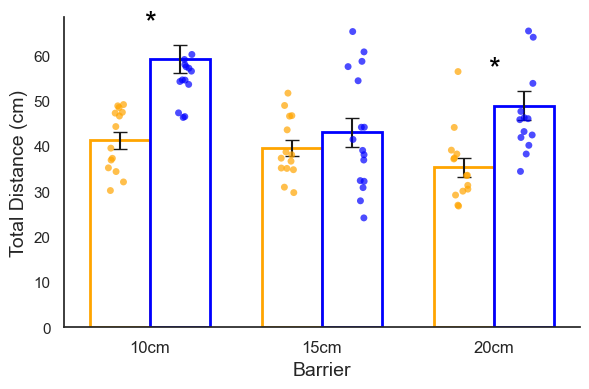

10cm:
  Control   -> mean = 41.29, std = 6.88, n = 14
  CNSDS     -> mean = 59.20, std = 12.12, n = 16
  t = -5.05, df = 24.3, p = 0.0000, corrected p = 0.0001, significant = True

15cm:
  Control   -> mean = 39.59, std = 6.81, n = 14
  CNSDS     -> mean = 43.02, std = 12.77, n = 16
  t = -0.93, df = 23.5, p = 0.3595, corrected p = 1.0000, significant = False

20cm:
  Control   -> mean = 35.32, std = 7.89, n = 14
  CNSDS     -> mean = 48.96, std = 11.75, n = 14
  t = -3.61, df = 22.7, p = 0.0015, corrected p = 0.0045, significant = True



In [2968]:
# ---- 1. Run Welch's t-tests and collect statistics ---- #
experiments = analysis_df['experiment'].unique()
results = []

for exp in experiments:
    subset = analysis_df[analysis_df['experiment'] == exp]
    control = subset[subset['condition'] == 'Control']['total_distance_cm']
    cnsds = subset[subset['condition'] == 'CNSDS']['total_distance_cm']

    n1, n2 = len(control), len(cnsds)
    
    if n1 > 1 and n2 > 1:
        t_stat, p = ttest_ind(control, cnsds, equal_var=False)
        s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

        results.append({
            'experiment': exp,
            't_stat': t_stat,
            'df': df,
            'p_raw': p,
            'n_control': n1,
            'n_cnsds': n2,
            'mean_control': np.mean(control),
            'std_control': np.std(control, ddof=1),
            'mean_cnsds': np.mean(cnsds),
            'std_cnsds': np.std(cnsds, ddof=1)
        })

# ---- 2. Bonferroni correction ---- #
p_vals = [r['p_raw'] for r in results]
reject, corrected_pvals, _, _ = smm.multipletests(p_vals, method='bonferroni')

for i, r in enumerate(results):
    r['p_corrected'] = corrected_pvals[i]
    r['significant'] = reject[i]

# ---- 3. Plot ---- #
plt.figure(figsize=(6, 4))

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35

# Calculate means and SEMs manually for styled bar plotting
summary = (
    analysis_df
    .groupby(['experiment', 'condition'])['total_distance_cm']
    .agg(['mean', 'sem'])
    .reset_index()
)

for i, exp in enumerate(experiments):
    for cond in ['Control', 'CNSDS']:
        row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
        if not row.empty:
            y = row['mean'].values[0]
            yerr = row['sem'].values[0]
            xpos = i - bar_width/2 if cond == 'Control' else i + bar_width/2
            plt.bar(
                xpos, y, width=bar_width, yerr=yerr,
                facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=5
            )

# Stripplot for individual data points
sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='total_distance_cm',
    hue='condition',
    palette=palette,
    dodge=True,
    jitter=True,
    alpha=0.7,
    marker='o'
)

# Remove duplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Condition')

# Asterisks for significance
y_max = analysis_df['total_distance_cm'].max()
asterisk_offset = 0.05 * y_max
asterisk_positions = []

for i, exp in enumerate(experiments):
    result = next((r for r in results if r['experiment'] == exp), None)
    if result and result['significant']:
        bar_top = summary[(summary['experiment'] == exp)]['mean'].max()
        y_asterisk = bar_top + asterisk_offset
        plt.text(i, y_asterisk, '*', ha='center', va='bottom', fontsize=22, color='black')
        asterisk_positions.append(y_asterisk)

# Set Y-axis limit above highest asterisk
y_limit = max(asterisk_positions) + asterisk_offset if asterisk_positions else y_max + asterisk_offset
plt.ylim(0, y_limit)

# Custom x-axis labels
plt.xticks(
    ticks=range(len(experiments)),
    labels=['10cm', '15cm', '20cm'],
    fontsize=12
)

plt.ylabel("Total Distance (cm)", fontsize=14)
plt.xlabel("Barrier", fontsize=14)

sns.despine(top=True, right=True)
plt.tight_layout()
plt.legend().remove()


plt.savefig("distance.pdf", format="pdf")
plt.show()

# ---- 4. Print statistical results ---- #
for r in results:
    print(
        f"{r['experiment']}:\n"
        f"  Control   -> mean = {r['mean_control']:.2f}, std = {r['std_control']:.2f}, n = {r['n_control']}\n"
        f"  CNSDS     -> mean = {r['mean_cnsds']:.2f}, std = {r['std_cnsds']:.2f}, n = {r['n_cnsds']}\n"
        f"  t = {r['t_stat']:.2f}, df = {r['df']:.1f}, "
        f"p = {r['p_raw']:.4f}, corrected p = {r['p_corrected']:.4f}, "
        f"significant = {r['significant']}\n"
    )


In [2969]:
# # ---- 1. Run t-tests with Bonferroni correction ---- #
# experiments = analysis_df['experiment'].unique()
# p_values = []
# experiment_labels = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment'] == exp]
#     control = subset[subset['condition'] == 'Control']['total_distance_cm']
#     cnsds = subset[subset['condition'] == 'CNSDS']['total_distance_cm']

#     if len(control) > 1 and len(cnsds) > 1:
#         stat, p = ttest_ind(control, cnsds)
#         p_values.append(p)
#         experiment_labels.append(exp)
#     else:
#         p_values.append(None)
#         experiment_labels.append(exp)

# # Bonferroni correction
# valid_pvals = [p for p in p_values if p is not None]
# reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')

# # Map corrected p-values to experiments
# pval_results = {}
# idx = 0
# for exp, raw_p in zip(experiment_labels, p_values):
#     if raw_p is not None:
#         pval_results[exp] = (corrected_pvals[idx], reject[idx])
#         idx += 1

# # ---- 2. Plot ---- #
# plt.figure(figsize=(10, 6))

# # Barplot with condition order (Control first, then CNSDS) and custom colors
# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment',
#     y='total_distance_cm',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar='se',
#     dodge=True,
#     hue_order=['Control', 'CNSDS']  # Control on the left, CNSDS on the right
# )

# # Add individual data points
# sns.stripplot(
#     data=analysis_df,
#     x='experiment',
#     y='total_distance_cm',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     marker='o',
#     alpha=0.6
# )

# # Clean up duplicated legends
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title='Condition')

# # # ---- 3. Annotate p-values ---- #
# # xticks = ax.get_xticks()
# # for i, exp in enumerate(experiments):
# #     if exp in pval_results:
# #         pval, significant = pval_results[exp]
# #         label = f"*  p = {pval:.3f}" if significant else f"p = {pval:.3f}"
# #         max_y = analysis_df[analysis_df['experiment'] == exp]['total_distance_cm'].max()
        
# #         # Adjust the vertical placement of the p-value label
# #         plt.text(xticks[i], max_y - max_y * 0.1, label, ha='center', fontsize=10, color='black')

# # Rename x-axis ticks
# plt.xticks(ticks=range(len(analysis_df['experiment'].unique())), labels=['10cm', '15cm', '20cm'])

# # ---- Final formatting ---- #
# plt.title("Total Distance Traveled (cm)")
# plt.ylabel("Total Distance (cm)")
# plt.xlabel("Experiment")
# plt.tight_layout()
# plt.show()


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\2503737713.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\2503737713.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df
C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\2503737713.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_df


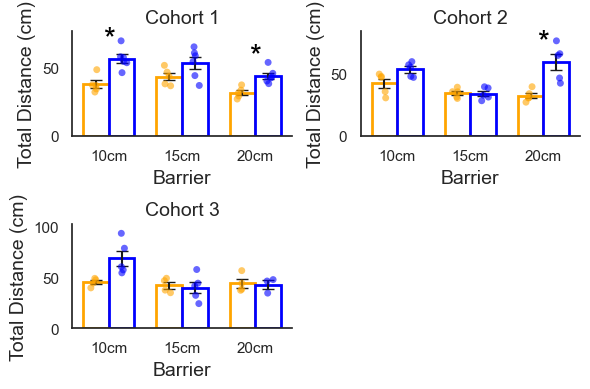

In [2970]:
# Define date cohorts
dates_to_analyze = [
    ['31524', '31824', '32124'],   # Cohort 1
    ['50524', '50824', '51124'],   # Cohort 2
    ['62624', '62924', '70224']    # Cohort 3
]

# Plot setup: 2x2 grid (3 used)
fig, axes = plt.subplots(2, 2, figsize=(6, 4))
axes = axes.flatten()  # To index 0, 1, 2

palette = {'Control': 'orange', 'CNSDS': 'blue'}
bar_width = 0.35

for idx, cohort_dates in enumerate(dates_to_analyze):
    ax = axes[idx]
    
    cohort_df = analysis_df[analysis_df['date'].isin(cohort_dates)]
    experiments = cohort_df['experiment'].unique()
    
    # Group summary
    summary = (
        cohort_df
        .groupby(['experiment', 'condition'])['total_distance_cm']
        .agg(['mean', 'sem'])
        .reset_index()
    )

    # ---- Run Welch's t-tests ---- #
    results = []
    for exp in experiments:
        subset = cohort_df[cohort_df['experiment'] == exp]
        control = subset[subset['condition'] == 'Control']['total_distance_cm']
        cnsds = subset[subset['condition'] == 'CNSDS']['total_distance_cm']

        if len(control) > 1 and len(cnsds) > 1:
            t_stat, p = ttest_ind(control, cnsds, equal_var=False)
            s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
            n1, n2 = len(control), len(cnsds)
            df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

            results.append({
                'experiment': exp,
                'p_raw': p,
                'mean_control': np.mean(control),
                'mean_cnsds': np.mean(cnsds)
            })

    # ---- Bonferroni correction ---- #
    if results:
        p_vals = [r['p_raw'] for r in results]
        reject, corrected_pvals, _, _ = smm.multipletests(p_vals, method='bonferroni')
        for i, r in enumerate(results):
            r['p_corrected'] = corrected_pvals[i]
            r['significant'] = reject[i]

    # ---- Plot bars ---- #
    for i, exp in enumerate(experiments):
        for cond in ['Control', 'CNSDS']:
            row = summary[(summary['experiment'] == exp) & (summary['condition'] == cond)]
            if not row.empty:
                y = row['mean'].values[0]
                yerr = row['sem'].values[0]
                xpos = i - bar_width / 2 if cond == 'Control' else i + bar_width / 2
                ax.bar(
                    xpos, y, width=bar_width, yerr=yerr,
                    facecolor='white', edgecolor=palette[cond], linewidth=2, capsize=4
                )

    # ---- Plot individual data points ---- #
    sns.stripplot(
        data=cohort_df,
        x='experiment',
        y='total_distance_cm',
        hue='condition',
        palette=palette,
        dodge=True,
        jitter=True,
        alpha=0.6,
        ax=ax
    )

    # Remove duplicated legend
    ax.get_legend().remove()

    # ---- Asterisk for significance ---- #
    y_max = cohort_df['total_distance_cm'].max()
    offset = 0.05 * y_max

    for i, r in enumerate(results):
        if r['significant']:
            max_y = max(r['mean_control'], r['mean_cnsds'])
            ax.text(i, max_y + offset, '*', ha='center', va='bottom', fontsize=22, color='black')

    ax.set_title(f'Cohort {idx+1}', fontsize=14)
    ax.set_ylabel("Total Distance (cm)", fontsize = 14)
    ax.set_xlabel("Barrier", fontsize = 14)
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(experiments)
    ax.set_ylim(0, y_max + 2 * offset)
    sns.despine(ax=ax, top=True, right=True)

# Hide unused subplot
axes[3].axis('off')

plt.tight_layout()
plt.savefig("distance_by_cohort.pdf", format="pdf")
plt.show()


# Time Spent in Decision Zone

In [2971]:
# 1. Filter frames in the decision area
decision_area_df = pts[
    (pts['normalized_x'] >= -100) & (pts['normalized_x'] <= 100) &
    (pts['normalized_y'] >= 200) & (pts['normalized_y'] <= 600)
]

# 2. Count frames in decision area per trial
decision_counts = decision_area_df.groupby(['experiment', 'subject', 'trial']).size().reset_index(name='decision_frame_count')

# 3. Convert frame count to time (seconds)
decision_counts['decision_time_secs'] = decision_counts['decision_frame_count'] / 60  # assuming 60 fps

# 4. Average time per subject and experiment across trials
avg_decision_time = decision_counts.groupby(['experiment', 'subject'])['decision_time_secs'].mean().reset_index()
avg_decision_time.rename(columns={'decision_time_secs': 'avg_decision_time_secs'}, inplace=True)

# 5. Merge with analysis_df
analysis_df = analysis_df.merge(
    avg_decision_time,
    on=['experiment', 'subject'],
    how='left'
)


In [2972]:
# # Step 1: Filter merged_df for rows where normalized_x is between -100 and 100 and normalized_y is between -100 and 200
# filtered_df = pts[(pts['normalized_x'] >= -100) & (pts['normalized_x'] <= 100) &
#                         (pts['normalized_y'] >= -100) & (pts['normalized_y'] <= 200)]

# # Step 2: Count the number of frames (columns) per barrier, mouse, and trial
# # Group by 'barrier', 'mouse', and 'trial', then count the number of frames (columns)
# frame_counts = filtered_df.groupby(['experiment', 'subject']).size()

# # Step 3: Convert frame counts to time in seconds (60 frames = 1 second)
# time_seconds = frame_counts / 60  # Convert frames to seconds

# # Step 4: Create a DataFrame for time_seconds with 'barrier', 'mouse', and 'trial' as index
# time_df = time_seconds.reset_index(name='decision_area_time')

# # Step 5: Merge the computed time (decision_area_time) into summary_df
# analysis_df = analysis_df.merge(time_df, on=['barrier', 'subject'], how='left')


c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


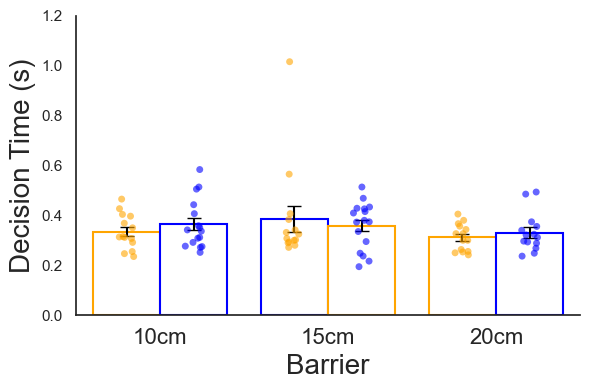

In [2973]:
palette = {'Control': 'orange', 'CNSDS': 'blue'}

plt.figure(figsize=(6, 4))

ax = sns.barplot(
    data=analysis_df,
    x='experiment',
    y='avg_decision_time_secs',
    hue='condition',
    palette=palette,
    errorbar=None,  # disable seaborn automatic error bars
    dodge=True
)

# Set white fill and colored edges for bars
for i, bar in enumerate(ax.patches):
    bar.set_facecolor('white')
    if i % 2 == 0:
        bar.set_edgecolor(palette['Control'])
    else:
        bar.set_edgecolor(palette['CNSDS'])
    bar.set_linewidth(1.5)

# Manually add error bars
experiments = analysis_df['experiment'].unique()
bar_width = 0.8  # total width for both bars in a group
offset = bar_width / 2

for i, exp in enumerate(experiments):
    for j, cond in enumerate(['Control', 'CNSDS']):
        subset = analysis_df[(analysis_df['experiment'] == exp) & (analysis_df['condition'] == cond)]
        if not subset.empty:
            mean = subset['avg_decision_time_secs'].mean()
            se = subset['avg_decision_time_secs'].sem()
            # Position of each bar: i +/- half bar width
            x_pos = i - offset/2 if cond == 'Control' else i + offset/2

            ax.errorbar(
                x=x_pos, y=mean, yerr=se,
                fmt='none', ecolor='black', capsize=5,
                linewidth=1.5, zorder=3
            )

sns.stripplot(
    data=analysis_df,
    x='experiment',
    y='avg_decision_time_secs',
    hue='condition',
    dodge=True,
    palette=palette,
    alpha=0.6,
    ax=ax
)

# Remove legend
ax.legend_.remove()

plt.xticks(ticks=range(len(experiments)), labels=['10cm', '15cm', '20cm'], fontsize=16)
plt.ylabel("Decision Time (s)", fontsize=20)
plt.xlabel("Barrier", fontsize=20)
plt.ylim(0, 1.2)

sns.despine(top=True, right=True)

# Plot significance asterisks as before (if needed)...

plt.tight_layout()
plt.savefig("decision_time.pdf", format="pdf")
plt.show()


In [2974]:
# # Ensure consistent condition order
# analysis_df['condition'] = pd.Categorical(
#     analysis_df['condition'],
#     categories=['Control', 'CNSDS'],
#     ordered=True
# )

# # ---- 1. T-tests and Bonferroni correction ---- #
# experiments = analysis_df['experiment'].unique()
# p_values = []
# experiment_labels = []

# for exp in experiments:
#     subset = analysis_df[analysis_df['experiment'] == exp]
#     control = subset[subset['condition'] == 'Control']['avg_decision_time_secs']
#     cnsds = subset[subset['condition'] == 'CNSDS']['avg_decision_time_secs']

#     if len(control) > 1 and len(cnsds) > 1:
#         stat, p = ttest_ind(control, cnsds)
#         p_values.append(p)
#         experiment_labels.append(exp)
#     else:
#         p_values.append(None)
#         experiment_labels.append(exp)

# # Bonferroni correction
# valid_pvals = [p for p in p_values if p is not None]
# reject, corrected_pvals, _, _ = smm.multipletests(valid_pvals, method='bonferroni')

# # Map corrected p-values to experiments
# pval_results = {}
# idx = 0
# for exp, raw_p in zip(experiment_labels, p_values):
#     if raw_p is not None:
#         pval_results[exp] = (corrected_pvals[idx], reject[idx])
#         idx += 1

# # ---- 2. Plot ---- #
# plt.figure(figsize=(10, 6))

# # Bar plot
# ax = sns.barplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_decision_time_secs',
#     hue='condition',
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     errorbar=('se', 1),
#     dodge=True
# )

# # Strip plot (individual points)
# sns.stripplot(
#     data=analysis_df,
#     x='experiment',
#     y='avg_decision_time_secs',
#     hue='condition',
#     dodge=True,
#     palette={'Control': 'orange', 'CNSDS': 'blue'},
#     marker='o',
#     alpha=0.6
# )

# # Remove duplicate legends
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title="Condition")

# # # ---- 3. Annotate p-values ---- #
# # xticks = ax.get_xticks()
# # for i, exp in enumerate(experiments):
# #     if exp in pval_results:
# #         pval, significant = pval_results[exp]
# #         label = f"*  p = {pval:.3f}" if significant else f"p = {pval:.3f}"

# #         max_y = analysis_df[analysis_df['experiment'] == exp]['avg_decision_time_secs'].max()
# #         y_pos = max_y + 0.2  # adjust height as needed
# #         xpos = xticks[i]
# #         plt.text(xpos, y_pos, label, ha='center', va='bottom', fontsize=10, color='black')

# # Rename x-axis ticks
# plt.xticks(ticks=range(len(analysis_df['experiment'].unique())), labels=['10cm', '15cm', '20cm'])

# # ---- Final Touches ---- #
# plt.title("Average Decision Time")
# plt.ylabel("Avg Decision Time (s)")
# plt.xlabel("Experiment")
# plt.ylim(0, analysis_df['avg_decision_time_secs'].max() + 0.5)
# plt.tight_layout()
# plt.show()

# Head Angle

In [2975]:
# Assuming Maze Center coordinates are available in the DataFrame
maze_center_x_col = 'Maze_Center_x'
maze_center_y_col = 'Maze_Center_y'

# Ensure the column names are stripped of extra spaces or characters
#pts.columns = pts.columns.str.strip()

# Define body part columns for Nose_ and Left_Ear_
nose_x_col = 'Nose_x'
nose_y_col = 'Nose_y'
left_ear_x_col = 'Left_Ear_x'
left_ear_y_col = 'Left_Ear_y'
right_ear_x_col = 'Right_Ear_x'
right_ear_y_col = 'Right_Ear_y'

# Define the likelihood columns
nose_likelihood_col = 'Nose_likelihood'
left_ear_likelihood_col = 'Left_Ear_likelihood'
right_ear_likelihood_col = 'Right_Ear_likelihood'

# Create a list to store the normalized head angles
normalized_head_angles = []

# Iterate over each row of the DataFrame to calculate and normalize the head angle
for index, row in pts.iterrows():
    # Check if the likelihood for both the Nose and Left Ear is greater than 0.7
    if row[nose_likelihood_col] > 0.7 and row[left_ear_likelihood_col] > 0.7:
        # Normalize Nose and Left Ear coordinates by subtracting Maze Center coordinates
        normalized_nose_x = row[nose_x_col] - row[maze_center_x_col]
        normalized_nose_y = row[nose_y_col] - row[maze_center_y_col]
        normalized_left_ear_x = row[left_ear_x_col] - row[maze_center_x_col]
        normalized_left_ear_y = row[left_ear_y_col] - row[maze_center_y_col]
        normalized_right_ear_x = row[right_ear_x_col] - row[maze_center_x_col]
        normalized_right_ear_y = row[right_ear_y_col] - row[maze_center_y_col]

        ear_x = np.nanmean([normalized_right_ear_x,normalized_left_ear_x])
        ear_y = np.nanmean([normalized_right_ear_y,normalized_left_ear_y])

        # Calculate the normalized head angle using atan2 function
        delta_x = ear_x - normalized_nose_x
        delta_y = ear_y - normalized_nose_y
        head_angle = np.arctan2(delta_y, delta_x)  - np.pi/2 # atan2 returns angle in radians, subtracting pi/2 makes up (vertical) zero
    else:
        head_angle = np.nan  # If the likelihood is not > 0.7, set head_angle as NaN
    
    # Append the normalized head angle to the list
    angle_deg = (np.degrees(head_angle) + 180) % 360 - 180 
    normalized_head_angles.append(angle_deg)

# Add the normalized head_angle column to the DataFrame
pts['normalized_head_angle'] = normalized_head_angles#_subtracted

In [2976]:
# Total number of rows
total_rows = len(pts)

# Number of NaNs in the 'normalized_head_angle' column
nans_in_head_angle = pts['normalized_head_angle'].isna().sum()

print(f"Total rows: {total_rows}")
print(f"NaNs in 'normalized_head_angle': {nans_in_head_angle}")


Total rows: 49647
NaNs in 'normalized_head_angle': 10840


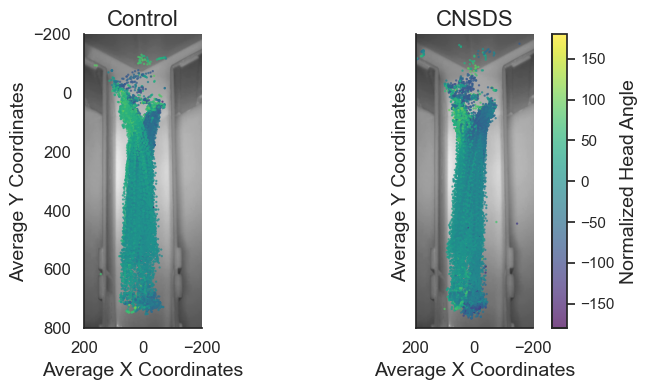

In [2977]:
# Define the conditions
conditions = ['Control', 'CNSDS']

# Create a figure with 2 subplots (one for each condition)
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Iterate over the conditions and plot on respective subplots
for i, condition in enumerate(conditions):
    ax = axes[i]
    
    # Filter the data based on the condition
    condition_data = pts[pts['condition'] == condition]

    height, width, chan = frame.shape
    extent = [-x_pic, width - x_pic, height - y_pic, -y_pic]
    # Rotation angle in degrees
    angle = 2  # counter-clockwise
    # Create transform
    transform = Affine2D().rotate_deg_around(0, 0, angle) + ax.transData
    ax.imshow(frame, extent=extent, origin='upper', transform=transform)
    
    # Plot the scatter plot for the head angles with a red color scale
    scatter = ax.scatter(condition_data['normalized_x'], condition_data['normalized_y'], 
                              c=condition_data['normalized_head_angle'], 
                              cmap='viridis', s=0.5, alpha=0.7, vmin=-180, vmax=180)
    
    # Set the titles for each subplot
    ax.set_title(f'{condition}', fontsize=16)
    ax.set_xlabel('Average X Coordinates', fontsize=14)
    ax.set_ylabel('Average Y Coordinates', fontsize=14)

    # Set axis limits
    ax.set_xlim(200, -200)  # Set x-axis range from -200 to 200
    ax.set_ylim(800, -200)  # Set y-axis range from -200 to 800

    ax.tick_params(axis='both', labelsize=12)

# Adjust layout to avoid overlapping with the colorbar
plt.tight_layout()

# Add the colorbar with the desired location (to the side of the graph)
cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', pad=0.02)
cbar.set_label('Normalized Head Angle', fontsize=14)

# Show the plot
sns.despine(top=True, right=True)
# plt.tight_layout()
plt.savefig("headangle_locations.pdf", format="pdf")
plt.show()


C:\Users\Jillian.Sucher\AppData\Local\Temp\ipykernel_16528\3153661969.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trial_histograms = pts.groupby(['subject', 'experiment', 'condition']).apply(compute_normalized_histogram).reset_index()


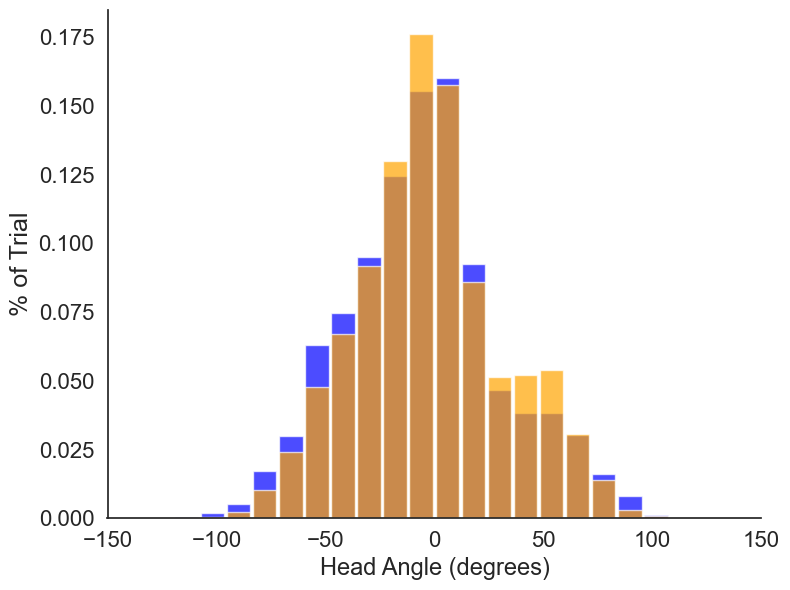

In [2978]:
# Set number of bins
bins = 30

# Define shared bin edges
angle_min = pts['normalized_head_angle'].min()
angle_max = pts['normalized_head_angle'].max()
x_bins = np.linspace(angle_min, angle_max, bins + 1)
bin_centers = 0.5 * (x_bins[:-1] + x_bins[1:])

# Function to compute normalized histogram for each trial
def compute_normalized_histogram(group):
    counts, _ = np.histogram(group['normalized_head_angle'], bins=x_bins)
    norm = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
    return pd.Series(norm, index=range(bins))

# Compute normalized histogram for each trial
trial_histograms = pts.groupby(['subject', 'experiment', 'condition']).apply(compute_normalized_histogram).reset_index()
trial_histograms = trial_histograms.rename(columns={i: f'bin_{i}' for i in range(bins)})

# Melt to long format
long_df = trial_histograms.melt(id_vars=['subject', 'experiment', 'condition'],
                                var_name='bin', value_name='proportion')
long_df['bin'] = long_df['bin'].str.extract(r'bin_(\d+)').astype(int)
long_df['bin_center'] = bin_centers[long_df['bin']]

# Average per group
mean_df = long_df.groupby(['condition', 'bin_center'])['proportion'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))

# Bar width
bar_width = (x_bins[1] - x_bins[0]) * 0.9

# Plot CNSDS
cnsds_data = mean_df[mean_df['condition'] == 'CNSDS']
plt.bar(cnsds_data['bin_center'], cnsds_data['proportion'],
        width=bar_width, color='blue', alpha=0.7, label='CNSDS')

# Plot Control
control_data = mean_df[mean_df['condition'] == 'Control']
plt.bar(control_data['bin_center'], control_data['proportion'],
        width=bar_width, color='orange', alpha=0.7, label='Control')

# Formatting
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Head Angle (degrees)', fontsize=17)
plt.ylabel('% of Trial', fontsize=18)
plt.xlim(-150,150)
#plt.legend(fontsize=13)
plt.tight_layout()
sns.despine(top=True, right=True)
plt.savefig("D:/Figures/_norm_headangle_distribution", format="pdf")
plt.show()


## TRY TO FLIP THESE BASED ON WHICH SIDE IS HR (YOU'LL HAVE TO USE SIMILAR CODE YOU USED FOR PLOTTING THE X/Y POSITIONS)

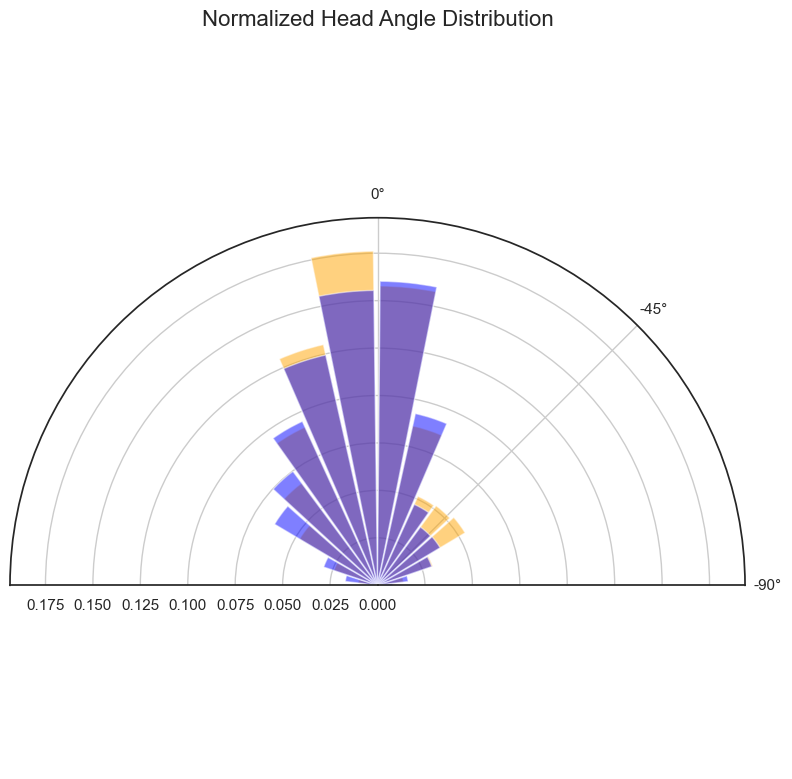

In [2979]:
### TRY TO FLIP THESE BASED ON WHICH SIDE IS HR (YOU'LL HAVE TO USE SIMILAR CODE YOU USED FOR PLOTTING THE X/Y POSITIONS)

# Convert degrees to radians — retain negative values!
mean_df['theta'] = np.deg2rad(mean_df['bin_center'])

# Polar bar width in radians
bar_width_rad = np.deg2rad((x_bins[1] - x_bins[0]) * 0.9)

# Set up polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Plot Control
control_data = mean_df[mean_df['condition'] == 'Control']
ax.bar(control_data['theta'], control_data['proportion'],
       width=bar_width_rad, color='orange', alpha=0.5, label='Control')

# Plot CNSDS
cnsds_data = mean_df[mean_df['condition'] == 'CNSDS']
ax.bar(cnsds_data['theta'], cnsds_data['proportion'],
       width=bar_width_rad, color='blue', alpha=0.5, label='CNSDS')

# Fix angle mapping and axis
ax.set_theta_zero_location('N')  # 0° at top
ax.set_theta_direction(-1)       # Clockwise
ax.set_rlabel_position(270)
ax.set_ylim(0, mean_df['proportion'].max() * 1.1)

# Custom angle labels for true -180° to 180° display
tick_locs = np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315])
tick_labels = ['0°', '-45°', '-90°', '-135°', '180°', '135°', '90°', '45°']
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels)

ax.set_thetamin(-90)
ax.set_thetamax(90)

# Labels and legend
#ax.legend(loc='upper right', fontsize=13)
plt.title("Normalized Head Angle Distribution", fontsize=16)
plt.tight_layout()
plt.savefig("D:/Figures/corrected_headangle_polar_distribution", format="pdf")
plt.show()


# SIT test

In [2980]:
#SIT_df = SIT_df[(SIT_df['xpos'] >= 0) & (SIT_df['ypos'] >= 0)]

In [2981]:
#SIT_df['condition'] = SIT_df['condition'].str.lower()
#SIT_df['test'] = SIT_df['test'].str.lower()

In [2982]:
# # Step 1: Ensure 'test' column values are lowercase
# SIT_df['test'] = SIT_df['test'].str.lower()

# # Step 2: Calculate the proportion of 1s per subject and test
# proportion_df = (
#     SIT_df.groupby(['subject', 'test'])
#     .apply(lambda g: (g == 1).sum().sum() / len(g))
#     .reset_index(name='proportion')
# )

# # Step 3: Pivot so each test becomes a column: no, cd1, c57
# pivot_df = proportion_df.pivot(index='subject', columns='test', values='proportion').reset_index()
# pivot_df.columns.name = None  # Clean column names

# # Step 4: Ensure all expected columns are present
# for col in ['no', 'CD1', 'c57']:
#     if col not in pivot_df.columns:
#         pivot_df[col] = 0.0  # or np.nan, depending on preference

# # Step 5: Add 'condition' by merging with subject info
# subject_conditions = SIT_df[['subject', 'condition']].drop_duplicates()
# SIT_data_df = pd.merge(subject_conditions, pivot_df, on='subject', how='left')


In [2983]:
# SIT_data_df.rename(columns={'no': 'object'}, inplace=True)

In [2984]:
# # Define the total time in seconds (adjust this if necessary)
# total_time_seconds = 100  # Example: 100 seconds

# # Convert proportions to time (seconds)
# SIT_data_df['cd1_sec'] = SIT_data_df['cd1'] * total_time_seconds
# SIT_data_df['c57_sec'] = SIT_data_df['c57'] * total_time_seconds
# SIT_data_df['object_sec'] = SIT_data_df['object'] * total_time_seconds


c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


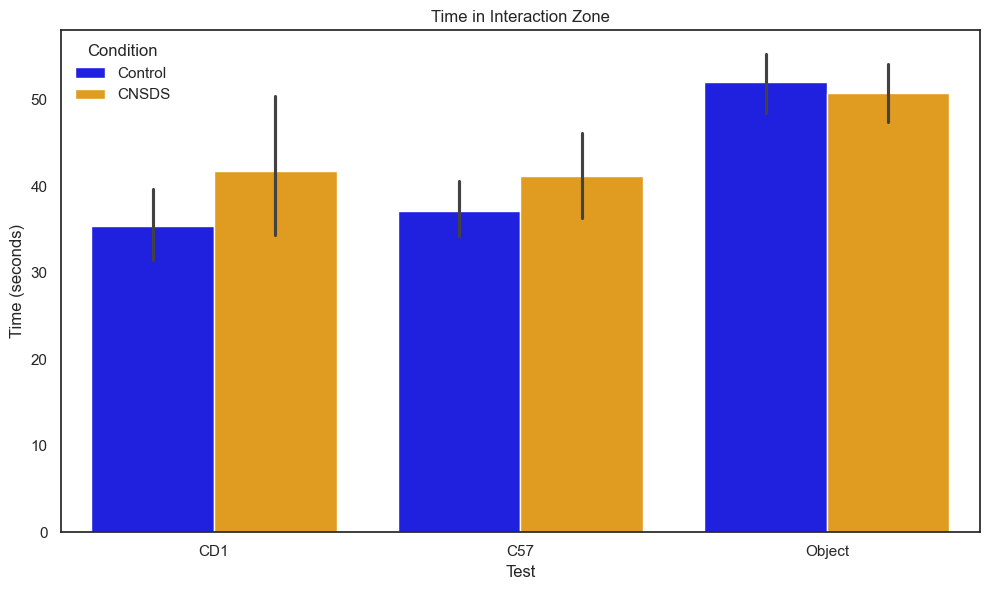


Condition: Cnsds
  CD1     -> mean = 35.36, std = 9.80, n = 20
  Object  -> mean = 52.04, std = 7.82, n = 20
  t = -5.95, df = 36.2, p = 0.0000

Condition: Control
  CD1     -> mean = 41.83, std = 18.14, n = 20
  Object  -> mean = 50.79, std = 7.82, n = 20
  t = -2.03, df = 25.8, p = 0.0528


In [2985]:
# Step 1: Reshape the data
SIT_data_long = SIT_data_df.melt(
    id_vars=['condition', 'subject'], 
    value_vars=['cd1_sec', 'c57_sec', 'object_sec'], 
    var_name='test', 
    value_name='time_sec'
)

# Step 2: Rename test labels
SIT_data_long['test'] = SIT_data_long['test'].replace({
    'cd1_sec': 'CD1',
    'c57_sec': 'C57',
    'object_sec': 'Object'
})

# Step 3: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='test', y='time_sec', hue='condition', data=SIT_data_long,
            palette={'control': 'orange', 'cnsds': 'blue'})
plt.title('Time in Interaction Zone')
plt.ylabel('Time (seconds)')
plt.xlabel('Test')

# Fix legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Control', 'CNSDS'], title='Condition', loc='best', handlelength=2, frameon=False)
plt.tight_layout()
plt.show()

# Step 4: Run t-tests within each condition: Object vs CD1
results = []

for cond in SIT_data_long['condition'].unique():
    sub_df = SIT_data_long[SIT_data_long['condition'] == cond]
    cd1 = sub_df[sub_df['test'] == 'CD1']['time_sec']
    obj = sub_df[sub_df['test'] == 'Object']['time_sec']
    
    if len(cd1) > 1 and len(obj) > 1:
        t_stat, p_val = ttest_ind(cd1, obj, equal_var=False)
        s1_sq, s2_sq = np.var(cd1, ddof=1), np.var(obj, ddof=1)
        n1, n2 = len(cd1), len(obj)
        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

        results.append({
            'condition': cond,
            't_stat': t_stat,
            'df': df,
            'p_val': p_val,
            'n_cd1': n1,
            'n_object': n2,
            'mean_cd1': np.mean(cd1),
            'std_cd1': np.std(cd1, ddof=1),
            'mean_object': np.mean(obj),
            'std_object': np.std(obj, ddof=1)
        })

# Step 5: Print results
for res in results:
    print(f"\nCondition: {res['condition'].capitalize()}")
    print(f"  CD1     -> mean = {res['mean_cd1']:.2f}, std = {res['std_cd1']:.2f}, n = {res['n_cd1']}")
    print(f"  Object  -> mean = {res['mean_object']:.2f}, std = {res['std_object']:.2f}, n = {res['n_object']}")
    print(f"  t = {res['t_stat']:.2f}, df = {res['df']:.1f}, p = {res['p_val']:.4f}")


In [2986]:
# # ---- WITHIN CONDITION COMPARISONS ---- #
# print("=== Within Condition Comparisons (CD1 vs Object) ===")
# results = []

# for cond in SIT_data_long['condition'].unique():
#     sub_df = SIT_data_long[SIT_data_long['condition'] == cond]
#     cd1 = sub_df[sub_df['test'] == 'CD1']['time_sec']
#     obj = sub_df[sub_df['test'] == 'Object']['time_sec']
    
#     if len(cd1) > 1 and len(obj) > 1:
#         t_stat, p_val = ttest_ind(cd1, obj, equal_var=False)
#         s1_sq, s2_sq = np.var(cd1, ddof=1), np.var(obj, ddof=1)
#         n1, n2 = len(cd1), len(obj)
#         df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

#         print(f"\nCondition: {cond.capitalize()}")
#         print(f"  CD1     -> mean = {np.mean(cd1):.2f}, std = {np.std(cd1, ddof=1):.2f}, n = {n1}")
#         print(f"  Object  -> mean = {np.mean(obj):.2f}, std = {np.std(obj, ddof=1):.2f}, n = {n2}")
#         print(f"  t = {t_stat:.2f}, df = {df:.1f}, p = {p_val:.4f}")

# # ---- BETWEEN CONDITION COMPARISONS ---- #
# print("\n=== Between Condition Comparisons (Control vs CNSDS) ===")

# for test in ['CD1', 'Object']:
#     test_df = SIT_data_long[SIT_data_long['test'] == test]
#     control = test_df[test_df['condition'] == 'control']['time_sec']
#     cnsds = test_df[test_df['condition'] == 'cnsds']['time_sec']

#     if len(control) > 1 and len(cnsds) > 1:
#         t_stat, p_val = ttest_ind(control, cnsds, equal_var=False)
#         s1_sq, s2_sq = np.var(control, ddof=1), np.var(cnsds, ddof=1)
#         n1, n2 = len(control), len(cnsds)
#         df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/(n1**2*(n1-1)) + (s2_sq**2)/(n2**2*(n2-1)))

#         print(f"\nTest: {test}")
#         print(f"  Control -> mean = {np.mean(control):.2f}, std = {np.std(control, ddof=1):.2f}, n = {n1}")
#         print(f"  CNSDS   -> mean = {np.mean(cnsds):.2f}, std = {np.std(cnsds, ddof=1):.2f}, n = {n2}")
#         print(f"  t = {t_stat:.2f}, df = {df:.1f}, p = {p_val:.4f}")


c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Jillian.Sucher\anaconda3\envs\keypoint_moseq\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


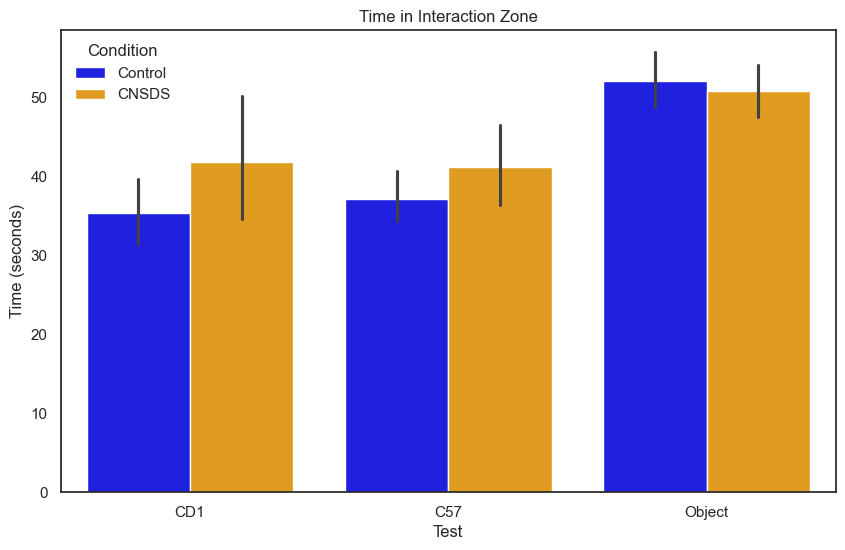

In [2987]:
# Step 1: Reshape the data into a long format for easy plotting
SIT_data_long = SIT_data_df.melt(id_vars=['condition', 'subject'], 
                                 value_vars=['cd1_sec', 'c57_sec', 'object_sec'], 
                                 var_name='test', 
                                 value_name='time_sec')

# Step 2: Rename the 'test' column values to the desired names
SIT_data_long['test'] = SIT_data_long['test'].replace({
    'cd1_sec': 'CD1',
    'c57_sec': 'C57',
    'object_sec': 'Object'
})

# Step 3: Create a bar plot with seaborn
plt.figure(figsize=(10, 6))

# Create the bar plot with proper colors for the conditions
sns.barplot(x='test', y='time_sec', hue='condition', data=SIT_data_long, 
            palette={'control': 'orange', 'cnsds': 'blue'})

# Customize plot appearance
plt.title('Time in Interaction Zone')
plt.ylabel('Time (seconds)')
plt.xlabel('Test')

# Update legend labels and manually set colors for the legend
handles, labels = plt.gca().get_legend_handles_labels()

# Map the colors to the legend manually and capitalize the labels
plt.legend(handles=handles, labels=['Control', 'CNSDS'], title='Condition', loc='best', 
           handlelength=2, frameon=False)

# Show plot
plt.show()


In [2988]:
# # Step 3: Run t-tests for each test condition
# t_tests_results = {}

# for test in ['cd1_sec', 'c57_sec', 'object_sec']:
#     # Extract the data for the two conditions (control and cnsds)
#     control_data = SIT_data_df[SIT_data_df['condition'] == 'control'][test]
#     cnsds_data = SIT_data_df[SIT_data_df['condition'] == 'cnsds'][test]
    
#     # Perform the t-test
#     t_stat, p_value = ttest_ind(control_data, cnsds_data, nan_policy='omit')
#     t_tests_results[test] = {'t-statistic': t_stat, 'p-value': p_value}

# # Display the results
# t_tests_results


In [2989]:
# SIT_data_df

# Correlations

Trial Duration (sec) (Control) — r = 0.167, p = 0.2900
Trial Duration (sec) (CNSDS) — r = 0.427, p = 0.0031
Velocity (cm) (Control) — r = -0.166, p = 0.2929
Velocity (cm) (CNSDS) — r = -0.269, p = 0.0704
Start Box Time (sec) (Control) — r = 0.250, p = 0.1096
Start Box Time (sec) (CNSDS) — r = 0.083, p = 0.5856
Total Distance (cm) (Control) — r = 0.445, p = 0.0031
Total Distance (cm) (CNSDS) — r = 0.414, p = 0.0043
Time in Decision Zone (secs) (Control) — r = -0.061, p = 0.7004
Time in Decision Zone (secs) (CNSDS) — r = 0.267, p = 0.0730


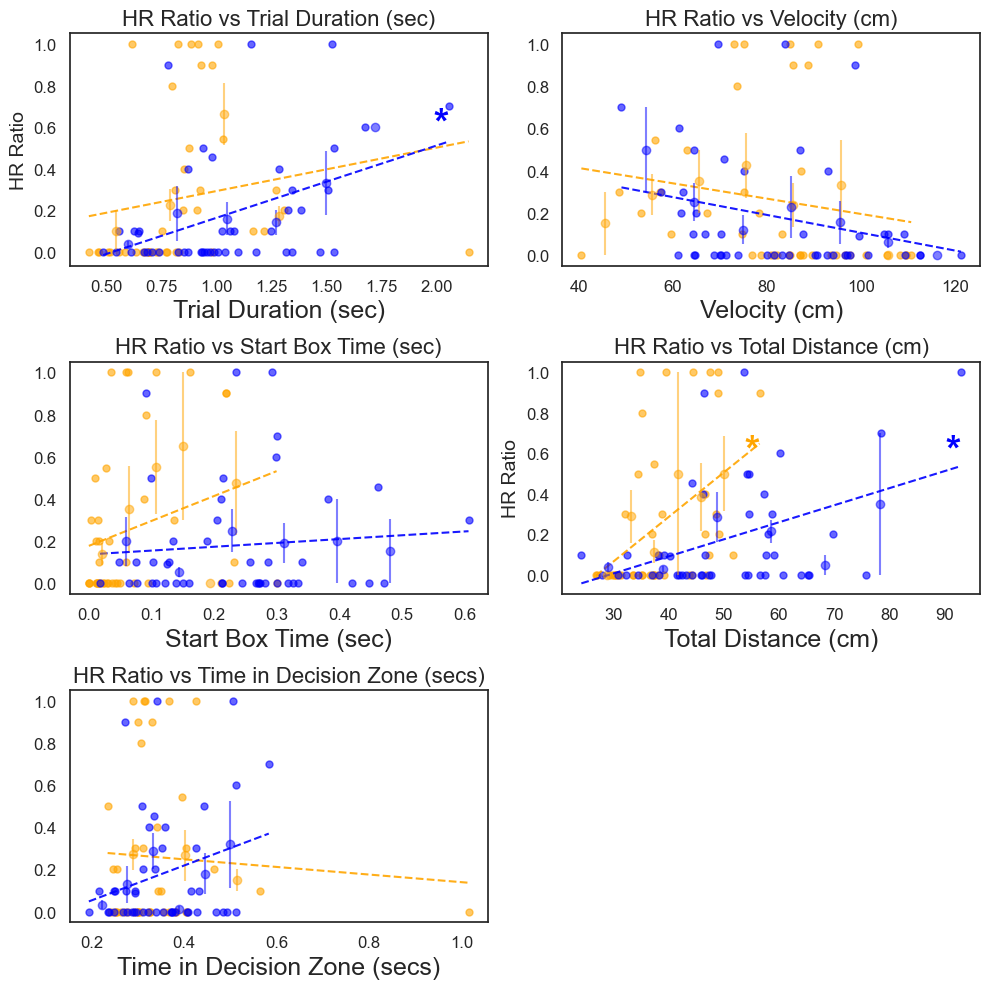

In [3002]:
# Variables and custom labels
variables = {
    'avg_trial_duration': 'Trial Duration (sec)',
    'avg_velocity_cm': 'Velocity (cm)',
    'avg_start_box_time_secs': 'Start Box Time (sec)',
    'total_distance_cm': 'Total Distance (cm)',
    'avg_decision_time_secs': 'Time in Decision Zone (secs)'
}

# Drop rows with missing data
clean_df = analysis_df.dropna(subset=list(variables.keys()) + ['HR_ratio', 'condition'])

# Create subplots: 3 on top row, 2 on bottom row
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
axes = axes.flatten()

colors = {'Control': 'orange', 'CNSDS': 'blue'}

# Loop through each variable
for idx, (var, label) in enumerate(variables.items()):
    ax = axes[idx]

    for condition in ['Control', 'CNSDS']:
        subset = clean_df[clean_df['condition'] == condition]

        x = subset[var]
        y = subset['HR_ratio']

        # Calculate correlation
        if len(subset) > 2:
            r, p = pearsonr(x, y)
            print(f"{label} ({condition}) — r = {r:.3f}, p = {p:.4f}")

        # Scatter plot
        ax.scatter(x, y, color=colors[condition], alpha=0.6, label=condition, s=25)

        # Plot regression line
        if len(x) > 1:
            slope, intercept = np.polyfit(x, y, 1)
            x_vals = np.linspace(x.min(), x.max(), 100)
            y_vals = intercept + slope * x_vals
            ax.plot(x_vals, y_vals, color=colors[condition], linestyle='--', alpha=0.9)

        # Plot SEM error bars
        bins = np.linspace(x.min(), x.max(), 8)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        means = []
        sems = []
        for start, end in zip(bins[:-1], bins[1:]):
            bin_y = y[(x >= start) & (x < end)]
            means.append(bin_y.mean() if len(bin_y) > 0 else np.nan)
            sems.append(bin_y.sem() if len(bin_y) > 1 else np.nan)
        means = np.array(means)
        sems = np.array(sems)
        valid = ~np.isnan(means)
        ax.errorbar(bin_centers[valid], means[valid], yerr=sems[valid], fmt='o', color=colors[condition], alpha=0.5)

        # Add asterisk if significant
        if 'r' in locals() and p < 0.05:
            ax.text(
                x.max(), y.max() - 0.3,
                '*', fontsize=28, color=colors[condition],
                ha='right', va='top', fontweight='bold'
            )

    # Axis labels
    ax.set_xlabel(label, fontsize=18)
    if idx in [0, 3]:  # Left column
        ax.set_ylabel('HR Ratio', fontsize=14)
    else:
        ax.set_ylabel('')
    ax.set_title(f'HR Ratio vs {label}', fontsize=16)
    ax.tick_params(axis='both', labelsize=12)

# Hide last empty subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig("correlations.pdf", format="pdf")
plt.show()


Experiment: 10cm | Condition: Control | Variable: Trial Duration (s) | r = -0.236, p = 0.4174
Experiment: 10cm | Condition: CNSDS | Variable: Trial Duration (s) | r = 0.222, p = 0.4091
Experiment: 10cm | Condition: Control | Variable: Velocity (cm) | r = 0.497, p = 0.0706
Experiment: 10cm | Condition: CNSDS | Variable: Velocity (cm) | r = 0.100, p = 0.7131
Experiment: 10cm | Condition: Control | Variable: Start Box Time (s) | r = 0.506, p = 0.0647
Experiment: 10cm | Condition: CNSDS | Variable: Start Box Time (s) | r = 0.006, p = 0.9813
Experiment: 10cm | Condition: Control | Variable: Total Distance (cm) | r = 0.190, p = 0.5150
Experiment: 10cm | Condition: CNSDS | Variable: Total Distance (cm) | r = 0.381, p = 0.1459
Experiment: 10cm | Condition: Control | Variable: Decision Zone Time (s) | r = 0.159, p = 0.5882
Experiment: 10cm | Condition: CNSDS | Variable: Decision Zone Time (s) | r = 0.471, p = 0.0655
Experiment: 15cm | Condition: Control | Variable: Trial Duration (s) | r = -0.1

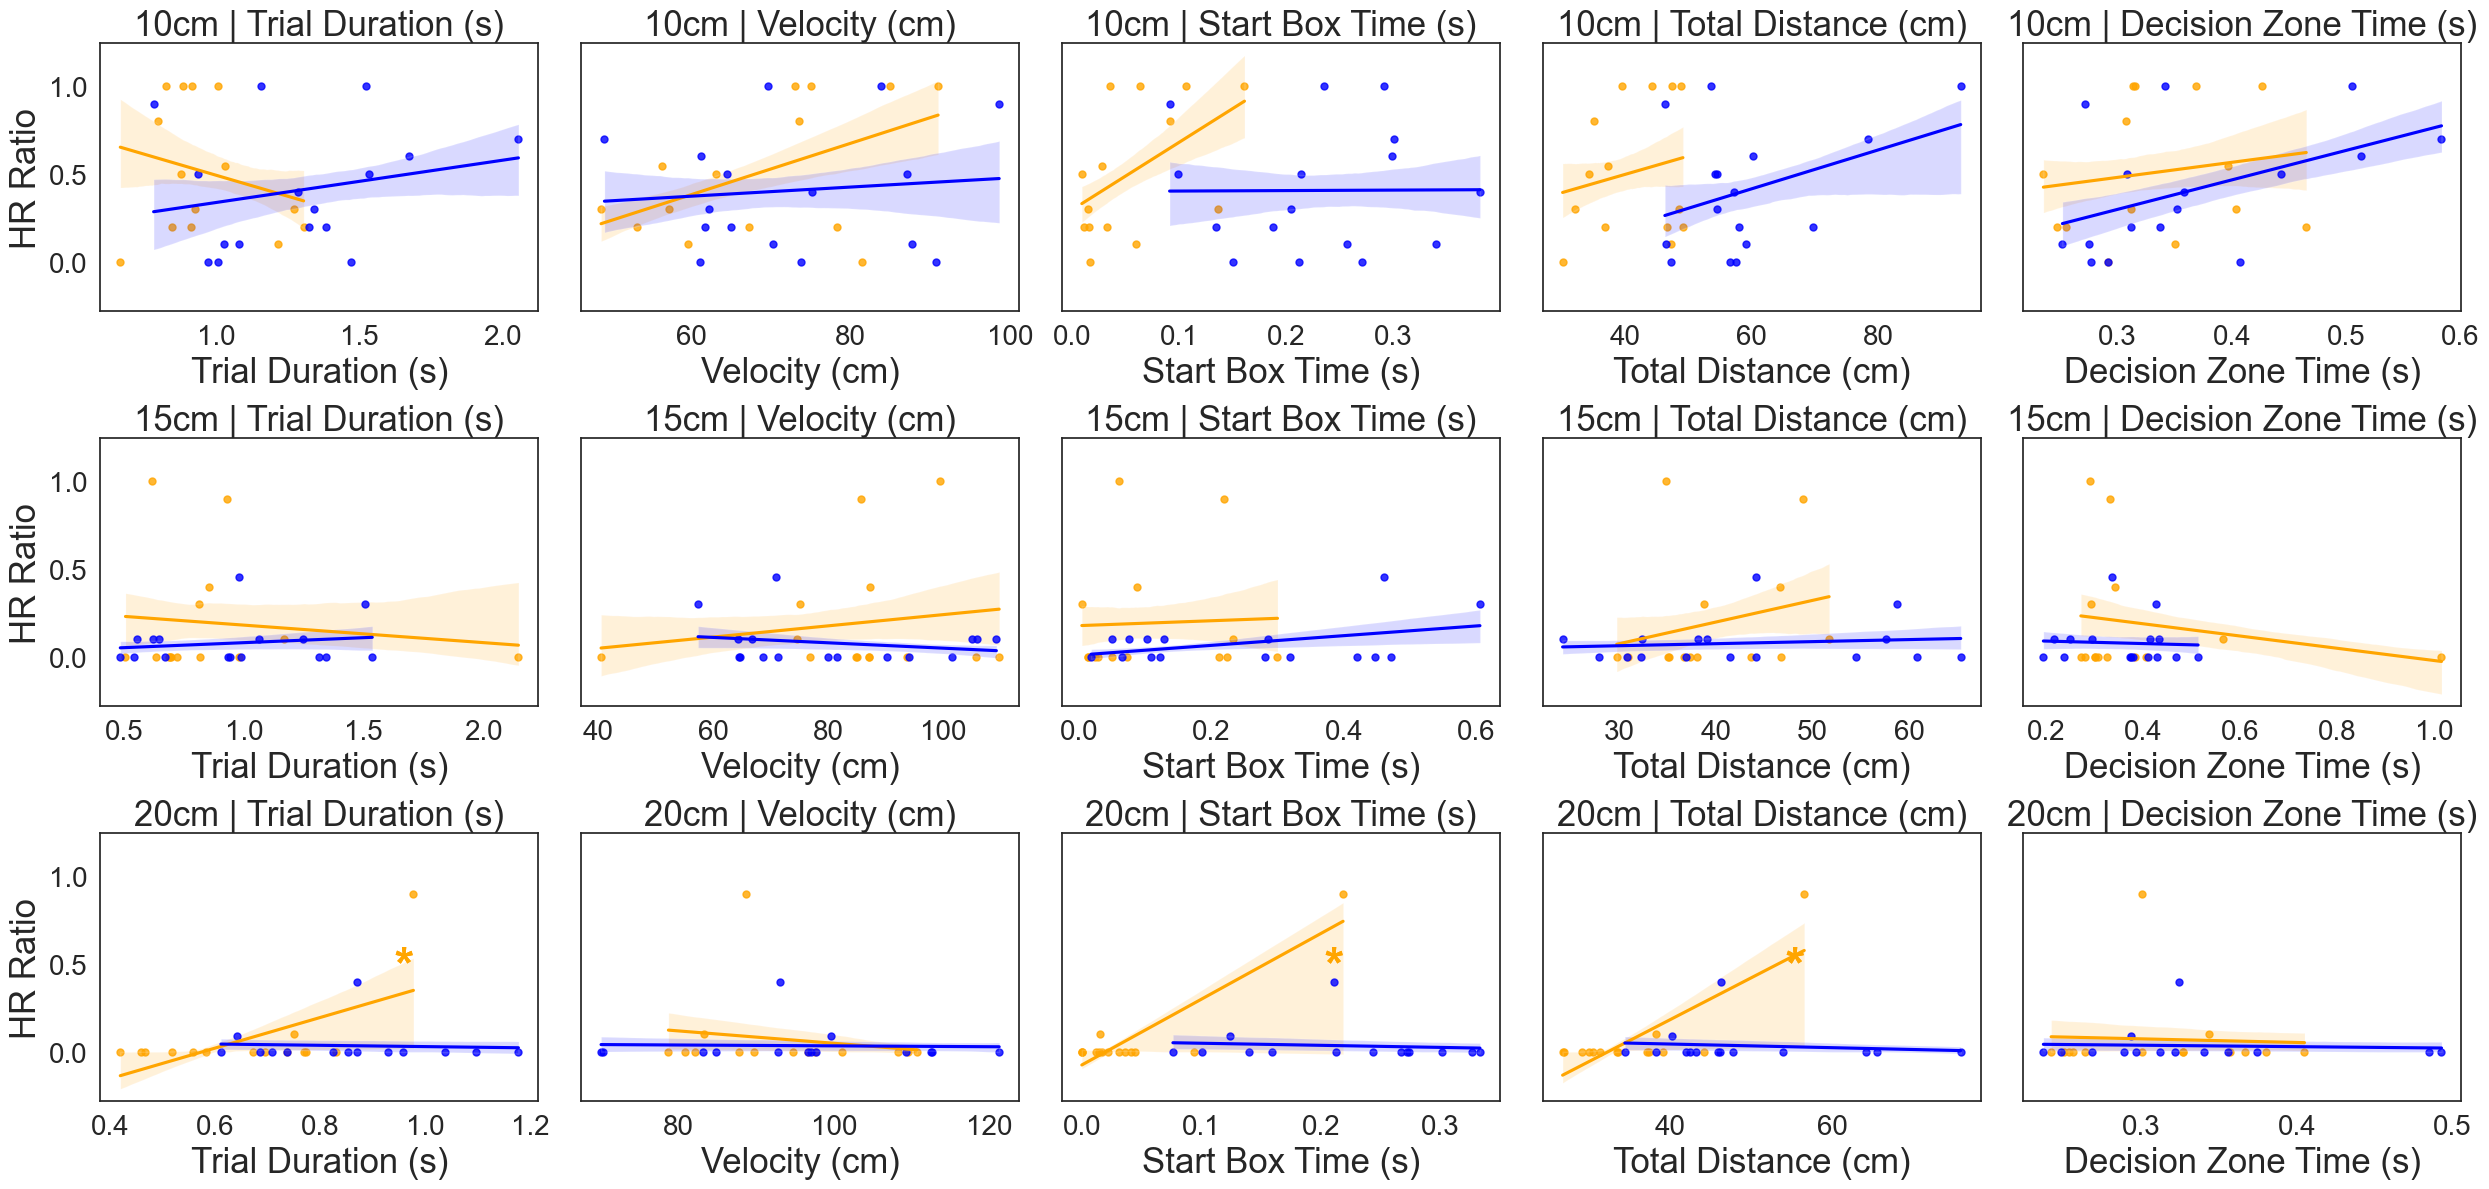

In [3003]:
# Variables and custom labels
variables = {
    'avg_trial_duration': 'Trial Duration (s)',
    'avg_velocity_cm': 'Velocity (cm)',
    'avg_start_box_time_secs': 'Start Box Time (s)',
    'total_distance_cm': 'Total Distance (cm)',
    'avg_decision_time_secs': 'Decision Zone Time (s)'
}

# Drop rows with missing data
clean_df = analysis_df.dropna(subset=list(variables.keys()) + ['HR_ratio', 'condition', 'experiment'])

# Get list of unique experiments
experiments = clean_df['experiment'].unique()
n_experiments = len(experiments)
n_vars = len(variables)

# Create subplots: one row per experiment, one column per variable
fig, axes = plt.subplots(nrows=n_experiments, ncols=n_vars, figsize=(5 * n_vars, 4 * n_experiments), sharey=True)

# Handle single-row case (flatten if necessary)
if n_experiments == 1:
    axes = [axes]

# Loop through experiments and variables
for i, experiment in enumerate(experiments):
    exp_df = clean_df[clean_df['experiment'] == experiment]
    for j, (var, label) in enumerate(variables.items()):
        ax = axes[i][j] if n_experiments > 1 else axes[0][j]

        # Plot Control group
        sns.regplot(
            data=exp_df[exp_df['condition'] == 'Control'],
            x=var, y='HR_ratio',
            color='orange', label='Control', ax=ax,
            scatter_kws={'s': 25},
            ci=68  # ±1 standard error band
        )

        # Plot CNSDS group
        sns.regplot(
            data=exp_df[exp_df['condition'] == 'CNSDS'],
            x=var, y='HR_ratio',
            color='blue', label='CNSDS', ax=ax,
            scatter_kws={'s': 25},
            ci=68  # ±1 standard error band
        )

        # Annotate significant correlations with asterisk
        for cond, color in [('Control', 'orange'), ('CNSDS', 'blue')]:
            subset = exp_df[exp_df['condition'] == cond]
            if len(subset) > 2:
                r, p = pearsonr(subset[var], subset['HR_ratio'])
                if p < 0.05:
                    x_pos = subset[var].max()
                    y_pos = subset['HR_ratio'].max() - 0.3
                    ax.text(x_pos, y_pos, '*', color=color, fontsize=35,
                            ha='right', va='top', fontweight='bold')
                
                # Print the correlation result
                print(f"Experiment: {experiment} | Condition: {cond} | Variable: {label} | r = {r:.3f}, p = {p:.4f}")
                
                if p < 0.05:
                    x_pos = subset[var].max()
                    y_pos = subset['HR_ratio'].max() - 0.3
                    ax.text(x_pos, y_pos, '*', color=color, fontsize=35,
                            ha='right', va='top', fontweight='bold')

        # Title and axis labels
        ax.set_title(f"{experiment} | {label}", fontsize=25)
        ax.set_xlabel(label, fontsize=25)
        if j == 0:
            ax.set_ylabel("HR Ratio", fontsize=25)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig("correlations_by_experiment.pdf", format="pdf")
plt.show()


In [2992]:
# Variables and display labels
variables = {
    'avg_trial_duration': 'Trial Duration (sec)',
    'avg_velocity_cm': 'Velocity (cm)',
    'avg_start_box_time_secs': 'Start Box Time (sec)',
    'total_distance_cm': 'Total Distance (cm)',
    'avg_decision_time_secs': 'Time in Decision Zone (secs)'
}

print("\n📊 Pearson Correlation Results by Condition:\n")
for var, label in variables.items():
    for cond in ['Control', 'CNSDS']:
        subset = clean_df[clean_df['condition'] == cond]
        if len(subset) >= 2:
            r, p = pearsonr(subset[var], subset['HR_ratio'])
            r_squared = r ** 2
            print(f"{cond} | {label}:")
            print(f"  r = {r:.3f}")
            print(f"  p-value = {p:.4f}")
            print(f"  Effect size (r²) = {r_squared:.3f}\n")
        else:
            print(f"{cond} | {label}: Not enough data\n")



📊 Pearson Correlation Results by Condition:

Control | Trial Duration (sec):
  r = 0.167
  p-value = 0.2900
  Effect size (r²) = 0.028

CNSDS | Trial Duration (sec):
  r = 0.427
  p-value = 0.0031
  Effect size (r²) = 0.182

Control | Velocity (cm):
  r = -0.166
  p-value = 0.2929
  Effect size (r²) = 0.028

CNSDS | Velocity (cm):
  r = -0.269
  p-value = 0.0704
  Effect size (r²) = 0.072

Control | Start Box Time (sec):
  r = 0.250
  p-value = 0.1096
  Effect size (r²) = 0.063

CNSDS | Start Box Time (sec):
  r = 0.083
  p-value = 0.5856
  Effect size (r²) = 0.007

Control | Total Distance (cm):
  r = 0.445
  p-value = 0.0031
  Effect size (r²) = 0.198

CNSDS | Total Distance (cm):
  r = 0.414
  p-value = 0.0043
  Effect size (r²) = 0.171

Control | Time in Decision Zone (secs):
  r = -0.061
  p-value = 0.7004
  Effect size (r²) = 0.004

CNSDS | Time in Decision Zone (secs):
  r = 0.267
  p-value = 0.0730
  Effect size (r²) = 0.071



In [2993]:
# # not working- need to figure out data structure

# # Convert 'subject' column to string in both dataframes to avoid type mismatch
# analysis_df['subject'] = analysis_df['subject'].astype(str)
# SIT_data_df['subject'] = SIT_data_df['subject'].astype(str)

# # Merge the dataframes on 'subject'
# merged_df = pd.merge(analysis_df, SIT_data_df[['subject', 'c57_sec', 'cd1_sec', 'object_sec']], on='subject')

# # Now we can run the correlation as before
# # Variables for SIT data columns
# sit_vars = ['c57', 'cd1', 'object']

# print("\n📊 Pearson Correlation Results between HR_ratio and SIT Data:\n")

# # Loop through SIT data columns and compute correlation with HR_ratio
# for var in sit_vars:
#     for cond in ['Control', 'CNSDS']:
#         subset = merged_df[merged_df['condition'] == cond]
#         if len(subset) >= 2:
#             r, p = pearsonr(subset[var], subset['HR_ratio'])
#             r_squared = r ** 2  # Effect size (r²)
#             print(f"{cond} | {var}:")
#             print(f"  r = {r:.3f}")
#             print(f"  p-value = {p:.4f}")
#             print(f"  Effect size (r²) = {r_squared:.3f}\n")
#         else:
#             print(f"{cond} | {var}: Not enough data\n")


In [2994]:
# subject-to-values mapping (replace number values)
attacks_values = {'WT022': 81, 'WT023': 83, 'WT025': 86, 'WT030': 15, 'WT031': 11, 'WT033': 12, 'WT038': 73, 'WT039': 68, 'WT040': 83, 'WT044': 14, 'WT045': 1, 'WT046': 6, 'WT050': 71, 'WT051': 53, 'WT052': 50, 'WT056': 9, 'WT057': 3, 'WT058': 6}
submissions_values = {'WT022': 92, 'WT023': 71, 'WT025': 63, 'WT030': 50, 'WT031': 41, 'WT033': 41, 'WT038': 128, 'WT039': 109, 'WT040': 105, 'WT044': 49, 'WT045': 42, 'WT061': 10, 'WT050': 62, 'WT051': 99, 'WT052': 46, 'WT056': 36, 'WT057': 18, 'WT058': 20}

# Convert each dictionary to a DataFrame
attacks_df = pd.DataFrame(list(attacks_values.items()), columns=['subject', 'num_attacks'])
submissions_df = pd.DataFrame(list(submissions_values.items()), columns=['subject', 'num_submissions'])

# Merge the two DataFrames on the subject column
stress_df = pd.merge(attacks_df, submissions_df, on='subject')

In [2995]:
#Do I need this?

# Step 1: Aggregate avg_start_box_time per subject
avg_start_box_time_df = analysis_df.groupby('subject', as_index=False)['avg_start_box_time'].mean()

# Step 2: Merge with stress_df
merged_df = pd.merge(stress_df, avg_start_box_time_df, on='subject')

# Step 3: Run correlations
# Correlation with num_attacks
r_attacks, p_attacks = pearsonr(merged_df['num_attacks'], merged_df['avg_start_box_time'])

# Correlation with num_submissions
r_subs, p_subs = pearsonr(merged_df['num_submissions'], merged_df['avg_start_box_time'])

# Output results
print(f"Correlation between number of attacks and avg_start_box_time: r = {r_attacks:.3f}, p = {p_attacks:.4f}")
print(f"Correlation between number of submissions and avg_start_box_time: r = {r_subs:.3f}, p = {p_subs:.4f}")

Correlation between number of attacks and avg_start_box_time: r = -0.356, p = 0.1925
Correlation between number of submissions and avg_start_box_time: r = -0.317, p = 0.2489


In [2996]:
# Step 1: Define variables to average
variables_to_average = [
    'avg_trial_duration',
    'avg_velocity_cm',
    'avg_start_box_time_secs',
    'total_distance_cm',
    'avg_decision_time_secs'
]

# Step 2: Compute mean per subject
behavior_means = analysis_df.groupby('subject', as_index=False)[variables_to_average].mean()

# Step 3: Merge with stress_df
stress_df = pd.merge(stress_df, behavior_means, on='subject')

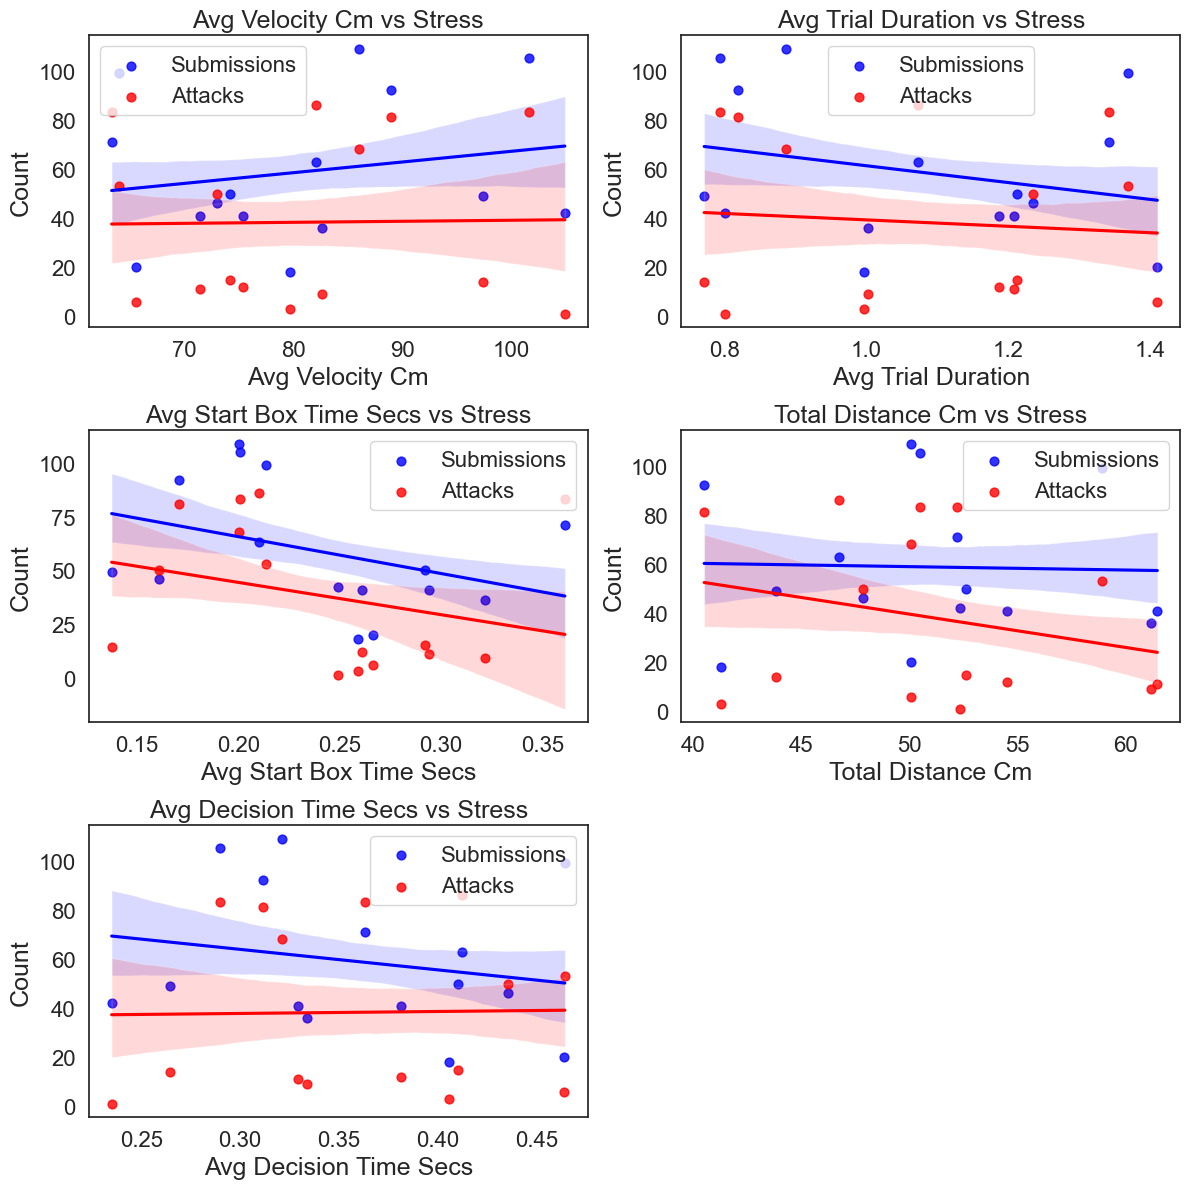

In [2998]:
# Variables to correlate
vars_to_test = [
    'avg_trial_duration',
    'avg_velocity_cm',
    'avg_start_box_time_secs',
    'total_distance_cm',
    'avg_decision_time_secs'
]

# Create subplots: 3 rows, 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Turn all axes off initially (hide unused)
for ax in axes.flatten():
    ax.set_visible(False)

# Plot order (row, col) - first plot top-right, others follow
plot_positions = [
    (0, 1),  # First plot (index 0) top-right
    (0, 0),  # Second plot (index 1) top-left
    (1, 0),  # Third plot (index 2)
    (1, 1),  # Fourth plot (index 3)
    (2, 0),  # Fifth plot (index 4)
]

for i, var in enumerate(vars_to_test):
    row, col = plot_positions[i]
    ax = axes[row, col]
    ax.set_visible(True)

    sns.regplot(
        data=stress_df,
        x=var, y='num_submissions',
        color='blue',
        label='Submissions',
        ax=ax,
        scatter_kws={'s': 40},
        ci=68
    )


    # Plot submissions
    sns.regplot(
        data=stress_df,
        x=var, y='num_attacks',
        color='red',
        label='Attacks',
        ax=ax,
        scatter_kws={'s': 40},
        ci=68  # ~1 SE band
    )

    # Compute correlations
    r_attack, p_attack = pearsonr(stress_df[var], stress_df['num_attacks'])
    r_sub, p_sub = pearsonr(stress_df[var], stress_df['num_submissions'])

    # Position for asterisks - lower than before
    y_max = max(stress_df['num_attacks'].max(), stress_df['num_submissions'].max())
    x_center = stress_df[var].mean()
    offset = y_max - 0.5  # lowered from 0.3 to 0.1

    if p_attack < 0.05:
        ax.text(x_center, y_max - offset, '*', ha='center', va='bottom', color='red', fontsize=22)

    if p_sub < 0.05:
        ax.text(x_center, y_max - offset * 2, '*', ha='center', va='bottom', color='blue', fontsize=22)

    # Formatting
    ax.set_xlabel(var.replace('_', ' ').title(), fontsize=18)
    ax.set_ylabel("Count", fontsize=18)
    ax.set_title(f'{var.replace("_", " ").title()} vs Stress', fontsize=18)
    ax.tick_params(axis='both', labelsize=16)

    # Show legend only once per axis
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=16)

# Hide the last unused subplot (bottom-right)
#fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.savefig("correlation_stress.pdf", format="pdf")
plt.show()


In [2999]:
# Load the exported DataFrame
new_analysis_df = pd.read_csv("new_analysis_df.csv")

In [3000]:
# Step 1: Group by syllable, subject, and experiment, then average the ratio
avg_ratios = (
    new_analysis_df
    .groupby(['syllable', 'subject', 'experiment'])['ratio']
    .mean()
    .reset_index()
)

condition_info = new_analysis_df[['subject', 'experiment', 'condition']].drop_duplicates()

syllable_ratio_df = pd.merge(avg_ratios, condition_info, on=['subject', 'experiment'], how='left')

syllable_ratio_df = pd.merge(
    analysis_df,
    syllable_ratio_df[['syllable', 'subject', 'experiment', 'ratio']],  # just columns you need
    on=['subject', 'experiment'],
    how='left'
)


Pearson correlation results:

Syllable: 0, Condition: Control, r = 0.286, p = 0.0662
Syllable: 0, Condition: CNSDS, r = -0.018, p = 0.9039
Syllable: 1, Condition: Control, r = -0.379, p = 0.0134
Syllable: 1, Condition: CNSDS, r = -0.211, p = 0.1591
Syllable: 2, Condition: Control, r = 0.108, p = 0.5030
Syllable: 2, Condition: CNSDS, r = -0.031, p = 0.8359
Syllable: 3, Condition: Control, r = 0.142, p = 0.3680
Syllable: 3, Condition: CNSDS, r = -0.143, p = 0.3436
Syllable: 4, Condition: Control, r = 0.014, p = 0.9295
Syllable: 4, Condition: CNSDS, r = 0.267, p = 0.0729
Syllable: 5, Condition: Control, r = -0.182, p = 0.2475
Syllable: 5, Condition: CNSDS, r = -0.209, p = 0.1627
Syllable: 6, Condition: Control, r = -0.154, p = 0.3488
Syllable: 6, Condition: CNSDS, r = -0.091, p = 0.5489
Syllable: 7, Condition: Control, r = -0.188, p = 0.2727
Syllable: 7, Condition: CNSDS, r = -0.106, p = 0.4842


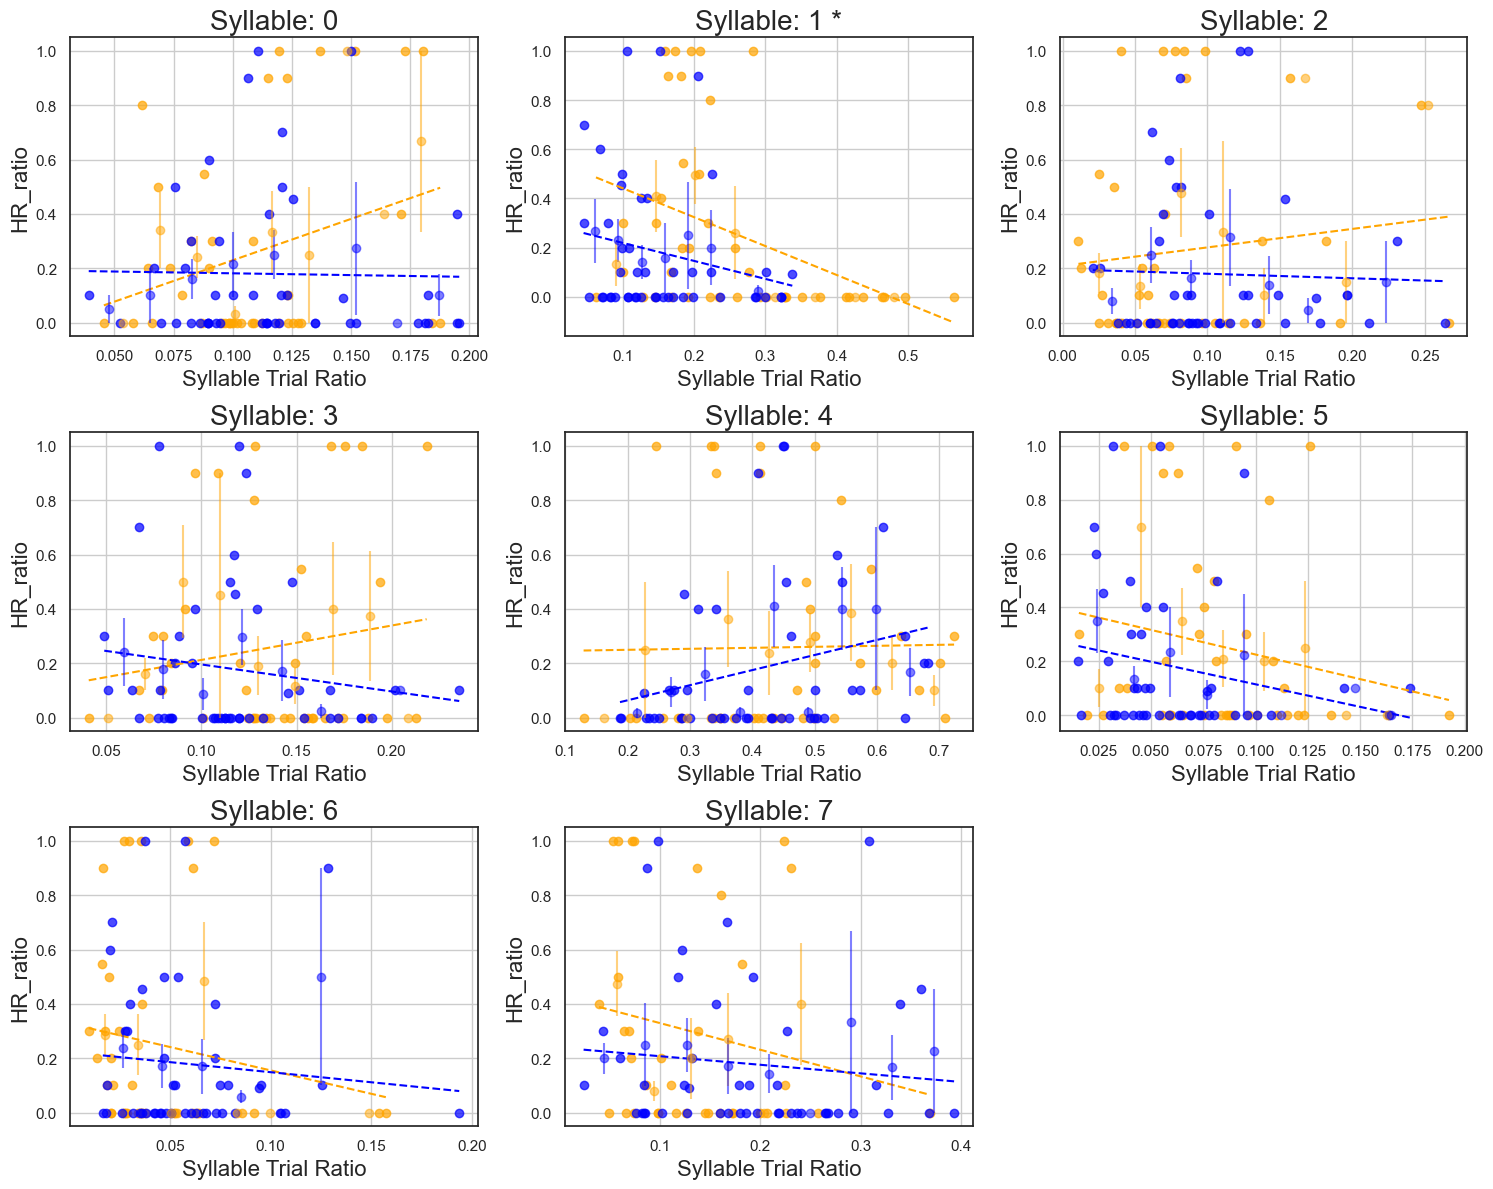

In [3001]:
colors = {'Control': 'orange', 'CNSDS': 'blue'}

syllables = syllable_ratio_df['syllable'].unique()
n_cols = 3
n_rows = (len(syllables) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

print("Pearson correlation results:\n")

for idx, syll in enumerate(syllables):
    ax = axes[idx // n_cols, idx % n_cols]
    data = syllable_ratio_df[syllable_ratio_df['syllable'] == syll]
    
    title = f"Syllable: {syll}"
    
    for condition, color in colors.items():
        subset = data[data['condition'] == condition]
        x = subset['ratio']
        y = subset['HR_ratio']

        if len(x) > 1 and len(y) > 1:
            r, p = pearsonr(x, y)
            print(f"Syllable: {syll}, Condition: {condition}, r = {r:.3f}, p = {p:.4f}")

            ax.scatter(x, y, color=color, alpha=0.7, label=f"{condition} (r={r:.2f})")

            # Bin for SEM error bars
            bins = np.linspace(x.min(), x.max(), 10)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            means = []
            sems = []
            for start, end in zip(bins[:-1], bins[1:]):
                bin_vals = y[(x >= start) & (x < end)]
                means.append(bin_vals.mean() if len(bin_vals) > 0 else np.nan)
                sems.append(bin_vals.sem() if len(bin_vals) > 1 else 0)
            means = np.array(means)
            sems = np.array(sems)
            valid = ~np.isnan(means)
            ax.errorbar(bin_centers[valid], means[valid], yerr=sems[valid], fmt='o', color=color, alpha=0.5)

            # Regression line
            slope, intercept, _, _, _ = linregress(x, y)
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = intercept + slope * x_fit
            ax.plot(x_fit, y_fit, color=color, linestyle='--')

            if p < 0.05:
                title += ' *'
        else:
            print(f"Syllable: {syll}, Condition: {condition} — Not enough data for correlation")
            ax.scatter(x, y, color=color, alpha=0.7, label=condition)
    
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel('Syllable Trial Ratio', fontsize=16)
    ax.set_ylabel('HR_ratio', fontsize=16)
    ax.grid(True)
    #ax.legend(fontsize=8)

for empty_ax in axes.flatten()[len(syllables):]:
    empty_ax.axis('off')

plt.tight_layout()
plt.savefig("D:/Figures/correlation_syllables.pdf", format="pdf")
plt.show()
